In [32]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from utilities import dLambda
from solver_1d import false_transient_one_iteration_python
from supportfunctions import PDESolver_2d, finiteDiff
import matplotlib.pyplot as plt
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d, derivative_1d
import SolveLinSys
import time
from solver_ode import solve_ode
from scipy import interpolate
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [34]:
# parameters
δ = 0.01
η = 0.032
μ = 1.86/1000
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
σy = 1.2*np.median(θ_list)
# damage function
ȳ = 2
γ1 = 0.00017675
γ2 = 2*0.0022
γ3_list = np.array([0, 2*0.0197, 2*0.3853])
# y grid
numy_bar = 200
y_min = 0
y_max = 4
hy = (ȳ - y_min)/numy_bar
y_grid = np.arange(y_min, y_max+hy, hy)

In [36]:
# no ambguity
def solve_base(y_grid, args, tol=1e-8, ϵ=0.3):
    δ, η, θ, σy, γ1, γ2, γ3, ȳ = args
    hy = y_grid[1] - y_grid[0]
    # initialize the while loop
    episode = 0
    lhs_error = 1
    dΛ = γ1 + γ2*y_grid + γ3*(y_grid - ȳ)*(y_grid>ȳ)
    ϕ =  - δ*η*y_grid**2
    ems = - δ*η/((η-1)*dΛ*θ)
    ems_old = ems
    h_star = 0
    while lhs_error > tol:
        ϕ_old = ϕ.copy()
        dϕdy = derivative_1d(ϕ, 1, hy)
        dϕdyy = derivative_1d(ϕ, 2, hy)
        temp = dϕdy + (η-1)*dΛ
        a = dϕdyy*σy**2  
        b = temp*θ
        c = δ*η
        Δ = b**2 - 4*a*c
        ems_new = (-b - np.sqrt(Δ))/(2*a)
        ems_new[ems_new <= 1e-15] = 1e-15    
        ems = ems_new*1 + ems_old*0
        # coefficients
        A = -δ*np.ones(y_grid.shape)
        B = ems*θ
        C = σy**2*ems**2/2
        D = δ*η*np.log(ems) + (η-1)*dΛ*ems*θ

        ϕ_new = solve_ode(A, B, C, D, y_grid, ϕ, ϵ, (False, 0))
        rhs = -δ*ϕ_new + B*dϕdy + C*dϕdyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
        ϕ = ϕ_new
        ems_old = ems
        episode += 1
        print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))
    return ϕ, ems

In [37]:
# intensity
def get_intensity(y_grid, ς, ȳ=2):
    temp = 1/(np.sqrt(np.pi*2)*ς)*np.exp(-(y_grid - ȳ)**2/(2*ς**2))
#     temp *= v_bar - v_new
    return temp

In [38]:
n_temp = 16
n_carb = 9
n_θ = len(θ_list)
θtemp_list = list()
for i in range(n_temp):
    same_temp = θ_list[i*n_carb:i*n_carb+n_carb+1]
    θtemp_list.append(np.average(same_temp))
θtemp_list = np.array(θtemp_list)
θcarb_list = list()
for i in range(n_carb):
    idx_carb = np.arange(i, n_θ+i, n_carb)
    same_carb = θ_list[idx_carb]
    θcarb_list.append(np.average(same_carb))
θcarb_list = np.array(θcarb_list)

# Jump model of damages
Intensity function:
$$
\mathcal{I}(y) = \begin{cases}
(\frac{1}{\sqrt{2\pi} \varsigma})\exp\left[- \frac{(y - \bar y)^2}{2\varsigma^2}\right], \quad y \leqslant \bar y\\
(\frac{1}{\sqrt{2\pi}\varsigma}), \quad y > \bar y
\end{cases}
$$

HJB
$$
\begin{aligned}
0 = \max_{\tilde e} \min_{\pi^d} &- \delta \phi(y) + \delta\eta \log\tilde e \\
& +  \frac{d\phi}{dy} \theta \tilde e  + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2\\
& + (\eta -1)(\gamma_1 + \gamma_2 y) \tilde e \theta + \mathcal{I}(y)\sum_j \pi^d_j \left[\phi_j(y) - \phi(y) \right] \\
&  + \textbf{relative entropy}
\end{aligned}
$$

## Approach two:
$$
\begin{aligned}
0 = \max_{\tilde e} \min_{g_j: \sum_j g_j \hat \pi_j=1} &- \delta \phi(y) + \delta\eta \log\tilde e \\
& +  \frac{d\phi}{dy} \theta \tilde e  + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2\\
& + (\eta -1)(\gamma_1 + \gamma_2 y) \tilde e \theta + \mathcal{I}(y)\sum_j\hat\pi_j g_j\left[\phi_j(y) - \phi(y) \right] \\
&  + \xi_m \mathcal{I}(y) \sum_j \hat\pi_j g_j \log g_j
\end{aligned}
$$
Minimize over $g_j$ gives:
$$
g_j = \cfrac{\exp\left( \frac{1}{\xi_m} [\phi(y) - \phi_j(y)] \right)}{\sum_{j} \hat\pi_j \exp\left( \frac{1}{\xi_m} [\phi(y) - \phi_j(y)] \right)}
$$
Plug back in:
$$
\begin{aligned}
0 = \max_{\tilde e} &- \delta \phi(y) + \delta\eta \log\tilde e \\
& +  \frac{d\phi}{dy} \theta \tilde e  + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2\\
& + (\eta -1)(\gamma_1 + \gamma_2 y) \tilde e \theta  \\
&   - \xi_m \mathcal{I}(y) \log \left(\sum_j \hat\pi_j \exp\left( \frac{1}{\xi_m} [\phi(y) - \phi_j(y)] \right) \right)
\end{aligned}
$$

First order condition for $\tilde e$:
$$
 \frac{d^2 \phi}{dy^2} |\sigma_y|^2 (\tilde e)^2 + [\frac{d\phi(y)}{dy} + (\eta -1)(\gamma_1 + \gamma_2 y)]\theta \tilde e + \delta \eta = 0
$$

In [11]:
# solve for approach 2
def solve_jump(y_grid, numy_bar, args, ϵ=0.3, tol=1e-8):
    """compute jump model with ambiguity over climate models
    """
    δ, η, θ_list, γ1, γ2, γ3_list, dmg_weight, ς, ξₘ, ξₐ, ξ = args
    # solve for ϕⱼ
    ϕ_list = list()
    for γ3 in γ3_list:
        args_post = (δ, η, θ_list, σy, γ1, γ2, γ3, ȳ, ξₐ, ξ)
        ϕ, _, _ , _ = solve_smooth(y_grid, args_post, tol=tol)
        ϕ_list.append(ϕ)
    ϕ_list = np.array(ϕ_list)
    # solve for HJB with jump function
    y_grid_cap = y_grid[:numy_bar+1]
    dΛ = γ1 + γ2*y_grid_cap
    ϕ = - δ*η*y_grid_cap**2
    dy = y_grid_cap[1] - y_grid_cap[0]
    ems = δ*η
    ems_old = ems
    episode = 0
    lhs_error = 1
    πᵈo = dmg_weight
    πᶜo = np.ones((len(θ_list), len(y_grid_cap)))/len(θ_list)
    while lhs_error > tol:
        ϕ_old = ϕ.copy()
        dϕdy = derivative_1d(ϕ, 1, dy, True)
        dϕdyy = derivative_1d(ϕ, 2, dy, True)
        # update control
        temp = dϕdy + (η-1)*dΛ
        weight = np.array([ - 1/ξₐ*temp*ems*θ for θ in θ_list])
        weight = weight - np.max(weight, axis=0)
        πᶜ = πᶜo*np.exp(weight)
        πᶜ[πᶜ <= 1e-15] = 1e-15
        πᶜ = πᶜ/np.sum(πᶜ, axis=0)
        # update control
        a = dϕdyy*σy**2  - 1/ξ*temp**2*σy**2
        b = (θ_list@πᶜ)*temp
        c = δ*η
        Δ = b**2 - 4*a*c
        Δ[Δ < 0] = 0
        root1 = (-b - np.sqrt(Δ))/(2*a)
        root2 = (-b + np.sqrt(Δ))/(2*a)
        if root1.all() > 0:
            ems_new = root1
        else:
            ems_new = root2
        ems_new[ems_new < 1e-15] = 1e-15
        ems = ems_new*0.5 + ems_old*0.5
        g_list = np.array([np.exp(1/ξₘ*(ϕ - ϕ_list[i][:numy_bar+1])) for i in range(len(γ3_list))])
        # coefficients
        A = -δ*np.ones(y_grid_cap.shape)
        By = (θ_list@πᶜ)*ems
        Cyy = ems**2*σy**2/2
        D = δ*η*np.log(ems) + θ_list@πᶜ*(η-1)*dΛ*ems\
        + ξₘ*get_intensity(y_grid_cap,ς)*(πᵈo@(1-g_list))\
        + ξₐ*np.sum(πᶜ*(np.log(πᶜ) - np.log(πᶜo)), axis=0) \
        - 1/(2*ξ)*temp**2*ems**2*σy**2
        # solver
        ϕ_new = solve_ode(A, By, Cyy, D, y_grid_cap, ϕ, ϵ, (False, 0))
        rhs = -δ*ϕ_new + By*dϕdy + Cyy*dϕdyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
        ϕ = ϕ_new
        episode += 1
        ems_old = ems
        print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))
    
    h =  - temp*ems*σy/ξ
    ι, πᵈ = get_ι(πᵈo, g_list)
    penalty = ξₘ*get_intensity(y_grid_cap, ς)*(πᵈo@(1 - g_list))
    return ϕ, ems, πᶜ, ι, πᵈ, h, ϕ_list

In [12]:
# compute proportional and distorted probability
def get_ι(πᵈo, g_list):
    ι = πᵈo@g_list
    n_dmg = len(πᵈo)
    π_star = np.array([g_list[i]*πᵈo[i]/ι for i in range(n_dmg)])
    return ι, π_star

In [31]:
def simulate_jump(y_grid, ems, πᶜ, πᵈ, ι, h, θ_list, T=100, dt=1):
    periods = int(T/dt)
    et = np.zeros(periods)
    yt = np.zeros(periods)
    πᶜt = np.zeros((periods, len(θ_list)))
    πᵈt = np.zeros((periods, len(πᵈ)))
    ιt = np.zeros(periods)
    ht = np.zeros(periods)
    # interpolate
    get_πᵈ = interpolate.interp1d(y_grid, πᵈ)
    get_πᶜ = interpolate.interp1d(y_grid, πᶜ)
    y = np.mean(θ_list)*290
    for t in range(periods):
        if y > np.max(y_grid):
            break
        else:
            ems_point = np.interp(y, y_grid, ems)
            πᵈ_list = get_πᵈ(y)
            πᶜ_list = get_πᶜ(y)
            ι_point = np.interp(y, y_grid, ι)
            h_point = np.interp(y, y_grid, h)
            et[t] = ems_point
            πᵈt[t] = πᵈ_list
            πᶜt[t] = πᶜ_list
            ιt[t] = ι_point
            ht[t] = h_point
            dy = ems_point*np.mean(θ_list)*dt
            y = dy + y
            yt[t] = y
    return yt, et, πᵈt, πᶜt, ιt, ht

In [14]:
# ξₘ is 1000, no ambiguity over damage
ς = 0.1
ξₐ = 1/15_000
ξₘ = 1000
ξ = 1/400
dmg_weight = np.array([0.475, 0.475, 0.05])
args = (δ, η, θ_list, γ1, γ2, γ3_list, dmg_weight, ς, ξₘ, ξₐ, ξ)
ϕ, ems, πᶜ, ι, πᵈ, h, ϕ_list = solve_jump(y_grid, numy_bar, args, tol=2e-6)

episode: 1,	 ode error: 0.0017052978664459698,	 ft error: 0.0014437808278042435
episode: 2,	 ode error: 0.001406541855785576,	 ft error: 0.0012760494138405161
episode: 3,	 ode error: 0.0013064839262923724,	 ft error: 0.001212254265911652
episode: 4,	 ode error: 0.0012396124647274028,	 ft error: 0.0011687764727934273
episode: 5,	 ode error: 0.001188507072598522,	 ft error: 0.0011338157906924612
episode: 6,	 ode error: 0.0011462480029463232,	 ft error: 0.001103366141419048
episode: 7,	 ode error: 0.0011110134794015784,	 ft error: 0.001076583644174257
episode: 8,	 ode error: 0.001080774069953357,	 ft error: 0.0010524537112590062
episode: 9,	 ode error: 0.0010546085851441786,	 ft error: 0.0010307848761992528
episode: 10,	 ode error: 0.0010315525619808495,	 ft error: 0.0010110465318462158
episode: 11,	 ode error: 0.0010109997035050958,	 ft error: 0.0009930134204311474
episode: 12,	 ode error: 0.0009924675282957974,	 ft error: 0.0009764135114268787
episode: 13,	 ode error: 0.0009755081471671

episode: 156,	 ode error: 0.00037795035231033905,	 ft error: 0.00037674175567866075
episode: 157,	 ode error: 0.0003756103076881039,	 ft error: 0.00037571702296679277
episode: 158,	 ode error: 0.00037458539827130914,	 ft error: 0.0003736011939191898
episode: 159,	 ode error: 0.0003725349597838162,	 ft error: 0.0003720559063445072
episode: 160,	 ode error: 0.0003711447884312801,	 ft error: 0.00037027355591559335
episode: 161,	 ode error: 0.00036920848737821905,	 ft error: 0.00036856767986288613
episode: 162,	 ode error: 0.000367582405777891,	 ft error: 0.00036672615348535187
episode: 163,	 ode error: 0.0003657106655567721,	 ft error: 0.0003649573610058308
episode: 164,	 ode error: 0.00036410013977073244,	 ft error: 0.00036353531202415934
episode: 165,	 ode error: 0.00036261379946755056,	 ft error: 0.00036090343052602725
episode: 166,	 ode error: 0.0003595801989020115,	 ft error: 0.0003585950193980142
episode: 167,	 ode error: 0.0003575576398718508,	 ft error: 0.00035677117019224336
epis

episode: 273,	 ode error: 0.0002249804498217254,	 ft error: 0.00022470406372464743
episode: 274,	 ode error: 0.0002241642600204454,	 ft error: 0.00022698263318752615
episode: 275,	 ode error: 0.00022498274420304737,	 ft error: 0.00022396531343833276
episode: 276,	 ode error: 0.0002231697492644522,	 ft error: 0.00022397766365966448
episode: 277,	 ode error: 0.0002229896657286193,	 ft error: 0.00022237420030902605
episode: 278,	 ode error: 0.00022163128371070523,	 ft error: 0.0002214251053912995
episode: 279,	 ode error: 0.00022078394972278143,	 ft error: 0.0002202919648528386
episode: 280,	 ode error: 0.00021953903952143944,	 ft error: 0.00021919755194853285
episode: 281,	 ode error: 0.00021857020329054126,	 ft error: 0.00021807374661441764
episode: 282,	 ode error: 0.0002176065169676994,	 ft error: 0.00021703380616205453
episode: 283,	 ode error: 0.00021652476302547457,	 ft error: 0.00021606404507536667
episode: 284,	 ode error: 0.0002154891808149133,	 ft error: 0.0002152562308153222
e

episode: 390,	 ode error: 0.0001417195828652437,	 ft error: 0.00014154222945460723
episode: 391,	 ode error: 0.0001412163656951688,	 ft error: 0.00014104140670693582
episode: 392,	 ode error: 0.00014071855463320337,	 ft error: 0.00014054218698415316
episode: 393,	 ode error: 0.00014021804342047295,	 ft error: 0.0001400371283006898
episode: 394,	 ode error: 0.00013970832786289254,	 ft error: 0.0001395209350639239
episode: 395,	 ode error: 0.00013918551557110643,	 ft error: 0.00013899118546929307
episode: 396,	 ode error: 0.00013864877196195508,	 ft error: 0.00013844846234720154
episode: 397,	 ode error: 0.00013810018425481426,	 ft error: 0.00013789594974613722
episode: 398,	 ode error: 0.00013754412799037218,	 ft error: 0.0001373386335987159
episode: 399,	 ode error: 0.00013698629363857588,	 ft error: 0.00013678227985799984
episode: 400,	 ode error: 0.00013643257021416638,	 ft error: 0.00013623237132614116
episode: 401,	 ode error: 0.00013588798917109053,	 ft error: 0.000135693175193074

episode: 509,	 ode error: 9.073607072861514e-05,	 ft error: 9.060001899918273e-05
episode: 510,	 ode error: 9.040435819915771e-05,	 ft error: 9.026863963717639e-05
episode: 511,	 ode error: 9.007396918538481e-05,	 ft error: 8.993858209233967e-05
episode: 512,	 ode error: 8.9744898469136e-05,	 ft error: 8.960984186399032e-05
episode: 513,	 ode error: 8.941714227015665e-05,	 ft error: 8.92824155926166e-05
episode: 514,	 ode error: 8.909069764768561e-05,	 ft error: 8.895630042797531e-05
episode: 515,	 ode error: 8.876556183821265e-05,	 ft error: 8.863149340456826e-05
episode: 516,	 ode error: 8.844173166744362e-05,	 ft error: 8.830799093362263e-05
episode: 517,	 ode error: 8.811920312565855e-05,	 ft error: 8.798578849040137e-05
episode: 518,	 ode error: 8.779797116605743e-05,	 ft error: 8.766488052293353e-05
episode: 519,	 ode error: 8.74780297253952e-05,	 ft error: 8.734526056826397e-05
episode: 520,	 ode error: 8.715937193443937e-05,	 ft error: 8.702692152270006e-05
episode: 521,	 ode e

episode: 610,	 ode error: 6.311023820472852e-05,	 ft error: 6.300091575583515e-05
episode: 611,	 ode error: 6.288859470823848e-05,	 ft error: 6.277947941108845e-05
episode: 612,	 ode error: 6.266783149919066e-05,	 ft error: 6.255892195043689e-05
episode: 613,	 ode error: 6.244794445922034e-05,	 ft error: 6.233923923321116e-05
episode: 614,	 ode error: 6.222892945534722e-05,	 ft error: 6.212042710509551e-05
episode: 615,	 ode error: 6.201078234147105e-05,	 ft error: 6.190248139782695e-05
episode: 616,	 ode error: 6.179349895697164e-05,	 ft error: 6.168539792914911e-05
episode: 617,	 ode error: 6.157707512751179e-05,	 ft error: 6.146917250283528e-05
episode: 618,	 ode error: 6.13615066645183e-05,	 ft error: 6.125380090887349e-05
episode: 619,	 ode error: 6.114678936499284e-05,	 ft error: 6.103927892288827e-05
episode: 620,	 ode error: 6.093291901171816e-05,	 ft error: 6.082560230697328e-05
episode: 621,	 ode error: 6.0719891373280945e-05,	 ft error: 6.0612766809621986e-05
episode: 622,	 

episode: 720,	 ode error: 4.314227520675325e-05,	 ft error: 4.304704335086895e-05
episode: 721,	 ode error: 4.299468180581588e-05,	 ft error: 4.289952550223797e-05
episode: 722,	 ode error: 4.2847602532560566e-05,	 ft error: 4.2752521388749375e-05
episode: 723,	 ode error: 4.270103545046561e-05,	 ft error: 4.260602908104372e-05
episode: 724,	 ode error: 4.2554978637094417e-05,	 ft error: 4.246004666326927e-05
episode: 725,	 ode error: 4.240943018311383e-05,	 ft error: 4.231457223315138e-05
episode: 726,	 ode error: 4.226438819297492e-05,	 ft error: 4.216960390139117e-05
episode: 727,	 ode error: 4.2119850783720026e-05,	 ft error: 4.202513979113347e-05
episode: 728,	 ode error: 4.197581608511613e-05,	 ft error: 4.188117803812878e-05
episode: 729,	 ode error: 4.1832282239048215e-05,	 ft error: 4.1737716790085644e-05
episode: 730,	 ode error: 4.168924739952852e-05,	 ft error: 4.159475420604612e-05
episode: 731,	 ode error: 4.154670973177503e-05,	 ft error: 4.145228845680212e-05
episode: 7

episode: 829,	 ode error: 2.9726353773470364e-05,	 ft error: 2.963773311108938e-05
episode: 830,	 ode error: 2.9625231038406534e-05,	 ft error: 2.9536658943188354e-05
episode: 831,	 ode error: 2.9524457468916004e-05,	 ft error: 2.943593375518324e-05
episode: 832,	 ode error: 2.942403184404824e-05,	 ft error: 2.9335556327216482e-05
episode: 833,	 ode error: 2.9323952947608563e-05,	 ft error: 2.9235525443871424e-05
episode: 834,	 ode error: 2.9224219568005708e-05,	 ft error: 2.913583989414918e-05
episode: 835,	 ode error: 2.912483049769953e-05,	 ft error: 2.9036498471723036e-05
episode: 836,	 ode error: 2.9025784534247477e-05,	 ft error: 2.8937499974568404e-05
episode: 837,	 ode error: 2.8927080479258013e-05,	 ft error: 2.8838843205101588e-05
episode: 838,	 ode error: 2.8828717138753277e-05,	 ft error: 2.874052697061924e-05
episode: 839,	 ode error: 2.873069332404339e-05,	 ft error: 2.8642550082303802e-05
episode: 840,	 ode error: 2.8633007849727292e-05,	 ft error: 2.8544911356125545e-05

episode: 939,	 ode error: 2.045590541487443e-05,	 ft error: 2.0371650825690146e-05
episode: 940,	 ode error: 2.038672365662405e-05,	 ft error: 2.030250087425393e-05
episode: 941,	 ode error: 2.0317779636735435e-05,	 ft error: 2.0233588539110097e-05
episode: 942,	 ode error: 2.0249072528602877e-05,	 ft error: 2.0164912994252715e-05
episode: 943,	 ode error: 2.0180601508868606e-05,	 ft error: 2.0096473416497673e-05
episode: 944,	 ode error: 2.0112365756916046e-05,	 ft error: 2.00282689859684e-05
episode: 945,	 ode error: 2.0044364455448012e-05,	 ft error: 1.9960298885286314e-05
episode: 946,	 ode error: 1.9976596789331928e-05,	 ft error: 1.9892562300218484e-05
episode: 947,	 ode error: 1.9909061946893174e-05,	 ft error: 1.9825058419006836e-05
episode: 948,	 ode error: 1.984175911862163e-05,	 ft error: 1.9757786432645735e-05
episode: 949,	 ode error: 1.977468749764168e-05,	 ft error: 1.9690745534326853e-05
episode: 950,	 ode error: 1.9707846279431833e-05,	 ft error: 1.962393492017933e-05


episode: 1053,	 ode error: 1.3919591216245055e-05,	 ft error: 1.3838277519231945e-05
episode: 1054,	 ode error: 1.387282129712065e-05,	 ft error: 1.3791528115578156e-05
episode: 1055,	 ode error: 1.382621133960238e-05,	 ft error: 1.3744938595049624e-05
episode: 1056,	 ode error: 1.3779760790453535e-05,	 ft error: 1.3698508404639636e-05
episode: 1057,	 ode error: 1.3733469098320015e-05,	 ft error: 1.365223699363131e-05
episode: 1058,	 ode error: 1.368733571416043e-05,	 ft error: 1.3606123812695547e-05
episode: 1059,	 ode error: 1.3641360090353152e-05,	 ft error: 1.3560168314885601e-05
episode: 1060,	 ode error: 1.3595541681490062e-05,	 ft error: 1.3514369954804411e-05
episode: 1061,	 ode error: 1.3549879943701307e-05,	 ft error: 1.3468728188859025e-05
episode: 1062,	 ode error: 1.3504374335110664e-05,	 ft error: 1.3423242475445648e-05
episode: 1063,	 ode error: 1.3459024315468754e-05,	 ft error: 1.3377912274417647e-05
episode: 1064,	 ode error: 1.3413829346208017e-05,	 ft error: 1.33327

episode: 1167,	 ode error: 9.497000854117579e-06,	 ft error: 9.417583783158379e-06
episode: 1168,	 ode error: 9.465324368413915e-06,	 ft error: 9.385920518162338e-06
episode: 1169,	 ode error: 9.433755714414972e-06,	 ft error: 9.354365034496456e-06
episode: 1170,	 ode error: 9.402294521360143e-06,	 ft error: 9.32291696074487e-06
episode: 1171,	 ode error: 9.370940418572415e-06,	 ft error: 9.291575926810108e-06
episode: 1172,	 ode error: 9.339693037005306e-06,	 ft error: 9.260341563797441e-06
episode: 1173,	 ode error: 9.308552009034809e-06,	 ft error: 9.229213504038011e-06
episode: 1174,	 ode error: 9.277516967753463e-06,	 ft error: 9.198191380996312e-06
episode: 1175,	 ode error: 9.24658754782601e-06,	 ft error: 9.167274829570879e-06
episode: 1176,	 ode error: 9.215763385264208e-06,	 ft error: 9.136463485839852e-06
episode: 1177,	 ode error: 9.18504411714276e-06,	 ft error: 9.105756987176639e-06
episode: 1178,	 ode error: 9.154429382071715e-06,	 ft error: 9.0751549724812e-06
episode: 

episode: 1282,	 ode error: 6.47760616517151e-06,	 ft error: 6.399418850134657e-06
episode: 1283,	 ode error: 6.456185469756151e-06,	 ft error: 6.378006625803087e-06
episode: 1284,	 ode error: 6.434837343538406e-06,	 ft error: 6.356666938100997e-06
episode: 1285,	 ode error: 6.413561537469228e-06,	 ft error: 6.335399537598282e-06
episode: 1286,	 ode error: 6.39235780290192e-06,	 ft error: 6.3142041762294845e-06
episode: 1287,	 ode error: 6.371225892753854e-06,	 ft error: 6.293080606877463e-06
episode: 1288,	 ode error: 6.350165560365132e-06,	 ft error: 6.272028583280872e-06
episode: 1289,	 ode error: 6.32917656059385e-06,	 ft error: 6.2510478601035535e-06
episode: 1290,	 ode error: 6.308258648684076e-06,	 ft error: 6.230138193212091e-06
episode: 1291,	 ode error: 6.287411581454468e-06,	 ft error: 6.209299339259474e-06
episode: 1292,	 ode error: 6.266635116298634e-06,	 ft error: 6.188531055708232e-06
episode: 1293,	 ode error: 6.245929011307436e-06,	 ft error: 6.167833101246764e-06
episo

episode: 1395,	 ode error: 4.463178488908347e-06,	 ft error: 4.385767723829223e-06
episode: 1396,	 ode error: 4.448567383972266e-06,	 ft error: 4.371162081601154e-06
episode: 1397,	 ode error: 4.4340055455345095e-06,	 ft error: 4.356605684818771e-06
episode: 1398,	 ode error: 4.419492805507095e-06,	 ft error: 4.342098365051987e-06
episode: 1399,	 ode error: 4.4050289959399495e-06,	 ft error: 4.327639954819033e-06
episode: 1400,	 ode error: 4.390613949778986e-06,	 ft error: 4.313230286568752e-06
episode: 1401,	 ode error: 4.376247499815293e-06,	 ft error: 4.2988691936983e-06
episode: 1402,	 ode error: 4.361929480033557e-06,	 ft error: 4.28455650997491e-06
episode: 1403,	 ode error: 4.347659724389299e-06,	 ft error: 4.270292069882831e-06
episode: 1404,	 ode error: 4.333438068479414e-06,	 ft error: 4.2560757084614265e-06
episode: 1405,	 ode error: 4.319264347354794e-06,	 ft error: 4.241907261767763e-06
episode: 1406,	 ode error: 4.305138397932241e-06,	 ft error: 4.227786566067075e-06
epis

episode: 1493,	 ode error: 3.241840723984535e-06,	 ft error: 3.1648758745903933e-06
episode: 1494,	 ode error: 3.231339848503746e-06,	 ft error: 3.1543787273879964e-06
episode: 1495,	 ode error: 3.2208742327030073e-06,	 ft error: 3.14391682530261e-06
episode: 1496,	 ode error: 3.2104437563884244e-06,	 ft error: 3.1334900483838877e-06
episode: 1497,	 ode error: 3.200048299740045e-06,	 ft error: 3.1230982768665205e-06
episode: 1498,	 ode error: 3.189687743610013e-06,	 ft error: 3.1127413916328304e-06
episode: 1499,	 ode error: 3.1793619692287514e-06,	 ft error: 3.10241927409712e-06
episode: 1500,	 ode error: 3.1690708585086456e-06,	 ft error: 3.0921318065063597e-06
episode: 1501,	 ode error: 3.1588142942454893e-06,	 ft error: 3.081878871269428e-06
episode: 1502,	 ode error: 3.1485921591299084e-06,	 ft error: 3.0716603518591663e-06
episode: 1503,	 ode error: 3.1384043372665454e-06,	 ft error: 3.061476131748416e-06
episode: 1504,	 ode error: 3.128250712576162e-06,	 ft error: 3.051326095242

episode: 1607,	 ode error: 2.245590727611795e-06,	 ft error: 2.1689696372053278e-06
episode: 1608,	 ode error: 2.238427876049805e-06,	 ft error: 2.161809175583544e-06
episode: 1609,	 ode error: 2.2312889669030313e-06,	 ft error: 2.1546726468082054e-06
episode: 1610,	 ode error: 2.224173919303544e-06,	 ft error: 2.147559969740513e-06
episode: 1611,	 ode error: 2.2170826519665385e-06,	 ft error: 2.1404710633804447e-06
episode: 1612,	 ode error: 2.2100150841161334e-06,	 ft error: 2.1334058468204984e-06
episode: 1613,	 ode error: 2.2029711350609075e-06,	 ft error: 2.1263642392688187e-06
episode: 1614,	 ode error: 2.195950724046339e-06,	 ft error: 2.1193461602573666e-06
episode: 1615,	 ode error: 2.1889537707844376e-06,	 ft error: 2.112351529503139e-06
episode: 1616,	 ode error: 2.181980195138677e-06,	 ft error: 2.105380266838782e-06
episode: 1617,	 ode error: 2.1750299173204507e-06,	 ft error: 2.0984322928139605e-06
episode: 1618,	 ode error: 2.168102857995108e-06,	 ft error: 2.09150752797

episode: 95,	 ode error: 0.0005132873091033893,	 ft error: 0.0005117850867116085
episode: 96,	 ode error: 0.0005104735935689334,	 ft error: 0.0005089908189862338
episode: 97,	 ode error: 0.0005076853463482908,	 ft error: 0.0005062215806994041
episode: 98,	 ode error: 0.0005049221292796972,	 ft error: 0.0005034769481924647
episode: 99,	 ode error: 0.0005021835160574971,	 ft error: 0.0005007565089070836
episode: 100,	 ode error: 0.0004994690916749015,	 ft error: 0.0004980598608626934
episode: 101,	 ode error: 0.0004967784518793543,	 ft error: 0.0004953866121345264
episode: 102,	 ode error: 0.0004941112026385084,	 ft error: 0.0004927363803462181
episode: 103,	 ode error: 0.0004914669596139318,	 ft error: 0.0004901087921654659
episode: 104,	 ode error: 0.0004888453476406553,	 ft error: 0.00048750348278094047
episode: 105,	 ode error: 0.00048624600021082145,	 ft error: 0.0004849200954460421
episode: 106,	 ode error: 0.00048366855895939616,	 ft error: 0.00048235828092885413
episode: 107,	 od

episode: 205,	 ode error: 0.0002889222682292093,	 ft error: 0.000288059807025907
episode: 206,	 ode error: 0.00028727480991518214,	 ft error: 0.00028641642103551434
episode: 207,	 ode error: 0.0002856336755209339,	 ft error: 0.00028477939135187574
episode: 208,	 ode error: 0.000283998954249128,	 ft error: 0.0002831488065629939
episode: 209,	 ode error: 0.0002823707321178953,	 ft error: 0.00028152475194102855
episode: 210,	 ode error: 0.00028074909191327544,	 ft error: 0.0002799073094144483
episode: 211,	 ode error: 0.00027913411315435123,	 ft error: 0.0002782965575418017
episode: 212,	 ode error: 0.0002775258720702146,	 ft error: 0.0002766925715054491
episode: 213,	 ode error: 0.00027592444158744075,	 ft error: 0.0002750954231082783
episode: 214,	 ode error: 0.0002743298913283858,	 ft error: 0.00027350518078684183
episode: 215,	 ode error: 0.0002727422876176369,	 ft error: 0.00027192190962310736
episode: 216,	 ode error: 0.00027116169349750347,	 ft error: 0.000270345671373994
episode: 

episode: 353,	 ode error: 0.0001201905483930539,	 ft error: 0.00011999509549038187
episode: 354,	 ode error: 0.00011948090414592983,	 ft error: 0.00011928935769571955
episode: 355,	 ode error: 0.00011877551650587182,	 ft error: 0.00011858786313746761
episode: 356,	 ode error: 0.00011807435799636576,	 ft error: 0.00011789058439186836
episode: 357,	 ode error: 0.00011737740132979177,	 ft error: 0.0001171974938905344
episode: 358,	 ode error: 0.00011668461941362319,	 ft error: 0.00011650856420068745
episode: 359,	 ode error: 0.00011599598535611097,	 ft error: 0.00011582376844276414
episode: 360,	 ode error: 0.00011531147246372157,	 ft error: 0.00011514308035913412
episode: 361,	 ode error: 0.00011463105423186544,	 ft error: 0.00011446647374777075
episode: 362,	 ode error: 0.00011395470433921715,	 ft error: 0.00011379392220484119
episode: 363,	 ode error: 0.00011328239664907494,	 ft error: 0.00011312539961426857
episode: 364,	 ode error: 0.00011261410521054929,	 ft error: 0.000112460879930

episode: 464,	 ode error: 6.292146242701103e-05,	 ft error: 6.258640173536593e-05
episode: 465,	 ode error: 6.255812780916364e-05,	 ft error: 6.222437326251773e-05
episode: 466,	 ode error: 6.21967558372664e-05,	 ft error: 6.186429870195613e-05
episode: 467,	 ode error: 6.183733689257495e-05,	 ft error: 6.150616850689647e-05
episode: 468,	 ode error: 6.147986138360358e-05,	 ft error: 6.114997315608921e-05
episode: 469,	 ode error: 6.112431974679823e-05,	 ft error: 6.079570315610979e-05
episode: 470,	 ode error: 6.077070244760207e-05,	 ft error: 6.044334904121984e-05
episode: 471,	 ode error: 6.041899998110911e-05,	 ft error: 6.0092901375009375e-05
episode: 472,	 ode error: 6.006920287310281e-05,	 ft error: 5.974435075058182e-05
episode: 473,	 ode error: 5.972130168071968e-05,	 ft error: 5.939768779245069e-05
episode: 474,	 ode error: 5.9375286993185584e-05,	 ft error: 5.905290315600757e-05
episode: 475,	 ode error: 5.903114943278914e-05,	 ft error: 5.870998752951125e-05
episode: 476,	 

episode: 576,	 ode error: 3.244234967995907e-05,	 ft error: 3.22115320094731e-05
episode: 577,	 ode error: 3.2246577164199235e-05,	 ft error: 3.2016392532164636e-05
episode: 578,	 ode error: 3.2051893716341555e-05,	 ft error: 3.182233812147606e-05
episode: 579,	 ode error: 3.185829342887121e-05,	 ft error: 3.162936289970164e-05
episode: 580,	 ode error: 3.166577042980042e-05,	 ft error: 3.1437461023714475e-05
episode: 581,	 ode error: 3.1474318882021134e-05,	 ft error: 3.124662668524403e-05
episode: 582,	 ode error: 3.128393298310343e-05,	 ft error: 3.105685411004348e-05
episode: 583,	 ode error: 3.109460696459443e-05,	 ft error: 3.086813755749651e-05
episode: 584,	 ode error: 3.0906335091554255e-05,	 ft error: 3.071550485574115e-05
episode: 585,	 ode error: 3.071911166226951e-05,	 ft error: 3.063717733024542e-05
episode: 586,	 ode error: 3.053293100746871e-05,	 ft error: 3.055904309221906e-05
episode: 587,	 ode error: 3.0347787489876273e-05,	 ft error: 3.0481101652978886e-05
episode: 

episode: 687,	 ode error: 2.265993032641851e-05,	 ft error: 2.4123461094226195e-05
episode: 688,	 ode error: 2.259844971675589e-05,	 ft error: 2.405517807886152e-05
episode: 689,	 ode error: 2.253711923881426e-05,	 ft error: 2.3992143463614134e-05
episode: 690,	 ode error: 2.2475941008911435e-05,	 ft error: 2.3929111105033818e-05
episode: 691,	 ode error: 2.2414911119041304e-05,	 ft error: 2.386740537625489e-05
episode: 692,	 ode error: 2.2354028970455575e-05,	 ft error: 2.3806095271565002e-05
episode: 693,	 ode error: 2.2293294109666442e-05,	 ft error: 2.374501082529068e-05
episode: 694,	 ode error: 2.2232706554680553e-05,	 ft error: 2.3683972506192513e-05
episode: 695,	 ode error: 2.2172266351309163e-05,	 ft error: 2.3622947487774347e-05
episode: 696,	 ode error: 2.211197352939797e-05,	 ft error: 2.3561936653843096e-05
episode: 697,	 ode error: 2.2051828036906006e-05,	 ft error: 2.3500967264236672e-05
episode: 698,	 ode error: 2.199182974231873e-05,	 ft error: 2.3440069209998415e-05


episode: 801,	 ode error: 1.6542840228257256e-05,	 ft error: 1.7908040769246125e-05
episode: 802,	 ode error: 1.649648150220295e-05,	 ft error: 1.786116131286449e-05
episode: 803,	 ode error: 1.6450238402095394e-05,	 ft error: 1.7814404805159556e-05
episode: 804,	 ode error: 1.640411064666254e-05,	 ft error: 1.7767771004680948e-05
episode: 805,	 ode error: 1.6358097955085403e-05,	 ft error: 1.77212596644503e-05
episode: 806,	 ode error: 1.631220004700144e-05,	 ft error: 1.7674870537766806e-05
episode: 807,	 ode error: 1.6266416642507492e-05,	 ft error: 1.762860337391666e-05
episode: 808,	 ode error: 1.622074746217934e-05,	 ft error: 1.7582457919364247e-05
episode: 809,	 ode error: 1.6175192227073262e-05,	 ft error: 1.7536433917116068e-05
episode: 810,	 ode error: 1.6129750658736214e-05,	 ft error: 1.7490531107067685e-05
episode: 811,	 ode error: 1.608442247922045e-05,	 ft error: 1.74447492259112e-05
episode: 812,	 ode error: 1.6039207411097114e-05,	 ft error: 1.739908800477604e-05
epis

episode: 900,	 ode error: 1.2472571959249926e-05,	 ft error: 1.3812284691376575e-05
episode: 901,	 ode error: 1.2436403566979125e-05,	 ft error: 1.3775949567115347e-05
episode: 902,	 ode error: 1.2400326425730877e-05,	 ft error: 1.3739705140373057e-05
episode: 903,	 ode error: 1.2364340323129085e-05,	 ft error: 1.3703551213449055e-05
episode: 904,	 ode error: 1.23284450471871e-05,	 ft error: 1.3667487590250198e-05
episode: 905,	 ode error: 1.2292640386303214e-05,	 ft error: 1.3631514077690199e-05
episode: 906,	 ode error: 1.2256926129254218e-05,	 ft error: 1.359563048402429e-05
episode: 907,	 ode error: 1.222130206519369e-05,	 ft error: 1.3559836620237003e-05
episode: 908,	 ode error: 1.2185767983642344e-05,	 ft error: 1.3524132299382968e-05
episode: 909,	 ode error: 1.2150323674484754e-05,	 ft error: 1.34885173356733e-05
episode: 910,	 ode error: 1.211496892797106e-05,	 ft error: 1.345299154528514e-05
episode: 911,	 ode error: 1.2079703534715203e-05,	 ft error: 1.3417554745158896e-05


episode: 1013,	 ode error: 8.915646444372579e-06,	 ft error: 1.023692308729322e-05
episode: 1014,	 ode error: 8.888533610378459e-06,	 ft error: 1.0209664217143699e-05
episode: 1015,	 ode error: 8.861490434220614e-06,	 ft error: 1.0182475924022199e-05
episode: 1016,	 ode error: 8.834516745189218e-06,	 ft error: 1.0155358072203951e-05
episode: 1017,	 ode error: 8.807612372862026e-06,	 ft error: 1.0128310524634237e-05
episode: 1018,	 ode error: 8.78077714710785e-06,	 ft error: 1.0101333142569873e-05
episode: 1019,	 ode error: 8.754010898087016e-06,	 ft error: 1.0074425786747259e-05
episode: 1020,	 ode error: 8.727313456260337e-06,	 ft error: 1.0047588315034717e-05
episode: 1021,	 ode error: 8.700684652389003e-06,	 ft error: 1.0020820584687637e-05
episode: 1022,	 ode error: 8.674124317540737e-06,	 ft error: 9.994122452209691e-06
episode: 1023,	 ode error: 8.647632283096703e-06,	 ft error: 9.967493769594271e-06
episode: 1024,	 ode error: 8.621208380755411e-06,	 ft error: 9.940934390523237e-

episode: 1128,	 ode error: 6.2144197818429585e-06,	 ft error: 7.527670663511066e-06
episode: 1129,	 ode error: 6.194280036799551e-06,	 ft error: 7.50754800430085e-06
episode: 1130,	 ode error: 6.174192483250542e-06,	 ft error: 7.487478171109656e-06
episode: 1131,	 ode error: 6.15415699056746e-06,	 ft error: 7.467460977743831e-06
episode: 1132,	 ode error: 6.134173428559497e-06,	 ft error: 7.44749623874987e-06
episode: 1133,	 ode error: 6.114241667468578e-06,	 ft error: 7.4275837713341786e-06
episode: 1134,	 ode error: 6.094361577977574e-06,	 ft error: 7.407723393466441e-06
episode: 1135,	 ode error: 6.074533031195798e-06,	 ft error: 7.387914923763969e-06
episode: 1136,	 ode error: 6.054755898658357e-06,	 ft error: 7.368158185111495e-06
episode: 1137,	 ode error: 6.035030052327291e-06,	 ft error: 7.348452998323651e-06
episode: 1138,	 ode error: 6.015355364577502e-06,	 ft error: 7.328799190032173e-06
episode: 1139,	 ode error: 5.9957317081954845e-06,	 ft error: 7.3091965851225056e-06
epi

episode: 1244,	 ode error: 4.195689985914998e-06,	 ft error: 5.510079730507156e-06
episode: 1245,	 ode error: 4.1808161401487665e-06,	 ft error: 5.495210835664936e-06
episode: 1246,	 ode error: 4.1659813604255245e-06,	 ft error: 5.4803811278443994e-06
episode: 1247,	 ode error: 4.151185547799003e-06,	 ft error: 5.465590507252686e-06
episode: 1248,	 ode error: 4.136428603549315e-06,	 ft error: 5.450838877300394e-06
episode: 1249,	 ode error: 4.121710429190001e-06,	 ft error: 5.436126139674961e-06
episode: 1250,	 ode error: 4.107030926461173e-06,	 ft error: 5.421452197486298e-06
episode: 1251,	 ode error: 4.092389997339111e-06,	 ft error: 5.406816952861308e-06
episode: 1252,	 ode error: 4.0777875440300255e-06,	 ft error: 5.392220308782688e-06
episode: 1253,	 ode error: 4.0632234689681615e-06,	 ft error: 5.377662167053525e-06
episode: 1254,	 ode error: 4.0486976748247176e-06,	 ft error: 5.363142432703491e-06
episode: 1255,	 ode error: 4.0342100644927465e-06,	 ft error: 5.348661006714569e-

episode: 1397,	 ode error: 2.3211932545610697e-06,	 ft error: 3.6374608991760855e-06
episode: 1398,	 ode error: 2.311273457051557e-06,	 ft error: 3.6275579399248454e-06
episode: 1399,	 ode error: 2.301380055197346e-06,	 ft error: 3.617681406826538e-06
episode: 1400,	 ode error: 2.2915129808202795e-06,	 ft error: 3.6078312294745194e-06
episode: 1401,	 ode error: 2.2816721659142376e-06,	 ft error: 3.5980073406656028e-06
episode: 1402,	 ode error: 2.271857542640636e-06,	 ft error: 3.588209671045543e-06
episode: 1403,	 ode error: 2.2620690433223015e-06,	 ft error: 3.5784381542669497e-06
episode: 1404,	 ode error: 2.252306600455153e-06,	 ft error: 3.568692720096652e-06
episode: 1405,	 ode error: 2.242570146703053e-06,	 ft error: 3.558973303494084e-06
episode: 1406,	 ode error: 2.2328596148944724e-06,	 ft error: 3.54927983454989e-06
episode: 1407,	 ode error: 2.223174938022519e-06,	 ft error: 3.5396122474255316e-06
episode: 1408,	 ode error: 2.2135160492463995e-06,	 ft error: 3.5299704744089

episode: 1498,	 ode error: 1.4422250105180752e-06,	 ft error: 2.7599538947667424e-06
episode: 1499,	 ode error: 1.4346788355145204e-06,	 ft error: 2.752400681954592e-06
episode: 1500,	 ode error: 1.427152873483456e-06,	 ft error: 2.7448677722766157e-06
episode: 1501,	 ode error: 1.4196470717040336e-06,	 ft error: 2.7373551116557002e-06
episode: 1502,	 ode error: 1.4121673146785568e-06,	 ft error: 2.72986264845491e-06
episode: 1503,	 ode error: 1.4047267655658213e-06,	 ft error: 2.722390328643391e-06
episode: 1504,	 ode error: 1.3973061351839756e-06,	 ft error: 2.714938100040661e-06
episode: 1505,	 ode error: 1.3899053716248894e-06,	 ft error: 2.707505908858728e-06
episode: 1506,	 ode error: 1.3825385432822022e-06,	 ft error: 2.700093704408972e-06
episode: 1507,	 ode error: 1.3752021129974194e-06,	 ft error: 2.6927014324061122e-06
episode: 1508,	 ode error: 1.3678853115524229e-06,	 ft error: 2.6853290422540477e-06
episode: 1509,	 ode error: 1.3605880878349134e-06,	 ft error: 2.677976480

episode: 1614,	 ode error: 1.2483661124844305e-06,	 ft error: 2.0066172161728457e-06
episode: 1615,	 ode error: 1.2509773419225106e-06,	 ft error: 2.0010957743390088e-06
episode: 1616,	 ode error: 1.2535834211541575e-06,	 ft error: 1.995589276581241e-06
episode: 1,	 ode error: 0.0017052976007330164,	 ft error: 0.0014438693987886648
episode: 2,	 ode error: 0.0014067337020934201,	 ft error: 0.001276210395821334
episode: 3,	 ode error: 0.00130630586104181,	 ft error: 0.0012122119906402043
episode: 4,	 ode error: 0.001239822674782253,	 ft error: 0.0011688384620101421
episode: 5,	 ode error: 0.0011880975504007332,	 ft error: 0.0011337071956070907
episode: 6,	 ode error: 0.0011461631720031606,	 ft error: 0.0011034561552147333
episode: 7,	 ode error: 0.001110907836657753,	 ft error: 0.001076577511503718
episode: 8,	 ode error: 0.0010806704037488045,	 ft error: 0.0010525144996632238
episode: 9,	 ode error: 0.0010545528692793682,	 ft error: 0.001030789953728599
episode: 10,	 ode error: 0.001031

episode: 100,	 ode error: 0.000740318452703225,	 ft error: 0.0007404081222635769
episode: 101,	 ode error: 0.0007381101170527068,	 ft error: 0.0007381974062784305
episode: 102,	 ode error: 0.0007359083744479999,	 ft error: 0.0007359933702717758
episode: 103,	 ode error: 0.0007337132049819541,	 ft error: 0.0007337959898333589
episode: 104,	 ode error: 0.0007315245888195679,	 ft error: 0.0007316052408307591
episode: 105,	 ode error: 0.0007293425061971745,	 ft error: 0.0007294210994037108
episode: 106,	 ode error: 0.0007271669374216413,	 ft error: 0.0007272435419615475
episode: 107,	 ode error: 0.0007249978628695766,	 ft error: 0.000725072545177651
episode: 108,	 ode error: 0.0007228352629866111,	 ft error: 0.0007229080859673619
episode: 109,	 ode error: 0.0007206791182865577,	 ft error: 0.0007207501415262367
episode: 110,	 ode error: 0.0007185294093507361,	 ft error: 0.0007185986892768957
episode: 111,	 ode error: 0.0007163861168272326,	 ft error: 0.0007164537068898396
episode: 112,	 ode

episode: 210,	 ode error: 0.0005329175389064615,	 ft error: 0.0005335170337262182
episode: 211,	 ode error: 0.0005313270527854388,	 ft error: 0.0005316557152128486
episode: 212,	 ode error: 0.0005297415773954814,	 ft error: 0.0005299800260428339
episode: 213,	 ode error: 0.000528161332333262,	 ft error: 0.0005282317615988806
episode: 214,	 ode error: 0.0005265866210941093,	 ft error: 0.0005263820867030394
episode: 215,	 ode error: 0.0005250165233377038,	 ft error: 0.0005248388502876455
episode: 216,	 ode error: 0.0005234512638480572,	 ft error: 0.0005232217133907767
episode: 217,	 ode error: 0.0005218909394421995,	 ft error: 0.0005215720541746951
episode: 218,	 ode error: 0.0005203354840529445,	 ft error: 0.0005199443067242562
episode: 219,	 ode error: 0.0005187848583301648,	 ft error: 0.0005183297477744561
episode: 220,	 ode error: 0.0005172390238405207,	 ft error: 0.0005167280424263112
episode: 221,	 ode error: 0.0005156979472285811,	 ft error: 0.0005151374968528679
episode: 222,	 od

episode: 322,	 ode error: 0.0003814446238049196,	 ft error: 0.0003812846744592757
episode: 323,	 ode error: 0.0003803073632605861,	 ft error: 0.0003801479147088246
episode: 324,	 ode error: 0.00037917349316878663,	 ft error: 0.0003790145484560322
episode: 325,	 ode error: 0.0003780430034093261,	 ft error: 0.00037788456539039617
episode: 326,	 ode error: 0.0003769158838927796,	 ft error: 0.00037675795522459
episode: 327,	 ode error: 0.00037579212456033374,	 ft error: 0.00037563470772402263
episode: 328,	 ode error: 0.00037467171538372484,	 ft error: 0.00037451481267556747
episode: 329,	 ode error: 0.000373554646365091,	 ft error: 0.0003733982599154103
episode: 330,	 ode error: 0.00037244090753689246,	 ft error: 0.00037228503930494816
episode: 331,	 ode error: 0.000371330488961755,	 ft error: 0.00037117514075960906
episode: 332,	 ode error: 0.00037022338073243954,	 ft error: 0.00037006855420495166
episode: 333,	 ode error: 0.0003691195729716595,	 ft error: 0.0003689652696257003
episode: 

episode: 433,	 ode error: 0.00027398442439809925,	 ft error: 0.000273263668445443
episode: 434,	 ode error: 0.0002731693427600353,	 ft error: 0.00027245024789415706
episode: 435,	 ode error: 0.00027235668726692346,	 ft error: 0.00027163924751795004
episode: 436,	 ode error: 0.00027154645070060347,	 ft error: 0.00027083066011091933
episode: 437,	 ode error: 0.0002707386258644014,	 ft error: 0.0002700244784903383
episode: 438,	 ode error: 0.00026993320558306596,	 ft error: 0.00026922069549364935
episode: 439,	 ode error: 0.0002691301827027062,	 ft error: 0.0002684193039806845
episode: 440,	 ode error: 0.0002683295500907234,	 ft error: 0.0002676202968325085
episode: 441,	 ode error: 0.0002675313006357485,	 ft error: 0.00026682366695192827
episode: 442,	 ode error: 0.00026673542724758186,	 ft error: 0.000266029407262521
episode: 443,	 ode error: 0.00026594192285713317,	 ft error: 0.00026523751070664514
episode: 444,	 ode error: 0.00026515078041633867,	 ft error: 0.0002644479702545999
episo

episode: 546,	 ode error: 0.00019567274439381529,	 ft error: 0.00019515266832720313
episode: 547,	 ode error: 0.0001950911111803581,	 ft error: 0.00019441522393711294
episode: 548,	 ode error: 0.00019451057343988017,	 ft error: 0.00019404801508596248
episode: 549,	 ode error: 0.00019393279345962923,	 ft error: 0.00019312772932359817
episode: 550,	 ode error: 0.00019335570317497515,	 ft error: 0.00019289525869955101
episode: 551,	 ode error: 0.0001927813378107471,	 ft error: 0.00019198630335184874
episode: 552,	 ode error: 0.00019220768552316082,	 ft error: 0.0001917460719227937
episode: 553,	 ode error: 0.00019163673330078372,	 ft error: 0.00019084537888578817
episode: 554,	 ode error: 0.0001910664960408713,	 ft error: 0.00019060454294445955
episode: 555,	 ode error: 0.0001904989367887581,	 ft error: 0.0001897112000295853
episode: 556,	 ode error: 0.00018993209042630823,	 ft error: 0.00018947107650606662
episode: 557,	 ode error: 0.00018936789963619233,	 ft error: 0.0001885852134849338

episode: 660,	 ode error: 0.00013935084884032073,	 ft error: 0.00013896046167088025
episode: 661,	 ode error: 0.00013893670880204775,	 ft error: 0.00013842754795971118
episode: 662,	 ode error: 0.00013852344452079841,	 ft error: 0.0001381341684800197
episode: 663,	 ode error: 0.00013811176146846771,	 ft error: 0.00013760625606850282
episode: 664,	 ode error: 0.00013770095450059243,	 ft error: 0.00013731278154793802
episode: 665,	 ode error: 0.00013729171392212476,	 ft error: 0.00013678981538043738
episode: 666,	 ode error: 0.00013688334967703068,	 ft error: 0.0001364962718280553
episode: 667,	 ode error: 0.0001364765371451882,	 ft error: 0.00013597819753227713
episode: 668,	 ode error: 0.00013607060111869667,	 ft error: 0.00013568461043449628
episode: 669,	 ode error: 0.0001356662022905826,	 ft error: 0.00013517137432620768
episode: 670,	 ode error: 0.00013526268006439817,	 ft error: 0.00013487776865948414
episode: 671,	 ode error: 0.000134860680680975,	 ft error: 0.0001343693177280336

episode: 775,	 ode error: 9.895928505967229e-05,	 ft error: 9.856886911514355e-05
episode: 776,	 ode error: 9.866613173974061e-05,	 ft error: 9.798666674609713e-05
episode: 777,	 ode error: 9.837279534003136e-05,	 ft error: 9.804611382992676e-05
episode: 778,	 ode error: 9.808051945776571e-05,	 ft error: 9.769271912651867e-05
episode: 779,	 ode error: 9.778997728160084e-05,	 ft error: 9.711386265066439e-05
episode: 780,	 ode error: 9.749925108967956e-05,	 ft error: 9.717363163033732e-05
episode: 781,	 ode error: 9.720957310261139e-05,	 ft error: 9.682434162230913e-05
episode: 782,	 ode error: 9.69216189094219e-05,	 ft error: 9.624880062106267e-05
episode: 783,	 ode error: 9.663347970870152e-05,	 ft error: 9.630891000450559e-05
episode: 784,	 ode error: 9.634637657210561e-05,	 ft error: 9.596366746226585e-05
episode: 785,	 ode error: 9.606098740597439e-05,	 ft error: 9.539141216980777e-05
episode: 786,	 ode error: 9.57754121853427e-05,	 ft error: 9.545188026621743e-05
episode: 787,	 ode

episode: 892,	 ode error: 6.995453796541256e-05,	 ft error: 6.931793427529069e-05
episode: 893,	 ode error: 6.974776735115939e-05,	 ft error: 6.911177536983448e-05
episode: 894,	 ode error: 6.954161167576733e-05,	 ft error: 6.890622852010846e-05
episode: 895,	 ode error: 6.933606911361536e-05,	 ft error: 6.870129191797562e-05
episode: 896,	 ode error: 6.913113784447807e-05,	 ft error: 6.849696376015624e-05
episode: 897,	 ode error: 6.892681605350968e-05,	 ft error: 6.829324224836657e-05
episode: 898,	 ode error: 6.872310193122054e-05,	 ft error: 6.809012559158556e-05
episode: 899,	 ode error: 6.851999367347267e-05,	 ft error: 6.788761200119768e-05
episode: 900,	 ode error: 6.83174894814554e-05,	 ft error: 6.768569969622015e-05
episode: 901,	 ode error: 6.81155875616739e-05,	 ft error: 6.748438690015734e-05
episode: 902,	 ode error: 6.791428612593206e-05,	 ft error: 6.728367184109334e-05
episode: 903,	 ode error: 6.771358339131644e-05,	 ft error: 6.70835527537735e-05
episode: 904,	 ode 

episode: 1009,	 ode error: 4.949790324917805e-05,	 ft error: 4.891751665963192e-05
episode: 1010,	 ode error: 4.935198401789277e-05,	 ft error: 4.8771976683357573e-05
episode: 1011,	 ode error: 4.920649891251958e-05,	 ft error: 4.8626869514946845e-05
episode: 1012,	 ode error: 4.9061446642093085e-05,	 ft error: 4.848219386940911e-05
episode: 1013,	 ode error: 4.891682591948469e-05,	 ft error: 4.83379484638354e-05
episode: 1014,	 ode error: 4.8772635461398007e-05,	 ft error: 4.819413201841612e-05
episode: 1015,	 ode error: 4.862887398834328e-05,	 ft error: 4.805074325926288e-05
episode: 1016,	 ode error: 4.848554022464412e-05,	 ft error: 4.790778091285734e-05
episode: 1017,	 ode error: 4.834263289840886e-05,	 ft error: 4.776524371308266e-05
episode: 1018,	 ode error: 4.8200150741531866e-05,	 ft error: 4.7623130394839716e-05
episode: 1019,	 ode error: 4.805809248968206e-05,	 ft error: 4.748143969677636e-05
episode: 1020,	 ode error: 4.7916456882285755e-05,	 ft error: 4.734017036221265e-0

episode: 1134,	 ode error: 3.424697955997733e-05,	 ft error: 3.3704609473337685e-05
episode: 1135,	 ode error: 3.4146438661910705e-05,	 ft error: 3.360430513466017e-05
episode: 1136,	 ode error: 3.4046196961893226e-05,	 ft error: 3.3504299157272044e-05
episode: 1137,	 ode error: 3.394625356995971e-05,	 ft error: 3.340459065882355e-05
episode: 1138,	 ode error: 3.384660759878349e-05,	 ft error: 3.3305178757843855e-05
episode: 1139,	 ode error: 3.374725816365819e-05,	 ft error: 3.3206062577118e-05
episode: 1140,	 ode error: 3.3648204382497526e-05,	 ft error: 3.310724124123514e-05
episode: 1141,	 ode error: 3.354944537582705e-05,	 ft error: 3.300871387779125e-05
episode: 1142,	 ode error: 3.345098026677441e-05,	 ft error: 3.2910479616417763e-05
episode: 1143,	 ode error: 3.3352808181060217e-05,	 ft error: 3.2812537590030485e-05
episode: 1144,	 ode error: 3.325492824699915e-05,	 ft error: 3.271488693265545e-05
episode: 1145,	 ode error: 3.315733959548218e-05,	 ft error: 3.261752678243579e-

episode: 1249,	 ode error: 2.4443398164056707e-05,	 ft error: 2.392367065159884e-05
episode: 1250,	 ode error: 2.4372033013253958e-05,	 ft error: 2.3852462582250416e-05
episode: 1251,	 ode error: 2.4300880272247775e-05,	 ft error: 2.3781466172758302e-05
episode: 1252,	 ode error: 2.4229939309700944e-05,	 ft error: 2.371068079103552e-05
episode: 1253,	 ode error: 2.415920949616168e-05,	 ft error: 2.3640105806197836e-05
episode: 1254,	 ode error: 2.4088690204057553e-05,	 ft error: 2.3569740590645427e-05
episode: 1255,	 ode error: 2.4018380807685948e-05,	 ft error: 2.349958451872136e-05
episode: 1256,	 ode error: 2.3948280683214283e-05,	 ft error: 2.3429636965832668e-05
episode: 1257,	 ode error: 2.3878389208670464e-05,	 ft error: 2.3359897310115674e-05
episode: 1258,	 ode error: 2.3808705763934653e-05,	 ft error: 2.3290364931788377e-05
episode: 1259,	 ode error: 2.3739229730740342e-05,	 ft error: 2.3221039211762662e-05
episode: 1260,	 ode error: 2.36699604926594e-05,	 ft error: 2.3151919

episode: 1365,	 ode error: 1.7434378794198247e-05,	 ft error: 1.6928571177632357e-05
episode: 1366,	 ode error: 1.738387973235873e-05,	 ft error: 1.687816625494295e-05
episode: 1367,	 ode error: 1.7333531026492762e-05,	 ft error: 1.6827911493525843e-05
episode: 1368,	 ode error: 1.728333222868368e-05,	 ft error: 1.6777806449106796e-05
episode: 1369,	 ode error: 1.7233282892322377e-05,	 ft error: 1.672785068268512e-05
episode: 1370,	 ode error: 1.7183382572122244e-05,	 ft error: 1.6678043754103644e-05
episode: 1371,	 ode error: 1.7133630824106832e-05,	 ft error: 1.66283852244542e-05
episode: 1372,	 ode error: 1.7084027205604415e-05,	 ft error: 1.6578874657835474e-05
episode: 1373,	 ode error: 1.7034571275248434e-05,	 ft error: 1.6529511617420965e-05
episode: 1374,	 ode error: 1.6985262592974018e-05,	 ft error: 1.648029566962232e-05
episode: 1375,	 ode error: 1.6936100720008453e-05,	 ft error: 1.6431226380851188e-05
episode: 1376,	 ode error: 1.6887085218873776e-05,	 ft error: 1.63823033

episode: 1469,	 ode error: 1.2911951300051535e-05,	 ft error: 1.2415623630440686e-05
episode: 1470,	 ode error: 1.2874914213938018e-05,	 ft error: 1.2378677487998962e-05
episode: 1471,	 ode error: 1.283798733767356e-05,	 ft error: 1.2341841497398587e-05
episode: 1472,	 ode error: 1.2801170342702402e-05,	 ft error: 1.2305115325295102e-05
episode: 1473,	 ode error: 1.2764462901464517e-05,	 ft error: 1.2268498638760377e-05
episode: 1474,	 ode error: 1.2727864687392355e-05,	 ft error: 1.2231991106670392e-05
episode: 1475,	 ode error: 1.2691375374906944e-05,	 ft error: 1.2195592398039912e-05
episode: 1476,	 ode error: 1.2654994639412897e-05,	 ft error: 1.2159302183734066e-05
episode: 1477,	 ode error: 1.2618722157304273e-05,	 ft error: 1.2123120133646545e-05
episode: 1478,	 ode error: 1.2582557605952428e-05,	 ft error: 1.208704592109422e-05
episode: 1479,	 ode error: 1.2546500663708623e-05,	 ft error: 1.2051079218237486e-05
episode: 1480,	 ode error: 1.2510551009901416e-05,	 ft error: 1.201

episode: 1618,	 ode error: 9.290998584612366e-06,	 ft error: 7.963272346718972e-06
episode: 1619,	 ode error: 9.277334617541449e-06,	 ft error: 7.939560824991403e-06
episode: 1620,	 ode error: 9.263708701155686e-06,	 ft error: 7.915919794793114e-06
episode: 1621,	 ode error: 9.250120734630011e-06,	 ft error: 7.89234905110292e-06
episode: 1622,	 ode error: 9.236570617268173e-06,	 ft error: 7.868848387188043e-06
episode: 1623,	 ode error: 9.223058248529379e-06,	 ft error: 7.845417598351112e-06
episode: 1624,	 ode error: 9.20958352800961e-06,	 ft error: 7.822056480218572e-06
episode: 1625,	 ode error: 9.19614635544585e-06,	 ft error: 7.798764828740683e-06
episode: 1626,	 ode error: 9.18274663072685e-06,	 ft error: 7.775542440237778e-06
episode: 1627,	 ode error: 9.169384253891282e-06,	 ft error: 7.752389112140417e-06
episode: 1628,	 ode error: 9.156059125118096e-06,	 ft error: 7.729304642480525e-06
episode: 1629,	 ode error: 9.142771144742082e-06,	 ft error: 7.70628882878118e-06
episode: 

episode: 1730,	 ode error: 7.9752529605187e-06,	 ft error: 5.7020637904414695e-06
episode: 1731,	 ode error: 7.96526514042054e-06,	 ft error: 5.685084959785222e-06
episode: 1732,	 ode error: 7.955305269658728e-06,	 ft error: 5.668156709687233e-06
episode: 1733,	 ode error: 7.94537327064353e-06,	 ft error: 5.651278889989841e-06
episode: 1734,	 ode error: 7.935469066011223e-06,	 ft error: 5.634451349193863e-06
episode: 1735,	 ode error: 7.92559257861987e-06,	 ft error: 5.617673938298115e-06
episode: 1736,	 ode error: 7.915743731559575e-06,	 ft error: 5.6009465063122654e-06
episode: 1737,	 ode error: 7.905922448146157e-06,	 ft error: 5.584268905345358e-06
episode: 1738,	 ode error: 7.896128651907426e-06,	 ft error: 5.5676409858410976e-06
episode: 1739,	 ode error: 7.886362266593099e-06,	 ft error: 5.551062599908526e-06
episode: 1740,	 ode error: 7.876623216184243e-06,	 ft error: 5.53453359928661e-06
episode: 1741,	 ode error: 7.866911424882715e-06,	 ft error: 5.518053836593244e-06
episode

episode: 1846,	 ode error: 6.984923838686638e-06,	 ft error: 4.034653070343157e-06
episode: 1847,	 ode error: 6.977712729550608e-06,	 ft error: 4.022640046711749e-06
episode: 1848,	 ode error: 6.970521895849239e-06,	 ft error: 4.010662791921934e-06
episode: 1849,	 ode error: 6.963351281584802e-06,	 ft error: 3.998721199253523e-06
episode: 1850,	 ode error: 6.956200830908218e-06,	 ft error: 3.986815162772736e-06
episode: 1851,	 ode error: 6.9490704881218065e-06,	 ft error: 3.9749445764070135e-06
episode: 1852,	 ode error: 6.9419601976865356e-06,	 ft error: 3.963109334222578e-06
episode: 1853,	 ode error: 6.93486990420621e-06,	 ft error: 3.951309331904722e-06
episode: 1854,	 ode error: 6.927799552428548e-06,	 ft error: 3.939544463565925e-06
episode: 1855,	 ode error: 6.9207490872633234e-06,	 ft error: 3.927814624937742e-06
episode: 1856,	 ode error: 6.9137184537633566e-06,	 ft error: 3.916119711659209e-06
episode: 1857,	 ode error: 6.906707597130379e-06,	 ft error: 3.904459619693176e-06


episode: 1962,	 ode error: 6.270500452037466e-06,	 ft error: 2.854849286091736e-06
episode: 1963,	 ode error: 6.265303387935192e-06,	 ft error: 2.8463490457190472e-06
episode: 1964,	 ode error: 6.260121016724993e-06,	 ft error: 2.8378741145917985e-06
episode: 1965,	 ode error: 6.254953297497878e-06,	 ft error: 2.8294244170297875e-06
episode: 1966,	 ode error: 6.249800189461832e-06,	 ft error: 2.820999877954182e-06
episode: 1967,	 ode error: 6.2446616519282605e-06,	 ft error: 2.812600422609964e-06
episode: 1968,	 ode error: 6.239537644318855e-06,	 ft error: 2.804225976427155e-06
episode: 1969,	 ode error: 6.23442812617218e-06,	 ft error: 2.7958764643269225e-06
episode: 1970,	 ode error: 6.22933305713479e-06,	 ft error: 2.7875518127107313e-06
episode: 1971,	 ode error: 6.2242523969574974e-06,	 ft error: 2.7792519471936394e-06
episode: 1972,	 ode error: 6.219186105504772e-06,	 ft error: 2.7709767945009274e-06
episode: 1973,	 ode error: 6.214134142753036e-06,	 ft error: 2.7627262800626147e

episode: 2074,	 ode error: 5.771088906778542e-06,	 ft error: 2.0442779226822103e-06
episode: 2075,	 ode error: 5.767306766279704e-06,	 ft error: 2.0381911477555343e-06
episode: 2076,	 ode error: 5.763535365785892e-06,	 ft error: 2.032122495831956e-06
episode: 2077,	 ode error: 5.7597746751965905e-06,	 ft error: 2.0260719134819936e-06
episode: 2078,	 ode error: 5.75602466448953e-06,	 ft error: 2.020039346212199e-06
episode: 2079,	 ode error: 5.752285303733477e-06,	 ft error: 2.0140247407781273e-06
episode: 2080,	 ode error: 5.748556563080823e-06,	 ft error: 2.008028043287702e-06
episode: 2081,	 ode error: 5.744838412764566e-06,	 ft error: 2.0020492008665514e-06
episode: 2082,	 ode error: 5.741130823098111e-06,	 ft error: 1.9960881597613778e-06
episode: 1,	 ode error: 0.10787861043059557,	 ft error: 0.10772844574188072
episode: 2,	 ode error: 0.026198354927808788,	 ft error: 0.025691973294010198
episode: 3,	 ode error: 0.3577995891892396,	 ft error: 0.015517052128408253
episode: 4,	 ode 

episode: 130,	 ode error: 0.0026665264059455717,	 ft error: 0.00045433072042966316
episode: 131,	 ode error: 0.002664925827593298,	 ft error: 0.0004511221958228631
episode: 132,	 ode error: 0.002663339419859436,	 ft error: 0.0004479407165628007
episode: 133,	 ode error: 0.0026617659008500026,	 ft error: 0.00044478629176204765
episode: 134,	 ode error: 0.0026602050925385663,	 ft error: 0.00044165964504922633
episode: 135,	 ode error: 0.0026586615514402226,	 ft error: 0.00043858442686220644
episode: 136,	 ode error: 0.0026571498118806453,	 ft error: 0.00043553770350768706
episode: 137,	 ode error: 0.0026556763314476897,	 ft error: 0.00043253349680003744
episode: 138,	 ode error: 0.002654253118157729,	 ft error: 0.00042956438814577513
episode: 139,	 ode error: 0.0026528338170751535,	 ft error: 0.00042658113310482343
episode: 140,	 ode error: 0.0026514012431553815,	 ft error: 0.000423613909667879
episode: 141,	 ode error: 0.0026499774396723966,	 ft error: 0.000420672273515182
episode: 142,

episode: 283,	 ode error: 0.002415163697633842,	 ft error: 0.00018145357312597996
episode: 284,	 ode error: 0.00241238765536563,	 ft error: 0.00018055800876296454
episode: 285,	 ode error: 0.0024095727219530187,	 ft error: 0.0001796691693997654
episode: 286,	 ode error: 0.0024067187802306,	 ft error: 0.00017878720533129797
episode: 287,	 ode error: 0.0024038265580298202,	 ft error: 0.00017791248717764774
episode: 288,	 ode error: 0.0024008966420872285,	 ft error: 0.00017702224908405784
episode: 289,	 ode error: 0.002397860440944504,	 ft error: 0.00017615099745085794
episode: 290,	 ode error: 0.0023947751146156664,	 ft error: 0.00017528985461617852
episode: 291,	 ode error: 0.0023916566906348148,	 ft error: 0.00017444567881885753
episode: 292,	 ode error: 0.0023885185051498703,	 ft error: 0.00017361145990183366
episode: 293,	 ode error: 0.0023853402078640087,	 ft error: 0.00017277735885915432
episode: 294,	 ode error: 0.0023821197721336502,	 ft error: 0.00017244520687921772
episode: 295

episode: 431,	 ode error: 0.00019531612683616815,	 ft error: 0.00019601140328319444
episode: 432,	 ode error: 0.0001943067035592935,	 ft error: 0.0001948284058173507
episode: 433,	 ode error: 0.0001930681028092891,	 ft error: 0.0001937471734352973
episode: 434,	 ode error: 0.0001920385700960014,	 ft error: 0.00019264748760253192
episode: 435,	 ode error: 0.0001908903080298348,	 ft error: 0.00019155894065855938
episode: 436,	 ode error: 0.0001898402353273181,	 ft error: 0.00019054183576602823
episode: 437,	 ode error: 0.00018877397504887957,	 ft error: 0.00018945547217763536
episode: 438,	 ode error: 0.000187704298472173,	 ft error: 0.00018849484028496863
episode: 439,	 ode error: 0.00018671306314387134,	 ft error: 0.00018743467620159493
episode: 440,	 ode error: 0.0001856251341929762,	 ft error: 0.00018650178660493494
episode: 441,	 ode error: 0.00018470906783678222,	 ft error: 0.00018313918037008808
episode: 442,	 ode error: 0.00018371098046818506,	 ft error: 0.00018235781244111776
ep

episode: 543,	 ode error: 0.00012033977493149431,	 ft error: 0.00012092770598458313
episode: 544,	 ode error: 0.00011991343605298249,	 ft error: 0.00012047622736537089
episode: 545,	 ode error: 0.00011948627261799656,	 ft error: 0.00012002982947579197
episode: 546,	 ode error: 0.00011906105462374395,	 ft error: 0.00011958848407588966
episode: 547,	 ode error: 0.00011863927654676609,	 ft error: 0.00011915131668413514
episode: 548,	 ode error: 0.00011821445324641648,	 ft error: 0.0001187185596719422
episode: 549,	 ode error: 0.00011804906358223503,	 ft error: 0.00011829546300086424
episode: 550,	 ode error: 0.00011791126501111565,	 ft error: 0.00011787537465844193
episode: 551,	 ode error: 0.00011768023314277906,	 ft error: 0.00011745836459124692
episode: 552,	 ode error: 0.00011735984957551599,	 ft error: 0.00011705355691897976
episode: 553,	 ode error: 0.00011695439051690045,	 ft error: 0.00011660842677031306
episode: 554,	 ode error: 0.00011646833894327362,	 ft error: 0.00011609250659

episode: 654,	 ode error: 2.0031602638550063e-05,	 ft error: 1.934854239204568e-05
episode: 655,	 ode error: 1.9622614723042065e-05,	 ft error: 1.8771844131372044e-05
episode: 656,	 ode error: 1.9198441826273486e-05,	 ft error: 1.858934629198524e-05
episode: 657,	 ode error: 1.8279111908801947e-05,	 ft error: 1.769879095431711e-05
episode: 658,	 ode error: 1.8320952587709397e-05,	 ft error: 1.7921280222344776e-05
episode: 659,	 ode error: 1.7518780947011164e-05,	 ft error: 1.6631946028096887e-05
episode: 660,	 ode error: 1.6800023825837762e-05,	 ft error: 1.6022878691623887e-05
episode: 661,	 ode error: 1.6612911143929778e-05,	 ft error: 1.616597413619155e-05
episode: 662,	 ode error: 1.588100105061655e-05,	 ft error: 1.505827900002051e-05
episode: 663,	 ode error: 1.5275460774394258e-05,	 ft error: 1.4461731115781678e-05
episode: 664,	 ode error: 1.506280478444659e-05,	 ft error: 1.4580758725193932e-05
episode: 665,	 ode error: 1.4352334369265051e-05,	 ft error: 1.3579207033172688e-05

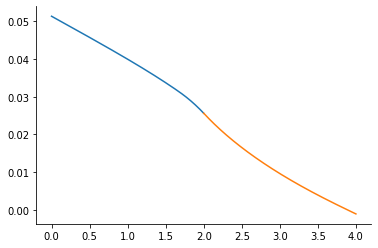

In [15]:
ϕ_bound = np.average(ϕ_list, axis=0, weights=πᵈ[:,-1])
plt.plot(y_grid[:numy_bar+1], ϕ)
plt.plot(y_grid[numy_bar:], ϕ_bound[numy_bar:])

In [39]:
yt, et, πᵈt, πᶜt, ιt, ht = simulate_jump(y_grid[:numy_bar+1], ems, πᶜ, πᵈ, ι, h, θ_list)

NameError: name 'ems' is not defined

(0.0, 10.538605808943974)

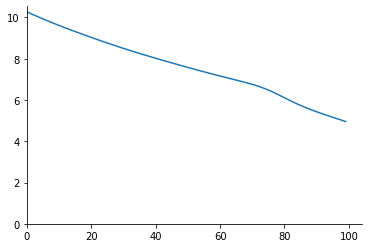

In [17]:
plt.plot(et[et>0])
plt.xlim(left=0)
plt.ylim(bottom=0)

In [91]:
ξₐ = 1/15_000
ξₘ = 0.002/η/10
ξ = 0.002
dmg_weight = np.array([0.475, 0.475, 0.05])
args = (δ, η, θ_list, γ1, γ2, γ3_list, dmg_weight, ς, ξₘ, ξₐ, ξ)
ϕ_avg, ems_avg, πᶜ_avg, ι_avg, πᵈ_avg, h_avg, ϕ_avg_list = solve_jump(y_grid, numy_bar, args, tol=3e-6)

episode: 1,	 ode error: 0.0017049711488100684,	 ft error: 0.0014433733128076528
episode: 2,	 ode error: 0.0014054245248626474,	 ft error: 0.0012754880675421994
episode: 3,	 ode error: 0.0013055882549496518,	 ft error: 0.001211747901989547
episode: 4,	 ode error: 0.0012388291908434286,	 ft error: 0.0011682626414294631
episode: 5,	 ode error: 0.0011873538699584383,	 ft error: 0.0011331590576324781
episode: 6,	 ode error: 0.0011454593854308285,	 ft error: 0.0011028833146214541
episode: 7,	 ode error: 0.0011102392010254977,	 ft error: 0.0010760623443626782
episode: 8,	 ode error: 0.001079996432309448,	 ft error: 0.0010518828400320867
episode: 9,	 ode error: 0.0010537810309676878,	 ft error: 0.0010301776224010187
episode: 10,	 ode error: 0.0010309035544245162,	 ft error: 0.0010104107882980618
episode: 11,	 ode error: 0.0010103383154710143,	 ft error: 0.0009924004703714285
episode: 12,	 ode error: 0.0009919608651092775,	 ft error: 0.0009758917915512685
episode: 13,	 ode error: 0.000974908467

episode: 105,	 ode error: 0.0004857967014038295,	 ft error: 0.0004844339312872389
episode: 106,	 ode error: 0.00048314118461390465,	 ft error: 0.00048245211416461886
episode: 107,	 ode error: 0.00048112004612650857,	 ft error: 0.00048008297892208435
episode: 108,	 ode error: 0.0004785269762224569,	 ft error: 0.000477007230989072
episode: 109,	 ode error: 0.00047577073434994395,	 ft error: 0.0004743816602572939
episode: 110,	 ode error: 0.000473109957781157,	 ft error: 0.0004718117200542179
episode: 111,	 ode error: 0.0004705474656842493,	 ft error: 0.00046991386509386696
episode: 112,	 ode error: 0.00046867453262806034,	 ft error: 0.000467582577253096
episode: 113,	 ode error: 0.00046618019580910706,	 ft error: 0.0004653851433297889
episode: 114,	 ode error: 0.00046373040017561333,	 ft error: 0.00046226471500180244
episode: 115,	 ode error: 0.00046113414591098596,	 ft error: 0.0004598010394142362
episode: 116,	 ode error: 0.0004585717761444324,	 ft error: 0.00045788419175117384
episode

episode: 218,	 ode error: 0.0002854909616008675,	 ft error: 0.00028472666659911755
episode: 219,	 ode error: 0.00028377529680445905,	 ft error: 0.00028349030691363075
episode: 220,	 ode error: 0.0002826604504894162,	 ft error: 0.00028201734304032777
episode: 221,	 ode error: 0.00028102890036814886,	 ft error: 0.0002805945012101611
episode: 222,	 ode error: 0.0002798436598977145,	 ft error: 0.0002790917648010094
episode: 223,	 ode error: 0.00027862618494668007,	 ft error: 0.0002776760608259182
episode: 224,	 ode error: 0.00027723711179793034,	 ft error: 0.00027631524580774836
episode: 225,	 ode error: 0.00027571101938864595,	 ft error: 0.00027514234199823206
episode: 226,	 ode error: 0.00027453862125636315,	 ft error: 0.00027425129530828096
episode: 227,	 ode error: 0.00027352046641642986,	 ft error: 0.0002736098039227373
episode: 228,	 ode error: 0.00027276239999889996,	 ft error: 0.0002729248518413182
episode: 229,	 ode error: 0.0002720712774380761,	 ft error: 0.0002722500385980246
ep

episode: 330,	 ode error: 0.00017917189644203562,	 ft error: 0.00017891189207898395
episode: 331,	 ode error: 0.0001784369151737313,	 ft error: 0.00017817117184140696
episode: 332,	 ode error: 0.00017768929332360214,	 ft error: 0.00017742090407055675
episode: 333,	 ode error: 0.0001769362871516403,	 ft error: 0.00017666891082579925
episode: 334,	 ode error: 0.00017618650070313384,	 ft error: 0.000175923672002809
episode: 335,	 ode error: 0.0001754482840778909,	 ft error: 0.0001751928207222725
episode: 336,	 ode error: 0.0001747282397507393,	 ft error: 0.00017448179960526575
episode: 337,	 ode error: 0.00017403007774010237,	 ft error: 0.00017379292047795908
episode: 338,	 ode error: 0.0001733540450916184,	 ft error: 0.0001731250142195338
episode: 339,	 ode error: 0.0001726970146044911,	 ft error: 0.0001724737585198875
episode: 340,	 ode error: 0.00017205320639715786,	 ft error: 0.00017183261557504142
episode: 341,	 ode error: 0.00017141537111980444,	 ft error: 0.00017119416691623962
epi

episode: 441,	 ode error: 0.00011663141044365472,	 ft error: 0.0001164674736630252
episode: 442,	 ode error: 0.00011619386136664739,	 ft error: 0.00011603042666998484
episode: 443,	 ode error: 0.0001157581053462687,	 ft error: 0.0001155951541683085
episode: 444,	 ode error: 0.00011532410265680242,	 ft error: 0.00011516162401347767
episode: 445,	 ode error: 0.00011489182944012682,	 ft error: 0.00011472982035395929
episode: 446,	 ode error: 0.00011446127841546554,	 ft error: 0.00011429974281440547
episode: 447,	 ode error: 0.00011403245645565303,	 ft error: 0.00011387140294775075
episode: 448,	 ode error: 0.00011360537988689312,	 ft error: 0.00011344481896826779
episode: 449,	 ode error: 0.00011318006867676658,	 ft error: 0.00011302000996103734
episode: 450,	 ode error: 0.00011275654072635387,	 ft error: 0.00011259699070625037
episode: 451,	 ode error: 0.00011233480730763281,	 ft error: 0.00011217576798979816
episode: 452,	 ode error: 0.00011191487033422902,	 ft error: 0.0001117563388852

episode: 557,	 ode error: 7.612379853598808e-05,	 ft error: 7.600246232128405e-05
episode: 558,	 ode error: 7.585025162589669e-05,	 ft error: 7.572917495394146e-05
episode: 559,	 ode error: 7.557779002881316e-05,	 ft error: 7.545697184310289e-05
episode: 560,	 ode error: 7.530640956590032e-05,	 ft error: 7.518584882887833e-05
episode: 561,	 ode error: 7.503610609200606e-05,	 ft error: 7.49158017833429e-05
episode: 562,	 ode error: 7.476687549318097e-05,	 ft error: 7.464682660875596e-05
episode: 563,	 ode error: 7.449871368463341e-05,	 ft error: 7.437891923529431e-05
episode: 564,	 ode error: 7.423161660847079e-05,	 ft error: 7.411207561938693e-05
episode: 565,	 ode error: 7.396558023280196e-05,	 ft error: 7.384629174195709e-05
episode: 566,	 ode error: 7.37006005492721e-05,	 ft error: 7.358156360761278e-05
episode: 567,	 ode error: 7.343667357322255e-05,	 ft error: 7.331788724305086e-05
episode: 568,	 ode error: 7.317379534157325e-05,	 ft error: 7.305525869684878e-05
episode: 569,	 ode

episode: 669,	 ode error: 5.133522529357027e-05,	 ft error: 5.1235753986689225e-05
episode: 670,	 ode error: 5.115858366107383e-05,	 ft error: 5.105922517734118e-05
episode: 671,	 ode error: 5.098258377006764e-05,	 ft error: 5.0883336880751716e-05
episode: 672,	 ode error: 5.080722232721853e-05,	 ft error: 5.070808582745279e-05
episode: 673,	 ode error: 5.0632496076747496e-05,	 ft error: 5.053346878491442e-05
episode: 674,	 ode error: 5.045840179957134e-05,	 ft error: 5.035948255835421e-05
episode: 675,	 ode error: 5.028493631413706e-05,	 ft error: 5.0186123989511465e-05
episode: 676,	 ode error: 5.011209647551925e-05,	 ft error: 5.00133899571098e-05
episode: 677,	 ode error: 4.9939879175503596e-05,	 ft error: 4.984127737620951e-05
episode: 678,	 ode error: 4.976828134213194e-05,	 ft error: 4.9669783198554494e-05
episode: 679,	 ode error: 4.959729993985265e-05,	 ft error: 4.949890441178588e-05
episode: 680,	 ode error: 4.942693196928374e-05,	 ft error: 4.932863803895626e-05
episode: 68

episode: 785,	 ode error: 3.4493308717531705e-05,	 ft error: 3.4402726464821676e-05
episode: 786,	 ode error: 3.437568308496599e-05,	 ft error: 3.428515811691735e-05
episode: 787,	 ode error: 3.425846436138811e-05,	 ft error: 3.4167996458903116e-05
episode: 788,	 ode error: 3.414165112292111e-05,	 ft error: 3.405124006858329e-05
episode: 789,	 ode error: 3.40252419517757e-05,	 ft error: 3.393488752794864e-05
episode: 790,	 ode error: 3.390923543377278e-05,	 ft error: 3.381893742368525e-05
episode: 791,	 ode error: 3.3793630159381226e-05,	 ft error: 3.370338834735957e-05
episode: 792,	 ode error: 3.367842472424252e-05,	 ft error: 3.358823889451634e-05
episode: 793,	 ode error: 3.356361772729609e-05,	 ft error: 3.347348766565006e-05
episode: 794,	 ode error: 3.344920777334341e-05,	 ft error: 3.335913326553419e-05
episode: 795,	 ode error: 3.333519347059361e-05,	 ft error: 3.324517430410012e-05
episode: 796,	 ode error: 3.3221573433195296e-05,	 ft error: 3.313160939576639e-05
episode: 797

episode: 899,	 ode error: 2.3393538183023237e-05,	 ft error: 2.3308257563331436e-05
episode: 900,	 ode error: 2.3314226330108274e-05,	 ft error: 2.3228982706582912e-05
episode: 901,	 ode error: 2.323518752885207e-05,	 ft error: 2.314998075979291e-05
episode: 902,	 ode error: 2.3156420827750773e-05,	 ft error: 2.3071250771615946e-05
episode: 903,	 ode error: 2.307792527815166e-05,	 ft error: 2.2992791794430405e-05
episode: 904,	 ode error: 2.299969993488349e-05,	 ft error: 2.291460288332085e-05
episode: 905,	 ode error: 2.292174385620869e-05,	 ft error: 2.2836683097280746e-05
episode: 906,	 ode error: 2.2844056103421767e-05,	 ft error: 2.2759031498241027e-05
episode: 907,	 ode error: 2.2766635741678395e-05,	 ft error: 2.26816471518565e-05
episode: 908,	 ode error: 2.2689481839014108e-05,	 ft error: 2.2604529126788824e-05
episode: 909,	 ode error: 2.2612593467039163e-05,	 ft error: 2.2527676495284754e-05
episode: 910,	 ode error: 2.2535969700708362e-05,	 ft error: 2.2451088332875457e-05


episode: 1013,	 ode error: 1.5902705901463948e-05,	 ft error: 1.5820848380023365e-05
episode: 1014,	 ode error: 1.5849127671093387e-05,	 ft error: 1.5767294041050633e-05
episode: 1015,	 ode error: 1.579573304527984e-05,	 ft error: 1.5713923214681163e-05
episode: 1016,	 ode error: 1.5742521386848205e-05,	 ft error: 1.566073526478029e-05
episode: 1017,	 ode error: 1.5689492061699267e-05,	 ft error: 1.560772955745693e-05
episode: 1018,	 ode error: 1.5636644437960322e-05,	 ft error: 1.5554905461156086e-05
episode: 1019,	 ode error: 1.5583977885899537e-05,	 ft error: 1.5502262346589468e-05
episode: 1020,	 ode error: 1.5531491778230278e-05,	 ft error: 1.544979958671237e-05
episode: 1021,	 ode error: 1.547918548983182e-05,	 ft error: 1.539751655681617e-05
episode: 1022,	 ode error: 1.5427058397703597e-05,	 ft error: 1.5345412634227656e-05
episode: 1023,	 ode error: 1.5375109881011497e-05,	 ft error: 1.529348719849407e-05
episode: 1024,	 ode error: 1.532333932125786e-05,	 ft error: 1.524173963

episode: 1128,	 ode error: 1.0801856883666514e-05,	 ft error: 1.0722224279719843e-05
episode: 1129,	 ode error: 1.0765720816207107e-05,	 ft error: 1.0686103562214852e-05
episode: 1130,	 ode error: 1.0729708003066668e-05,	 ft error: 1.0650106039983287e-05
episode: 1131,	 ode error: 1.0693818019082146e-05,	 ft error: 1.0614231288156677e-05
episode: 1132,	 ode error: 1.0658050440632985e-05,	 ft error: 1.0578478882976769e-05
episode: 1133,	 ode error: 1.0622404845232812e-05,	 ft error: 1.0542848402350646e-05
episode: 1134,	 ode error: 1.058688081176113e-05,	 ft error: 1.0507339425503786e-05
episode: 1135,	 ode error: 1.0551477920969212e-05,	 ft error: 1.0471951533141954e-05
episode: 1136,	 ode error: 1.0516195754634418e-05,	 ft error: 1.043668430710428e-05
episode: 1137,	 ode error: 1.0481033895797963e-05,	 ft error: 1.0401537331149643e-05
episode: 1138,	 ode error: 1.044599192942346e-05,	 ft error: 1.0366510189823338e-05
episode: 1139,	 ode error: 1.0411069441102058e-05,	 ft error: 1.0331

episode: 1240,	 ode error: 7.432351810918105e-06,	 ft error: 7.354117527169635e-06
episode: 1241,	 ode error: 7.407683752759021e-06,	 ft error: 7.329459425498008e-06
episode: 1242,	 ode error: 7.383099440764888e-06,	 ft error: 7.3048850314968074e-06
episode: 1243,	 ode error: 7.358598586806701e-06,	 ft error: 7.280394057271322e-06
episode: 1244,	 ode error: 7.3341809042016745e-06,	 ft error: 7.255986216152718e-06
episode: 1245,	 ode error: 7.309846106794593e-06,	 ft error: 7.231661222582379e-06
episode: 1246,	 ode error: 7.2855939103493896e-06,	 ft error: 7.207418791926878e-06
episode: 1247,	 ode error: 7.261424030591073e-06,	 ft error: 7.183258640593623e-06
episode: 1248,	 ode error: 7.237336185284362e-06,	 ft error: 7.159180485892073e-06
episode: 1249,	 ode error: 7.213330092278002e-06,	 ft error: 7.1351840466119904e-06
episode: 1250,	 ode error: 7.189405471518776e-06,	 ft error: 7.111269042028856e-06
episode: 1251,	 ode error: 7.165562042826617e-06,	 ft error: 7.087435192736543e-06


episode: 1352,	 ode error: 5.130273427283419e-06,	 ft error: 5.052945614286708e-06
episode: 1353,	 ode error: 5.1134038065852325e-06,	 ft error: 5.036082442617477e-06
episode: 1354,	 ode error: 5.096591189508596e-06,	 ft error: 5.019276249444242e-06
episode: 1355,	 ode error: 5.0798353808329325e-06,	 ft error: 5.002526839830343e-06
episode: 1356,	 ode error: 5.063136186121979e-06,	 ft error: 4.985834019232324e-06
episode: 1357,	 ode error: 5.0464934117387455e-06,	 ft error: 4.969197593962527e-06
episode: 1358,	 ode error: 5.029906863997452e-06,	 ft error: 4.952617370819016e-06
episode: 1359,	 ode error: 5.013376350514339e-06,	 ft error: 4.936093157178098e-06
episode: 1360,	 ode error: 4.99690167908302e-06,	 ft error: 4.919624760971186e-06
episode: 1361,	 ode error: 4.980482658220055e-06,	 ft error: 4.903211991170535e-06
episode: 1362,	 ode error: 4.9641190975116805e-06,	 ft error: 4.886854657141597e-06
episode: 1363,	 ode error: 4.947810806877413e-06,	 ft error: 4.870552569128754e-06
e

episode: 1468,	 ode error: 3.5086599092212832e-06,	 ft error: 3.43193541916161e-06
episode: 1469,	 ode error: 3.49725742090684e-06,	 ft error: 3.420537037085447e-06
episode: 1470,	 ode error: 3.485893272936317e-06,	 ft error: 3.4091769797924463e-06
episode: 1471,	 ode error: 3.4745673351371494e-06,	 ft error: 3.39785511692392e-06
episode: 1472,	 ode error: 3.4632794777994004e-06,	 ft error: 3.3865713187688127e-06
episode: 1473,	 ode error: 3.452029571360477e-06,	 ft error: 3.3753254561943078e-06
episode: 1474,	 ode error: 3.4408174874203754e-06,	 ft error: 3.3641174005070535e-06
episode: 1475,	 ode error: 3.4296430975935127e-06,	 ft error: 3.3529470233837717e-06
episode: 1476,	 ode error: 3.4185062737579833e-06,	 ft error: 3.341814196917518e-06
episode: 1477,	 ode error: 3.4074068887211513e-06,	 ft error: 3.3307187936639413e-06
episode: 1478,	 ode error: 3.3963448152250037e-06,	 ft error: 3.3196606866644127e-06
episode: 1479,	 ode error: 3.3853199267651563e-06,	 ft error: 3.30863974914

episode: 59,	 ode error: 0.0006362752361045831,	 ft error: 0.000633666035314053
episode: 60,	 ode error: 0.0006320791039853842,	 ft error: 0.0006295203298110029
episode: 61,	 ode error: 0.0006279402596332513,	 ft error: 0.0006254292447288359
episode: 62,	 ode error: 0.0006238562160119524,	 ft error: 0.000621325912500322
episode: 63,	 ode error: 0.0006198280486476649,	 ft error: 0.000617340425354956
episode: 64,	 ode error: 0.0006158632564548116,	 ft error: 0.0006134319114729492
episode: 65,	 ode error: 0.0006119260072621371,	 ft error: 0.0006095580071185588
episode: 66,	 ode error: 0.0006080798629629812,	 ft error: 0.000605702239180432
episode: 67,	 ode error: 0.0006042379414564379,	 ft error: 0.000601905692498711
episode: 68,	 ode error: 0.000600461435835488,	 ft error: 0.0005982829754206642
episode: 69,	 ode error: 0.0005967437790448456,	 ft error: 0.0005944975645134331
episode: 70,	 ode error: 0.0005930504088049878,	 ft error: 0.0005908468536360591
episode: 71,	 ode error: 0.0005894

episode: 165,	 ode error: 0.0003586944848696247,	 ft error: 0.00035780750542386647
episode: 166,	 ode error: 0.00035685724325177097,	 ft error: 0.00035597139042536224
episode: 167,	 ode error: 0.00035502419059668525,	 ft error: 0.0003541393843220844
episode: 168,	 ode error: 0.00035319523985385905,	 ft error: 0.0003523114119441858
episode: 169,	 ode error: 0.00035137031775100806,	 ft error: 0.0003504874116218651
episode: 170,	 ode error: 0.0003495493644911033,	 ft error: 0.00034866733484332596
episode: 171,	 ode error: 0.0003477323333926488,	 ft error: 0.00034685114585239024
episode: 172,	 ode error: 0.0003459191904793265,	 ft error: 0.00034503882119975987
episode: 173,	 ode error: 0.0003441099140233518,	 ft error: 0.0003432303492609141
episode: 174,	 ode error: 0.00034230449404871533,	 ft error: 0.00034142572970730783
episode: 175,	 ode error: 0.0003405029317993082,	 ft error: 0.0003396249729519426
episode: 176,	 ode error: 0.00033870523917798006,	 ft error: 0.00033782809957213133
epi

episode: 275,	 ode error: 0.00019094215675482054,	 ft error: 0.00019038267723680188
episode: 276,	 ode error: 0.00018980286763096196,	 ft error: 0.00018925195434641348
episode: 277,	 ode error: 0.00018867082213341099,	 ft error: 0.00018812600579456534
episode: 278,	 ode error: 0.00018754576741350103,	 ft error: 0.00018700727877546397
episode: 279,	 ode error: 0.0001864275309279539,	 ft error: 0.0001858948496785695
episode: 280,	 ode error: 0.00018531601894076067,	 ft error: 0.00018478883655139816
episode: 281,	 ode error: 0.00018421117850101962,	 ft error: 0.00018368938552155065
episode: 282,	 ode error: 0.00018311297276902238,	 ft error: 0.0001825965374718334
episode: 283,	 ode error: 0.00018202136937061904,	 ft error: 0.00018151027906733452
episode: 284,	 ode error: 0.00018093633625317974,	 ft error: 0.00018043057822198413
episode: 285,	 ode error: 0.00017985784069373832,	 ft error: 0.0001793573969058789
episode: 286,	 ode error: 0.00017878584934023756,	 ft error: 0.00017829069623722

episode: 387,	 ode error: 9.812712971742424e-05,	 ft error: 9.787275933685151e-05
episode: 388,	 ode error: 9.755506389503275e-05,	 ft error: 9.730333261207444e-05
episode: 389,	 ode error: 9.698728967148622e-05,	 ft error: 9.673777634701397e-05
episode: 390,	 ode error: 9.64233830134983e-05,	 ft error: 9.617582769387105e-05
episode: 391,	 ode error: 9.586307145715233e-05,	 ft error: 9.56173187906482e-05
episode: 392,	 ode error: 9.530618468908344e-05,	 ft error: 9.506214128885324e-05
episode: 393,	 ode error: 9.475261558623989e-05,	 ft error: 9.451022378819304e-05
episode: 394,	 ode error: 9.420229455548627e-05,	 ft error: 9.396151713104521e-05
episode: 395,	 ode error: 9.365517386097401e-05,	 ft error: 9.341598524508407e-05
episode: 396,	 ode error: 9.311121839537329e-05,	 ft error: 9.287359967735202e-05
episode: 397,	 ode error: 9.257040034226904e-05,	 ft error: 9.233433641374819e-05
episode: 398,	 ode error: 9.203269611313776e-05,	 ft error: 9.179817405153187e-05
episode: 399,	 ode

episode: 498,	 ode error: 5.1486259973375944e-05,	 ft error: 5.119164282849087e-05
episode: 499,	 ode error: 5.118476449930622e-05,	 ft error: 5.0891190314303336e-05
episode: 500,	 ode error: 5.088492380817043e-05,	 ft error: 5.059238590207164e-05
episode: 501,	 ode error: 5.058672945105981e-05,	 ft error: 5.029522119076128e-05
episode: 502,	 ode error: 5.029017301368382e-05,	 ft error: 4.9999687813060786e-05
episode: 503,	 ode error: 4.9995246116111484e-05,	 ft error: 4.9705777435358575e-05
episode: 504,	 ode error: 4.970194041220891e-05,	 ft error: 4.941348175697968e-05
episode: 505,	 ode error: 4.941024758918836e-05,	 ft error: 4.9122792510185774e-05
episode: 506,	 ode error: 4.9120159367368414e-05,	 ft error: 4.8833701458856724e-05
episode: 507,	 ode error: 4.88316674995392e-05,	 ft error: 4.854620039936956e-05
episode: 508,	 ode error: 4.8544763770640674e-05,	 ft error: 4.826028115914131e-05
episode: 509,	 ode error: 4.825943999746136e-05,	 ft error: 4.797593559676776e-05
episode:

episode: 609,	 ode error: 2.7949592950906433e-05,	 ft error: 2.8900129729510227e-05
episode: 610,	 ode error: 2.787678999272532e-05,	 ft error: 2.88262408672015e-05
episode: 611,	 ode error: 2.780416115995903e-05,	 ft error: 2.875253415440815e-05
episode: 612,	 ode error: 2.77317060732401e-05,	 ft error: 2.8679009133174747e-05
episode: 613,	 ode error: 2.7659424353942936e-05,	 ft error: 2.860566534874931e-05
episode: 614,	 ode error: 2.7587315624184264e-05,	 ft error: 2.8532502346830895e-05
episode: 615,	 ode error: 2.7515379506826094e-05,	 ft error: 2.8459519673650534e-05
episode: 616,	 ode error: 2.7443615625467773e-05,	 ft error: 2.8386716877902562e-05
episode: 617,	 ode error: 2.7372023604447127e-05,	 ft error: 2.8314093510108572e-05
episode: 618,	 ode error: 2.7300603068841758e-05,	 ft error: 2.8241649120639794e-05
episode: 619,	 ode error: 2.7229353644459128e-05,	 ft error: 2.8169383263545088e-05
episode: 620,	 ode error: 2.715827495784222e-05,	 ft error: 2.80972954924801e-05
epi

episode: 715,	 ode error: 2.1057037247731373e-05,	 ft error: 2.2481378320615697e-05
episode: 716,	 ode error: 2.0999466186199866e-05,	 ft error: 2.242285627181151e-05
episode: 717,	 ode error: 2.0942036985414762e-05,	 ft error: 2.2364480268174024e-05
episode: 718,	 ode error: 2.0884749324175285e-05,	 ft error: 2.230624994153709e-05
episode: 719,	 ode error: 2.082760288196509e-05,	 ft error: 2.224816491899299e-05
episode: 720,	 ode error: 2.0770597338945972e-05,	 ft error: 2.2190224831485084e-05
episode: 721,	 ode error: 2.0713732375956596e-05,	 ft error: 2.2132429307250567e-05
episode: 722,	 ode error: 2.0657007674510457e-05,	 ft error: 2.207477798010088e-05
episode: 723,	 ode error: 2.0600422916800632e-05,	 ft error: 2.2017270481395717e-05
episode: 724,	 ode error: 2.0543977785684677e-05,	 ft error: 2.1959906447872417e-05
episode: 725,	 ode error: 2.0487671964693275e-05,	 ft error: 2.1902685516395536e-05
episode: 726,	 ode error: 2.043150513801202e-05,	 ft error: 2.1845607328871884e-0

episode: 829,	 ode error: 1.5333974769851666e-05,	 ft error: 1.6680476683262706e-05
episode: 830,	 ode error: 1.5290627672335708e-05,	 ft error: 1.663682981717605e-05
episode: 831,	 ode error: 1.524738886522775e-05,	 ft error: 1.6593298042740883e-05
episode: 832,	 ode error: 1.5204258082987922e-05,	 ft error: 1.6549880959293904e-05
episode: 833,	 ode error: 1.5161235060974347e-05,	 ft error: 1.650657816072478e-05
episode: 834,	 ode error: 1.5118319535445494e-05,	 ft error: 1.646338923820545e-05
episode: 835,	 ode error: 1.5075511243577068e-05,	 ft error: 1.642031377770368e-05
episode: 836,	 ode error: 1.5032809923464424e-05,	 ft error: 1.6377351363244346e-05
episode: 837,	 ode error: 1.4990215314151183e-05,	 ft error: 1.6334501572676706e-05
episode: 838,	 ode error: 1.4947727155605034e-05,	 ft error: 1.6291763985156842e-05
episode: 839,	 ode error: 1.4905345188756899e-05,	 ft error: 1.6249138173884958e-05
episode: 840,	 ode error: 1.4863069155488055e-05,	 ft error: 1.6206623711459887e-

KeyboardInterrupt: 

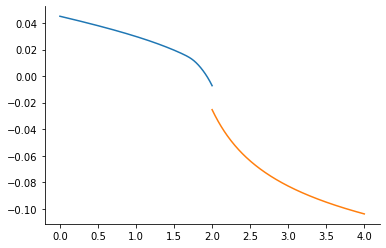

In [96]:
ϕ_bound = np.average(ϕ_avg_list, axis=0, weights=πᵈ_avg[:,-1])
plt.plot(y_grid[:numy_bar+1], ϕ_avg)
plt.plot(y_grid[numy_bar:], ϕ_bound[numy_bar:])

In [97]:
yt_avg, et_avg, πᵈt_avg, πᶜt_avg, ιt_avg, ht_avg = simulate_jump(y_grid[:numy_bar+1], ems_avg, πᶜ_avg, πᵈ_avg, ι_avg, h_avg, θ_list)

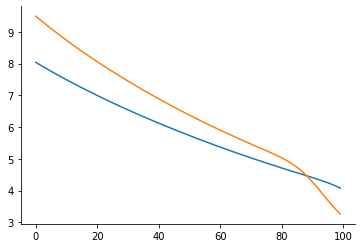

In [98]:
plt.plot(et_avg)
plt.plot(et[et>0])

(0.0, 100.0)

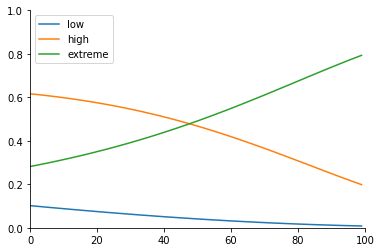

In [99]:
plt.plot(πᵈt_avg[:,0],label='low')
plt.plot(πᵈt_avg[:,1], label="high")
plt.plot(πᵈt_avg[:,2], label="extreme")
plt.legend()
plt.ylim(0,1)
plt.xlim(0,100)

In [100]:
πᵈt_avg[0,2]

0.2817533876076594

# partition: carbon and temp

In [71]:
ξₐ = 1/15_000
ξₘ = 0.002/η/10
dmg_weight = np.array([0.475, 0.475, 0.05])
args = (δ, η, θtemp_list, γ1, γ2, γ3_list, dmg_weight, ς, ξₘ, ξₐ, ξ)
ϕ_temp, ems_temp, πᶜ_temp, ι_temp, πᵈ_temp, h_temp, ϕ_temp_list = solve_jump(y_grid, numy_bar, args, tol=2e-6)

episode: 1,	 ode error: 0.0017021411232569473,	 ft error: 0.0014383713363495634
episode: 2,	 ode error: 0.0014158686615702877,	 ft error: 0.001287653186884599
episode: 3,	 ode error: 0.0013096579044613093,	 ft error: 0.0012207845458497336
episode: 4,	 ode error: 0.0012432903514678368,	 ft error: 0.001176078741066634
episode: 5,	 ode error: 0.0011933232164357572,	 ft error: 0.0011409228034786562
episode: 6,	 ode error: 0.00115206753531346,	 ft error: 0.0011106154925161205
episode: 7,	 ode error: 0.001117693700571011,	 ft error: 0.0010839129216590137
episode: 8,	 ode error: 0.0010880589882688047,	 ft error: 0.0010600729415743524
episode: 9,	 ode error: 0.001062260310276432,	 ft error: 0.0010384883552145932
episode: 10,	 ode error: 0.0010394967294529553,	 ft error: 0.0010188816606710343
episode: 11,	 ode error: 0.001018893889510848,	 ft error: 0.0010008815985565293
episode: 12,	 ode error: 0.001000397948536954,	 ft error: 0.0009844212686748507
episode: 13,	 ode error: 0.000983113374607831

episode: 190,	 ode error: 0.0003281302309381662,	 ft error: 0.0003267420205538737
episode: 191,	 ode error: 0.00032555293567496525,	 ft error: 0.00032479223453947087
episode: 192,	 ode error: 0.00032389445218346214,	 ft error: 0.00032331492109465476
episode: 193,	 ode error: 0.00032248557835662644,	 ft error: 0.00032195690996943604
episode: 194,	 ode error: 0.00032113720949291356,	 ft error: 0.00032274927312767043
episode: 195,	 ode error: 0.0003210851845020826,	 ft error: 0.00032009031727652426
episode: 196,	 ode error: 0.0003191218571216433,	 ft error: 0.00031938187861543327
episode: 197,	 ode error: 0.00031839347659786657,	 ft error: 0.00031766344179705774
episode: 198,	 ode error: 0.0003167105995403093,	 ft error: 0.0003163551515041052
episode: 199,	 ode error: 0.0003154543495751662,	 ft error: 0.0003149360440724003
episode: 200,	 ode error: 0.00031370271799108934,	 ft error: 0.00031342351356385134
episode: 201,	 ode error: 0.0003134578808185323,	 ft error: 0.0003118108139099398
ep

episode: 294,	 ode error: 0.00021024012843582967,	 ft error: 0.00020949722297244439
episode: 295,	 ode error: 0.00020924317400326266,	 ft error: 0.00020877318832819108
episode: 296,	 ode error: 0.00020828527491255442,	 ft error: 0.00020804662924365133
episode: 297,	 ode error: 0.00020757158923940579,	 ft error: 0.00021048733203010245
episode: 298,	 ode error: 0.00020848936838004778,	 ft error: 0.00020763463482511663
episode: 299,	 ode error: 0.00020691550490867282,	 ft error: 0.0002077019204664114
episode: 300,	 ode error: 0.00020679341116832024,	 ft error: 0.00020627500483145583
episode: 301,	 ode error: 0.0002056219632819644,	 ft error: 0.00020543361652629322
episode: 302,	 ode error: 0.0002048965272017834,	 ft error: 0.00020448769184088408
episode: 303,	 ode error: 0.0002037484656113688,	 ft error: 0.00020348067025529698
episode: 304,	 ode error: 0.0002029195386920663,	 ft error: 0.000202421591210325
episode: 305,	 ode error: 0.00020237074500406376,	 ft error: 0.00020133895825884263

episode: 399,	 ode error: 0.00014002733232394097,	 ft error: 0.00013870708091529016
episode: 400,	 ode error: 0.00013992401239268175,	 ft error: 0.0001401103573644517
episode: 401,	 ode error: 0.0001388272867881901,	 ft error: 0.00013762228652840214
episode: 402,	 ode error: 0.00013862861523136652,	 ft error: 0.00013786286534651915
episode: 403,	 ode error: 0.00013783326745412446,	 ft error: 0.0001365616911167683
episode: 404,	 ode error: 0.00013746466839495918,	 ft error: 0.0001363447466769252
episode: 405,	 ode error: 0.0001368197243979566,	 ft error: 0.00013553451014856888
episode: 406,	 ode error: 0.00013636498299965112,	 ft error: 0.00013513225475041135
episode: 407,	 ode error: 0.00013577414356088797,	 ft error: 0.00013452713507585795
episode: 408,	 ode error: 0.00013525709394478377,	 ft error: 0.00013408407782305085
episode: 409,	 ode error: 0.00013466287594471479,	 ft error: 0.00013355141567685433
episode: 410,	 ode error: 0.0001340850683469011,	 ft error: 0.0001331607581736329

episode: 503,	 ode error: 9.471551157431751e-05,	 ft error: 9.4546800449453e-05
episode: 504,	 ode error: 9.437259000279056e-05,	 ft error: 9.420344394541388e-05
episode: 505,	 ode error: 9.402961780158661e-05,	 ft error: 9.386018655466177e-05
episode: 506,	 ode error: 9.368663569430736e-05,	 ft error: 9.351707891779952e-05
episode: 507,	 ode error: 9.334373457704889e-05,	 ft error: 9.317421538120967e-05
episode: 508,	 ode error: 9.300104680236038e-05,	 ft error: 9.283172537048283e-05
episode: 509,	 ode error: 9.26587356941392e-05,	 ft error: 9.248976340049213e-05
episode: 510,	 ode error: 9.231698411265319e-05,	 ft error: 9.214849849346433e-05
episode: 511,	 ode error: 9.197598287809846e-05,	 ft error: 9.180810372104906e-05
episode: 512,	 ode error: 9.16359197655368e-05,	 ft error: 9.146874648993664e-05
episode: 513,	 ode error: 9.129696967455402e-05,	 ft error: 9.113058006484284e-05
episode: 514,	 ode error: 9.095928642520077e-05,	 ft error: 9.079373668202662e-05
episode: 515,	 ode e

episode: 609,	 ode error: 6.470981824542967e-05,	 ft error: 6.457647107806219e-05
episode: 610,	 ode error: 6.448375569687687e-05,	 ft error: 6.435038140876112e-05
episode: 611,	 ode error: 6.425809294261918e-05,	 ft error: 6.412475474511237e-05
episode: 612,	 ode error: 6.403285101889045e-05,	 ft error: 6.389961112377349e-05
episode: 613,	 ode error: 6.380805704208302e-05,	 ft error: 6.367497575892704e-05
episode: 614,	 ode error: 6.358374344368615e-05,	 ft error: 6.345087834006466e-05
episode: 615,	 ode error: 6.335994714288585e-05,	 ft error: 6.322735227668834e-05
episode: 616,	 ode error: 6.313670866053768e-05,	 ft error: 6.300443389409272e-05
episode: 617,	 ode error: 6.291407118359609e-05,	 ft error: 6.278216159246361e-05
episode: 618,	 ode error: 6.269207959511971e-05,	 ft error: 6.256057497701825e-05
episode: 619,	 ode error: 6.24707794811744e-05,	 ft error: 6.233971397954138e-05
episode: 620,	 ode error: 6.225021614074866e-05,	 ft error: 6.211961798547236e-05
episode: 621,	 od

episode: 715,	 ode error: 4.483335313452128e-05,	 ft error: 4.4723330573671435e-05
episode: 716,	 ode error: 4.468053201711641e-05,	 ft error: 4.457059161667998e-05
episode: 717,	 ode error: 4.452825852104946e-05,	 ft error: 4.4418396279698645e-05
episode: 718,	 ode error: 4.437652381818582e-05,	 ft error: 4.4266736640060277e-05
episode: 719,	 ode error: 4.422531946383901e-05,	 ft error: 4.41156051457503e-05
episode: 720,	 ode error: 4.407463750717266e-05,	 ft error: 4.3964994707023274e-05
episode: 721,	 ode error: 4.3924470584913574e-05,	 ft error: 4.381489877247624e-05
episode: 722,	 ode error: 4.377481199560498e-05,	 ft error: 4.3665311389324654e-05
episode: 723,	 ode error: 4.362565575829862e-05,	 ft error: 4.351622725091061e-05
episode: 724,	 ode error: 4.347699665679884e-05,	 ft error: 4.336764173005585e-05
episode: 725,	 ode error: 4.332883026955626e-05,	 ft error: 4.3219550901543724e-05
episode: 726,	 ode error: 4.3181152984917586e-05,	 ft error: 4.307195155333714e-05
episode: 

episode: 820,	 ode error: 3.135314004968368e-05,	 ft error: 3.1250151125405044e-05
episode: 821,	 ode error: 3.124689518220719e-05,	 ft error: 3.1143948546382326e-05
episode: 822,	 ode error: 3.114101391576399e-05,	 ft error: 3.103810929496835e-05
episode: 823,	 ode error: 3.103549461755341e-05,	 ft error: 3.0932631890750094e-05
episode: 824,	 ode error: 3.093033603727947e-05,	 ft error: 3.082751518073783e-05
episode: 825,	 ode error: 3.082553722891278e-05,	 ft error: 3.072275826567402e-05
episode: 826,	 ode error: 3.0721097459940555e-05,	 ft error: 3.061836041623467e-05
episode: 827,	 ode error: 3.06170161154546e-05,	 ft error: 3.0514320986570663e-05
episode: 828,	 ode error: 3.0513292602953935e-05,	 ft error: 3.0410639330994787e-05
episode: 829,	 ode error: 3.0409926267075966e-05,	 ft error: 3.0307314728023987e-05
episode: 830,	 ode error: 3.030691631428933e-05,	 ft error: 3.0204346317929308e-05
episode: 831,	 ode error: 3.0204261757142475e-05,	 ft error: 3.010173305599088e-05
episod

episode: 926,	 ode error: 2.189532601555371e-05,	 ft error: 2.1796715653892483e-05
episode: 927,	 ode error: 2.1821478220889097e-05,	 ft error: 2.1722907635422322e-05
episode: 928,	 ode error: 2.1747891298300377e-05,	 ft error: 2.164935940946374e-05
episode: 929,	 ode error: 2.1674564230512636e-05,	 ft error: 2.1576069923849122e-05
episode: 930,	 ode error: 2.1601495816836696e-05,	 ft error: 2.1503037971002763e-05
episode: 931,	 ode error: 2.1528684699682193e-05,	 ft error: 2.143026221236577e-05
episode: 932,	 ode error: 2.1456129395139127e-05,	 ft error: 2.135774120531897e-05
episode: 933,	 ode error: 2.1383828323306032e-05,	 ft error: 2.12854734323494e-05
episode: 934,	 ode error: 2.1311779843109454e-05,	 ft error: 2.1213457330239903e-05
episode: 935,	 ode error: 2.1239982281841632e-05,	 ft error: 2.114169131662199e-05
episode: 936,	 ode error: 2.1168433964146964e-05,	 ft error: 2.1070173814955833e-05
episode: 937,	 ode error: 2.109713323767174e-05,	 ft error: 2.0998903275370094e-05


episode: 1033,	 ode error: 1.5272749147739813e-05,	 ft error: 1.5177093685333118e-05
episode: 1034,	 ode error: 1.5221577786087904e-05,	 ft error: 1.5125945836807117e-05
episode: 1035,	 ode error: 1.5170578950310333e-05,	 ft error: 1.5074970751705052e-05
episode: 1036,	 ode error: 1.511975225483369e-05,	 ft error: 1.502416802225126e-05
episode: 1037,	 ode error: 1.506909733066115e-05,	 ft error: 1.4973537253784586e-05
episode: 1038,	 ode error: 1.5018613820512862e-05,	 ft error: 1.4923078061959694e-05
episode: 1039,	 ode error: 1.4968301375722633e-05,	 ft error: 1.4872790068676256e-05
episode: 1040,	 ode error: 1.4918159651054579e-05,	 ft error: 1.482267289805439e-05
episode: 1041,	 ode error: 1.486818830023686e-05,	 ft error: 1.4772726172178804e-05
episode: 1042,	 ode error: 1.481838697104461e-05,	 ft error: 1.472294950702798e-05
episode: 1043,	 ode error: 1.476875530132839e-05,	 ft error: 1.467334250863465e-05
episode: 1044,	 ode error: 1.4719292915499425e-05,	 ft error: 1.4623904770

episode: 1139,	 ode error: 1.0714417283198439e-05,	 ft error: 1.0620728544269431e-05
episode: 1140,	 ode error: 1.0678779472510702e-05,	 ft error: 1.0585104180278287e-05
episode: 1141,	 ode error: 1.0643259895211647e-05,	 ft error: 1.0549598318647843e-05
episode: 1142,	 ode error: 1.0607857999787363e-05,	 ft error: 1.0514210440395097e-05
episode: 1143,	 ode error: 1.0572573297279691e-05,	 ft error: 1.0478940081770638e-05
episode: 1144,	 ode error: 1.0537405361385759e-05,	 ft error: 1.0443786834628729e-05
episode: 1145,	 ode error: 1.0502353827361957e-05,	 ft error: 1.0408750344091205e-05
episode: 1146,	 ode error: 1.046741838748764e-05,	 ft error: 1.037383030498551e-05
episode: 1147,	 ode error: 1.0432598786317294e-05,	 ft error: 1.0339026456108551e-05
episode: 1148,	 ode error: 1.0397894812380214e-05,	 ft error: 1.0304338573958554e-05
episode: 1149,	 ode error: 1.0363306291475143e-05,	 ft error: 1.0269766465495489e-05
episode: 1150,	 ode error: 1.0328833076760665e-05,	 ft error: 1.023

episode: 1246,	 ode error: 7.511182628612946e-06,	 ft error: 7.41882810196178e-06
episode: 1247,	 ode error: 7.486360543905077e-06,	 ft error: 7.394020746440133e-06
episode: 1248,	 ode error: 7.461625360007324e-06,	 ft error: 7.369299983225885e-06
episode: 1249,	 ode error: 7.4369772103710955e-06,	 ft error: 7.34466587291871e-06
episode: 1250,	 ode error: 7.412416152177107e-06,	 ft error: 7.320118407862694e-06
episode: 1251,	 ode error: 7.3879421615311676e-06,	 ft error: 7.295657510018409e-06
episode: 1252,	 ode error: 7.363555132614496e-06,	 ft error: 7.2712830292744526e-06
episode: 1253,	 ode error: 7.339254876027163e-06,	 ft error: 7.2469947433780515e-06
episode: 1254,	 ode error: 7.315041119868395e-06,	 ft error: 7.222792358235752e-06
episode: 1255,	 ode error: 7.290913510337653e-06,	 ft error: 7.1986755098100525e-06
episode: 1256,	 ode error: 7.266871615204296e-06,	 ft error: 7.174643766177935e-06
episode: 1257,	 ode error: 7.242914926211693e-06,	 ft error: 7.150696631115968e-06
e

episode: 1353,	 ode error: 5.281523200981989e-06,	 ft error: 5.190127585023389e-06
episode: 1354,	 ode error: 5.264294185195785e-06,	 ft error: 5.17290144603592e-06
episode: 1355,	 ode error: 5.247127358048043e-06,	 ft error: 5.155736816595906e-06
episode: 1356,	 ode error: 5.230022063853297e-06,	 ft error: 5.138633083212607e-06
episode: 1357,	 ode error: 5.212977568464752e-06,	 ft error: 5.121589566337015e-06
episode: 1358,	 ode error: 5.1959930677460305e-06,	 ft error: 5.104605527046317e-06
episode: 1359,	 ode error: 5.1790676953428335e-06,	 ft error: 5.087680174977368e-06
episode: 1360,	 ode error: 5.1622005337540605e-06,	 ft error: 5.070812677647937e-06
episode: 1361,	 ode error: 5.145390625896991e-06,	 ft error: 5.0540021716051955e-06
episode: 1362,	 ode error: 5.128636989236825e-06,	 ft error: 5.037247773458561e-06
episode: 1363,	 ode error: 5.1119386294384145e-06,	 ft error: 5.020548593850002e-06
episode: 1364,	 ode error: 5.095294557394634e-06,	 ft error: 5.003903750753584e-06


episode: 1459,	 ode error: 3.7399468525408167e-06,	 ft error: 3.6491042001059646e-06
episode: 1460,	 ode error: 3.7278656585654733e-06,	 ft error: 3.6370276425510646e-06
episode: 1461,	 ode error: 3.7158283300176963e-06,	 ft error: 3.624994507067658e-06
episode: 1462,	 ode error: 3.703834537084486e-06,	 ft error: 3.6130044598255604e-06
episode: 1463,	 ode error: 3.6918838119002952e-06,	 ft error: 3.601057046211572e-06
episode: 1464,	 ode error: 3.6799755592239287e-06,	 ft error: 3.5891517019317107e-06
episode: 1465,	 ode error: 3.668109073795751e-06,	 ft error: 3.577287769641428e-06
episode: 1466,	 ode error: 3.6562835634774884e-06,	 ft error: 3.5654645198085477e-06
episode: 1467,	 ode error: 3.6444981759032203e-06,	 ft error: 3.553681176549084e-06
episode: 1468,	 ode error: 3.6327520312036355e-06,	 ft error: 3.541936944943351e-06
episode: 1469,	 ode error: 3.621044252572511e-06,	 ft error: 3.5302310407806887e-06
episode: 1470,	 ode error: 3.6093740008733607e-06,	 ft error: 3.518562718

episode: 1565,	 ode error: 2.6602400179169235e-06,	 ft error: 2.5697528007832355e-06
episode: 1566,	 ode error: 2.6517815648741247e-06,	 ft error: 2.5612951591128903e-06
episode: 1567,	 ode error: 2.6433508650881583e-06,	 ft error: 2.552865255670926e-06
episode: 1568,	 ode error: 2.634947417780786e-06,	 ft error: 2.5444626390360345e-06
episode: 1569,	 ode error: 2.6265707136633246e-06,	 ft error: 2.5360868527677756e-06
episode: 1570,	 ode error: 2.6182202481451556e-06,	 ft error: 2.5277374459536928e-06
episode: 1571,	 ode error: 2.6098955343276716e-06,	 ft error: 2.519413986231308e-06
episode: 1572,	 ode error: 2.6015961179376434e-06,	 ft error: 2.511116072463164e-06
episode: 1573,	 ode error: 2.5933215929613068e-06,	 ft error: 2.502843347504391e-06
episode: 1574,	 ode error: 2.5850716138152907e-06,	 ft error: 2.4945955109934026e-06
episode: 1575,	 ode error: 2.57684591009979e-06,	 ft error: 2.4863723297139746e-06
episode: 1576,	 ode error: 2.5686442957226696e-06,	 ft error: 2.47817364

episode: 106,	 ode error: 0.000489720661285072,	 ft error: 0.0004883970540272657
episode: 107,	 ode error: 0.0004871473977826823,	 ft error: 0.0004858391749067275
episode: 108,	 ode error: 0.0004845952102912898,	 ft error: 0.00048330187801812663
episode: 109,	 ode error: 0.00048206382479882106,	 ft error: 0.0004807850908000964
episode: 110,	 ode error: 0.00047955295929524074,	 ft error: 0.0004782885726757266
episode: 111,	 ode error: 0.00047706231624787456,	 ft error: 0.000475812010390086
episode: 112,	 ode error: 0.0004745915900594141,	 ft error: 0.00047335508656206476
episode: 113,	 ode error: 0.00047214074736082244,	 ft error: 0.0004708260177878921
episode: 114,	 ode error: 0.00046971128378500574,	 ft error: 0.0004684086327529554
episode: 115,	 ode error: 0.0004673020774209113,	 ft error: 0.00046601362422940323
episode: 116,	 ode error: 0.00046491304293970665,	 ft error: 0.00046364179299007485
episode: 117,	 ode error: 0.0004625433504640359,	 ft error: 0.0004612891514778802
episode:

episode: 300,	 ode error: 0.00016804856154348908,	 ft error: 0.00016762790762856844
episode: 301,	 ode error: 0.0001670586858968701,	 ft error: 0.0001666430296929968
episode: 302,	 ode error: 0.00016607478397041983,	 ft error: 0.00016566410381455937
episode: 303,	 ode error: 0.00016509682102586838,	 ft error: 0.00016469109578571192
episode: 304,	 ode error: 0.0001641247623229376,	 ft error: 0.00016372397139007475
episode: 305,	 ode error: 0.00016315857312989624,	 ft error: 0.00016276269640624896
episode: 306,	 ode error: 0.00016219821873329787,	 ft error: 0.0001618072366482935
episode: 307,	 ode error: 0.0001612436644474667,	 ft error: 0.00016085755791907241
episode: 308,	 ode error: 0.00016029487562361556,	 ft error: 0.00015991362606955958
episode: 309,	 ode error: 0.00015935181765844362,	 ft error: 0.0001589754069759632
episode: 310,	 ode error: 0.0001584144560026298,	 ft error: 0.00015804286654960237
episode: 311,	 ode error: 0.00015748275616900862,	 ft error: 0.00015711597075103909

episode: 399,	 ode error: 9.426645996219341e-05,	 ft error: 9.403476639050409e-05
episode: 400,	 ode error: 9.372450756860672e-05,	 ft error: 9.34943693884499e-05
episode: 401,	 ode error: 9.31856816474444e-05,	 ft error: 9.29570886971931e-05
episode: 402,	 ode error: 9.26499635373752e-05,	 ft error: 9.242290572514708e-05
episode: 403,	 ode error: 9.211733468863603e-05,	 ft error: 9.189180199295026e-05
episode: 404,	 ode error: 9.158777666185382e-05,	 ft error: 9.136375912888647e-05
episode: 405,	 ode error: 9.106127112711168e-05,	 ft error: 9.083875887103596e-05
episode: 406,	 ode error: 9.053779986314611e-05,	 ft error: 9.031678306475426e-05
episode: 407,	 ode error: 9.001734475613539e-05,	 ft error: 8.979781366290351e-05
episode: 408,	 ode error: 8.949988779863955e-05,	 ft error: 8.928183272305379e-05
episode: 409,	 ode error: 8.898541108877519e-05,	 ft error: 8.876882240857013e-05
episode: 410,	 ode error: 8.847389682909346e-05,	 ft error: 8.825876498521254e-05
episode: 411,	 ode e

episode: 500,	 ode error: 5.2862218476147855e-05,	 ft error: 5.259012547482086e-05
episode: 501,	 ode error: 5.25573679672662e-05,	 ft error: 5.228629381020163e-05
episode: 502,	 ode error: 5.225418494453566e-05,	 ft error: 5.198412308074496e-05
episode: 503,	 ode error: 5.1952660727980866e-05,	 ft error: 5.1683604656571625e-05
episode: 504,	 ode error: 5.1652786680243096e-05,	 ft error: 5.138472994975959e-05
episode: 505,	 ode error: 5.135455420583702e-05,	 ft error: 5.108749041330315e-05
episode: 506,	 ode error: 5.105795475089637e-05,	 ft error: 5.079187754134425e-05
episode: 507,	 ode error: 5.076297980229766e-05,	 ft error: 5.0497882867345245e-05
episode: 508,	 ode error: 5.046962088736792e-05,	 ft error: 5.020549796517597e-05
episode: 509,	 ode error: 5.0177869573230145e-05,	 ft error: 4.991471444714772e-05
episode: 510,	 ode error: 4.988771746616838e-05,	 ft error: 4.962552396424458e-05
episode: 511,	 ode error: 4.959915621130344e-05,	 ft error: 4.93379182054989e-05
episode: 512

episode: 603,	 ode error: 2.884155318499113e-05,	 ft error: 2.8662867034197813e-05
episode: 604,	 ode error: 2.867994890200828e-05,	 ft error: 2.839474399827143e-05
episode: 605,	 ode error: 2.8501471471300047e-05,	 ft error: 2.8322654937161983e-05
episode: 606,	 ode error: 2.834172801971361e-05,	 ft error: 2.810843991423127e-05
episode: 607,	 ode error: 2.816507529794358e-05,	 ft error: 2.7986128569394236e-05
episode: 608,	 ode error: 2.8007172568450555e-05,	 ft error: 2.7966366494003768e-05
episode: 609,	 ode error: 2.7832324734012562e-05,	 ft error: 2.7653247038790057e-05
episode: 610,	 ode error: 2.7676242886201735e-05,	 ft error: 2.782499726713498e-05
episode: 611,	 ode error: 2.7503180719673178e-05,	 ft error: 2.7323970899934918e-05
episode: 612,	 ode error: 2.7348900208658657e-05,	 ft error: 2.7684328485592935e-05
episode: 613,	 ode error: 2.7177604796102387e-05,	 ft error: 2.7029434304647975e-05
episode: 614,	 ode error: 2.7025106339652436e-05,	 ft error: 2.754435635071486e-05


episode: 709,	 ode error: 2.0259706315250493e-05,	 ft error: 2.1630317679823912e-05
episode: 710,	 ode error: 2.0204824965236787e-05,	 ft error: 2.1574433514126117e-05
episode: 711,	 ode error: 2.0150077061509953e-05,	 ft error: 2.1518687603657348e-05
episode: 712,	 ode error: 2.0095462308005547e-05,	 ft error: 2.146307966943937e-05
episode: 713,	 ode error: 2.0040980409077224e-05,	 ft error: 2.1407609436726687e-05
episode: 714,	 ode error: 1.9986631069487243e-05,	 ft error: 2.135227663423167e-05
episode: 715,	 ode error: 1.9932413994400378e-05,	 ft error: 2.1297080993974243e-05
episode: 716,	 ode error: 1.987832888937315e-05,	 ft error: 2.124202225203357e-05
episode: 717,	 ode error: 1.982437546035472e-05,	 ft error: 2.1187100147160298e-05
episode: 718,	 ode error: 1.977055341366874e-05,	 ft error: 2.1132314421343223e-05
episode: 719,	 ode error: 1.971686245602142e-05,	 ft error: 2.107766481956643e-05
episode: 720,	 ode error: 1.9663302294484317e-05,	 ft error: 2.1023151088317427e-05


episode: 815,	 ode error: 1.512980076339549e-05,	 ft error: 1.6425605776070978e-05
episode: 816,	 ode error: 1.5087496794971399e-05,	 ft error: 1.638292519968304e-05
episode: 817,	 ode error: 1.5045297240196394e-05,	 ft error: 1.6340355543861818e-05
episode: 818,	 ode error: 1.5003201849140543e-05,	 ft error: 1.6297896507031416e-05
episode: 819,	 ode error: 1.4961210372490364e-05,	 ft error: 1.6255547782261424e-05
episode: 820,	 ode error: 1.491932256156704e-05,	 ft error: 1.621330905624922e-05
episode: 821,	 ode error: 1.4877538168338994e-05,	 ft error: 1.6171180011170332e-05
episode: 822,	 ode error: 1.4835856945440406e-05,	 ft error: 1.6129160322087926e-05
episode: 823,	 ode error: 1.479427864618533e-05,	 ft error: 1.6087249659797742e-05
episode: 824,	 ode error: 1.4752803024572873e-05,	 ft error: 1.604544769049273e-05
episode: 825,	 ode error: 1.4711429835316471e-05,	 ft error: 1.6003754073484755e-05
episode: 826,	 ode error: 1.4670158833845809e-05,	 ft error: 1.59621684647319e-05


episode: 922,	 ode error: 1.1149567513505737e-05,	 ft error: 1.2421176222657723e-05
episode: 923,	 ode error: 1.1117159717995064e-05,	 ft error: 1.2388563035483729e-05
episode: 924,	 ode error: 1.1084833383092778e-05,	 ft error: 1.2356031092210229e-05
episode: 925,	 ode error: 1.1052588320256663e-05,	 ft error: 1.2323580205302054e-05
episode: 926,	 ode error: 1.1020424341319474e-05,	 ft error: 1.2291210187351242e-05
episode: 927,	 ode error: 1.098834125848913e-05,	 ft error: 1.2258920851273652e-05
episode: 928,	 ode error: 1.095633888434716e-05,	 ft error: 1.222671201129196e-05
episode: 929,	 ode error: 1.0924417031847903e-05,	 ft error: 1.2194583481189385e-05
episode: 930,	 ode error: 1.0892575514316111e-05,	 ft error: 1.2162535075581812e-05
episode: 931,	 ode error: 1.0860814145446847e-05,	 ft error: 1.2130566610391951e-05
episode: 932,	 ode error: 1.0829132739306296e-05,	 ft error: 1.2098677901796936e-05
episode: 933,	 ode error: 1.079753111032423e-05,	 ft error: 1.2066868767026303e

episode: 1028,	 ode error: 8.132885667452893e-06,	 ft error: 9.385942864661989e-06
episode: 1029,	 ode error: 8.10812243057845e-06,	 ft error: 9.361109138718293e-06
episode: 1030,	 ode error: 8.083422282543714e-06,	 ft error: 9.336341158829031e-06
episode: 1031,	 ode error: 8.058785065652023e-06,	 ft error: 9.311638722274418e-06
episode: 1032,	 ode error: 8.034210622678096e-06,	 ft error: 9.287001623859797e-06
episode: 1033,	 ode error: 8.009698796862725e-06,	 ft error: 9.262429656054413e-06
episode: 1034,	 ode error: 7.985249431925322e-06,	 ft error: 9.237922609280544e-06
episode: 1035,	 ode error: 7.960862372070318e-06,	 ft error: 9.213480272422341e-06
episode: 1036,	 ode error: 7.93653746198811e-06,	 ft error: 9.189102432016299e-06
episode: 1037,	 ode error: 7.912274546857364e-06,	 ft error: 9.16478887457578e-06
episode: 1038,	 ode error: 7.88807347235689e-06,	 ft error: 9.140539382161694e-06
episode: 1039,	 ode error: 7.863934084661632e-06,	 ft error: 9.116353739251997e-06
episode:

episode: 1134,	 ode error: 5.830975663207659e-06,	 ft error: 7.081371407209602e-06
episode: 1135,	 ode error: 5.812109221431356e-06,	 ft error: 7.062479058204951e-06
episode: 1136,	 ode error: 5.793291485961673e-06,	 ft error: 7.0436354538544466e-06
episode: 1137,	 ode error: 5.77452233729801e-06,	 ft error: 7.02484048417662e-06
episode: 1138,	 ode error: 5.7558016561884006e-06,	 ft error: 7.0060940390165305e-06
episode: 1139,	 ode error: 5.737129323619267e-06,	 ft error: 6.987396009907702e-06
episode: 1140,	 ode error: 5.718505220826209e-06,	 ft error: 6.968746285052989e-06
episode: 1141,	 ode error: 5.699929229288121e-06,	 ft error: 6.950144754864126e-06
episode: 1142,	 ode error: 5.681401230729253e-06,	 ft error: 6.931591310238572e-06
episode: 1143,	 ode error: 5.662921107120347e-06,	 ft error: 6.9130858397723855e-06
episode: 1144,	 ode error: 5.644488740678478e-06,	 ft error: 6.894628234548061e-06
episode: 1145,	 ode error: 5.626104013868106e-06,	 ft error: 6.876218382918797e-06
ep

episode: 1240,	 ode error: 4.080355779286865e-06,	 ft error: 5.329002573708127e-06
episode: 1241,	 ode error: 4.066034727877798e-06,	 ft error: 5.314676026988338e-06
episode: 1242,	 ode error: 4.051751079456176e-06,	 ft error: 5.300387060797515e-06
episode: 1243,	 ode error: 4.037504740039317e-06,	 ft error: 5.286135581171469e-06
episode: 1244,	 ode error: 4.0232956158570414e-06,	 ft error: 5.2719214925385045e-06
episode: 1245,	 ode error: 4.009123613377369e-06,	 ft error: 5.257744699488828e-06
episode: 1246,	 ode error: 3.994988639273938e-06,	 ft error: 5.243605107803825e-06
episode: 1247,	 ode error: 3.980890600448504e-06,	 ft error: 5.2295026238662525e-06
episode: 1248,	 ode error: 3.966829404026249e-06,	 ft error: 5.2154371525554395e-06
episode: 1249,	 ode error: 3.952804957346457e-06,	 ft error: 5.2014086003466615e-06
episode: 1250,	 ode error: 3.938817167968941e-06,	 ft error: 5.187416873241035e-06
episode: 1251,	 ode error: 3.924865943673089e-06,	 ft error: 5.17346187848868e-06


episode: 1346,	 ode error: 2.7533988862467654e-06,	 ft error: 4.00222385546258e-06
episode: 1347,	 ode error: 2.742560175962225e-06,	 ft error: 3.991392164235756e-06
episode: 1348,	 ode error: 2.7317500570526933e-06,	 ft error: 3.980589134156462e-06
episode: 1349,	 ode error: 2.7209684566335466e-06,	 ft error: 3.96981469174181e-06
episode: 1350,	 ode error: 2.710215301989378e-06,	 ft error: 3.9590687636245625e-06
episode: 1351,	 ode error: 2.699490520585788e-06,	 ft error: 3.9483512769578994e-06
episode: 1352,	 ode error: 2.688794040064588e-06,	 ft error: 3.937662158536489e-06
episode: 1353,	 ode error: 2.678125788241521e-06,	 ft error: 3.927001334981528e-06
episode: 1354,	 ode error: 2.6674856931005995e-06,	 ft error: 3.916368735354392e-06
episode: 1355,	 ode error: 2.6568736828111526e-06,	 ft error: 3.905764285767425e-06
episode: 1356,	 ode error: 2.6462896857110216e-06,	 ft error: 3.895187914564983e-06
episode: 1357,	 ode error: 2.63573363030881e-06,	 ft error: 3.884639549617264e-06

episode: 1452,	 ode error: 1.750381694464191e-06,	 ft error: 3.0002540707974963e-06
episode: 1453,	 ode error: 1.7422001577303945e-06,	 ft error: 2.992084683940688e-06
episode: 1454,	 ode error: 1.7340403945019056e-06,	 ft error: 2.9839371008116844e-06
episode: 1455,	 ode error: 1.7259023485274156e-06,	 ft error: 2.975811265471436e-06
episode: 1456,	 ode error: 1.7177859636942848e-06,	 ft error: 2.967707121645513e-06
episode: 1457,	 ode error: 1.7096911840252637e-06,	 ft error: 2.959624612631588e-06
episode: 1458,	 ode error: 1.7016179536897137e-06,	 ft error: 2.9515636817388966e-06
episode: 1459,	 ode error: 1.693566216981842e-06,	 ft error: 2.9435242740692242e-06
episode: 1460,	 ode error: 1.6855359183460725e-06,	 ft error: 2.9355063331515385e-06
episode: 1461,	 ode error: 1.6775270023579628e-06,	 ft error: 2.9275098022603827e-06
episode: 1462,	 ode error: 1.6695394137311982e-06,	 ft error: 2.919534627642458e-06
episode: 1463,	 ode error: 1.6615730973215486e-06,	 ft error: 2.91158075

episode: 1558,	 ode error: 1.1270837065805307e-06,	 ft error: 2.245378501313881e-06
episode: 1559,	 ode error: 1.1297275700401267e-06,	 ft error: 2.2392307440453436e-06
episode: 1560,	 ode error: 1.1323667430512808e-06,	 ft error: 2.2330995119029806e-06
episode: 1561,	 ode error: 1.1350012280205964e-06,	 ft error: 2.2269847622010306e-06
episode: 1562,	 ode error: 1.1376310273995631e-06,	 ft error: 2.2208864505421366e-06
episode: 1563,	 ode error: 1.1402561436868876e-06,	 ft error: 2.2148045360446495e-06
episode: 1564,	 ode error: 1.1428765794210664e-06,	 ft error: 2.2087389737676655e-06
episode: 1565,	 ode error: 1.1454923371903613e-06,	 ft error: 2.2026897211063767e-06
episode: 1566,	 ode error: 1.148103419631823e-06,	 ft error: 2.196656735895438e-06
episode: 1567,	 ode error: 1.1507098294110166e-06,	 ft error: 2.190639975009623e-06
episode: 1568,	 ode error: 1.1533115692492356e-06,	 ft error: 2.1846393964570594e-06
episode: 1569,	 ode error: 1.1559086419060997e-06,	 ft error: 2.17865

episode: 137,	 ode error: 0.0006573187293092387,	 ft error: 0.000657798743136026
episode: 138,	 ode error: 0.0006553568531722751,	 ft error: 0.0006558233400817913
episode: 139,	 ode error: 0.0006534008676829328,	 ft error: 0.0006538540703436337
episode: 140,	 ode error: 0.0006514507545606708,	 ft error: 0.0006518909126828945
episode: 141,	 ode error: 0.0006495064955916452,	 ft error: 0.0006499338447915615
episode: 142,	 ode error: 0.0006475680726302951,	 ft error: 0.0006479828438296642
episode: 143,	 ode error: 0.0006456354675994884,	 ft error: 0.0006460378869065319
episode: 144,	 ode error: 0.0006437086624899229,	 ft error: 0.0006440989513318656
episode: 145,	 ode error: 0.0006417876393586163,	 ft error: 0.0006421660149189684
episode: 146,	 ode error: 0.0006398723803271267,	 ft error: 0.0006402390560771021
episode: 147,	 ode error: 0.0006379628675793431,	 ft error: 0.0006383180539533638
episode: 148,	 ode error: 0.0006360590833592559,	 ft error: 0.000636402988442401
episode: 149,	 ode

episode: 330,	 ode error: 0.00036935290366616174,	 ft error: 0.0003691704026537179
episode: 331,	 ode error: 0.0003682518006493607,	 ft error: 0.00036806986933752656
episode: 332,	 ode error: 0.00036715397996633654,	 ft error: 0.00036697262058460467
episode: 333,	 ode error: 0.00036605943182192106,	 ft error: 0.00036587864643495654
episode: 334,	 ode error: 0.0003649681464506792,	 ft error: 0.0003647879369486166
episode: 335,	 ode error: 0.0003638801141167354,	 ft error: 0.0003637004822424258
episode: 336,	 ode error: 0.00036279532511372496,	 ft error: 0.0003626162724494157
episode: 337,	 ode error: 0.0003617137697646569,	 ft error: 0.0003615352977500338
episode: 338,	 ode error: 0.00036063543842183507,	 ft error: 0.0003604575483491061
episode: 339,	 ode error: 0.00035956032146674155,	 ft error: 0.0003593830144916118
episode: 340,	 ode error: 0.0003584884093099232,	 ft error: 0.0003583116864598612
episode: 341,	 ode error: 0.0003574196923909244,	 ft error: 0.0003572435545597108
episode

episode: 429,	 ode error: 0.0002749517439439293,	 ft error: 0.00027416251120066887
episode: 430,	 ode error: 0.00027413400025028643,	 ft error: 0.0002733465379577138
episode: 431,	 ode error: 0.00027331869025707485,	 ft error: 0.00027253299239688816
episode: 432,	 ode error: 0.0002725058067239172,	 ft error: 0.00027172186729142644
episode: 433,	 ode error: 0.00027169534243199635,	 ft error: 0.00027091315543371447
episode: 434,	 ode error: 0.00027088729018398766,	 ft error: 0.0002701068496387127
episode: 435,	 ode error: 0.00027008164280399084,	 ft error: 0.00026930294274284583
episode: 436,	 ode error: 0.00026927839313746417,	 ft error: 0.0002685014276065471
episode: 437,	 ode error: 0.00026847753405116347,	 ft error: 0.00026770229710889237
episode: 438,	 ode error: 0.0002676790584330844,	 ft error: 0.000266905544149589
episode: 439,	 ode error: 0.00026688295919238326,	 ft error: 0.00026611116165364823
episode: 440,	 ode error: 0.0002660892292593286,	 ft error: 0.0002653191425632436
ep

episode: 529,	 ode error: 0.0002041333348236264,	 ft error: 0.0002035390417895929
episode: 530,	 ode error: 0.00020352684561799575,	 ft error: 0.00020272873510016054
episode: 531,	 ode error: 0.00020292131361402657,	 ft error: 0.00020240738339667258
episode: 532,	 ode error: 0.00020231782115199745,	 ft error: 0.00020172663625611653
episode: 533,	 ode error: 0.00020171671497607444,	 ft error: 0.00020092928173962948
episode: 534,	 ode error: 0.00020111657538335543,	 ft error: 0.00020060484081083074
episode: 535,	 ode error: 0.00020051845540154667,	 ft error: 0.00019993072739097711
episode: 536,	 ode error: 0.00019992267948408385,	 ft error: 0.00019914746606915687
episode: 537,	 ode error: 0.0001993278833619963,	 ft error: 0.00019881866230743914
episode: 538,	 ode error: 0.0001987350879825296,	 ft error: 0.00019815082471142759
episode: 539,	 ode error: 0.00019814459312919954,	 ft error: 0.00019738209435464968
episode: 540,	 ode error: 0.00019755509284115303,	 ft error: 0.00019704840973096

episode: 632,	 ode error: 0.00015022668304047178,	 ft error: 0.00014961734401551982
episode: 633,	 ode error: 0.00014977991357614242,	 ft error: 0.0001493371452387001
episode: 634,	 ode error: 0.0001493349620697189,	 ft error: 0.00014873035758737146
episode: 635,	 ode error: 0.00014889084839591444,	 ft error: 0.00014844939303880017
episode: 636,	 ode error: 0.0001484485346807591,	 ft error: 0.00014784860282062348
episode: 637,	 ode error: 0.00014800706103559934,	 ft error: 0.00014756690969434477
episode: 638,	 ode error: 0.00014756736955337546,	 ft error: 0.00014697204917683376
episode: 639,	 ode error: 0.0001471285202682567,	 ft error: 0.00014668966402541414
episode: 640,	 ode error: 0.0001466914355514518,	 ft error: 0.000146100666291125
episode: 641,	 ode error: 0.00014625519505050805,	 ft error: 0.0001458176250318984
episode: 642,	 ode error: 0.0001458207017219097,	 ft error: 0.00014523442397412767
episode: 643,	 ode error: 0.00014538705452143887,	 ft error: 0.00014495076190441475
e

episode: 735,	 ode error: 0.00011055996916516314,	 ft error: 0.00011017371130660666
episode: 736,	 ode error: 0.0001102314750381563,	 ft error: 0.00010980157489390296
episode: 737,	 ode error: 0.0001099038271188354,	 ft error: 0.0001095184849625915
episode: 738,	 ode error: 0.00010957728288336498,	 ft error: 0.00010914978090849811
episode: 739,	 ode error: 0.00010925158350599893,	 ft error: 0.00010886715046847426
episode: 740,	 ode error: 0.00010892697762491512,	 ft error: 0.00010850184367051467
episode: 741,	 ode error: 0.00010860321521592828,	 ft error: 0.00010821968476145324
episode: 742,	 ode error: 0.00010828053621966859,	 ft error: 0.00010785774058561885
episode: 743,	 ode error: 0.00010795869927409253,	 ft error: 0.00010757606490834534
episode: 744,	 ode error: 0.00010763793576028843,	 ft error: 0.0001072174491881702
episode: 745,	 ode error: 0.00010731801284132644,	 ft error: 0.00010693626812029641
episode: 746,	 ode error: 0.00010699915347442402,	 ft error: 0.00010658094714163

episode: 840,	 ode error: 8.094498835174214e-05,	 ft error: 8.023639405269993e-05
episode: 841,	 ode error: 8.070565504654905e-05,	 ft error: 7.999791320258595e-05
episode: 842,	 ode error: 8.046703306854245e-05,	 ft error: 7.976014109734031e-05
episode: 843,	 ode error: 8.022912030489161e-05,	 ft error: 7.952307526741069e-05
episode: 844,	 ode error: 7.999191464989007e-05,	 ft error: 7.928671333002717e-05
episode: 845,	 ode error: 7.975541400473559e-05,	 ft error: 7.905105297819257e-05
episode: 846,	 ode error: 7.951961627735858e-05,	 ft error: 7.881609196014328e-05
episode: 847,	 ode error: 7.928451938228316e-05,	 ft error: 7.858182807227165e-05
episode: 848,	 ode error: 7.905012124050982e-05,	 ft error: 7.834825914885639e-05
episode: 849,	 ode error: 7.881641977942595e-05,	 ft error: 7.811538305516989e-05
episode: 850,	 ode error: 7.85834129327182e-05,	 ft error: 7.788319768502658e-05
episode: 851,	 ode error: 7.835109864031526e-05,	 ft error: 7.76517009525024e-05
episode: 852,	 ode

episode: 947,	 ode error: 5.898182244467448e-05,	 ft error: 5.834537659496486e-05
episode: 948,	 ode error: 5.880778508408121e-05,	 ft error: 5.81718617495101e-05
episode: 949,	 ode error: 5.863426528109842e-05,	 ft error: 5.799886225561306e-05
episode: 950,	 ode error: 5.846126149857268e-05,	 ft error: 5.7826376592684525e-05
episode: 951,	 ode error: 5.828877220388968e-05,	 ft error: 5.7654403242910865e-05
episode: 952,	 ode error: 5.811679586895774e-05,	 ft error: 5.7482940694538374e-05
episode: 953,	 ode error: 5.7945330970193745e-05,	 ft error: 5.7311987440485566e-05
episode: 954,	 ode error: 5.7774375988513564e-05,	 ft error: 5.71415419762152e-05
episode: 955,	 ode error: 5.760392940931452e-05,	 ft error: 5.697160280422146e-05
episode: 956,	 ode error: 5.7433989722467356e-05,	 ft error: 5.680216842908019e-05
episode: 957,	 ode error: 5.7264555422294975e-05,	 ft error: 5.663323736207482e-05
episode: 958,	 ode error: 5.709562500757115e-05,	 ft error: 5.646480811564529e-05
episode: 9

episode: 1054,	 ode error: 4.30118635299211e-05,	 ft error: 4.242150729416583e-05
episode: 1055,	 ode error: 4.2885323820632737e-05,	 ft error: 4.2295323532346815e-05
episode: 1056,	 ode error: 4.275916049376483e-05,	 ft error: 4.216951495499462e-05
episode: 1057,	 ode error: 4.263337243025594e-05,	 ft error: 4.2044080445918786e-05
episode: 1058,	 ode error: 4.250795851438115e-05,	 ft error: 4.191901888985402e-05
episode: 1059,	 ode error: 4.2382917633742526e-05,	 ft error: 4.179432917472692e-05
episode: 1060,	 ode error: 4.225824867925155e-05,	 ft error: 4.167001019415399e-05
episode: 1061,	 ode error: 4.2133950545129775e-05,	 ft error: 4.15460608418905e-05
episode: 1062,	 ode error: 4.201002212888953e-05,	 ft error: 4.14224800175204e-05
episode: 1063,	 ode error: 4.1886462331332166e-05,	 ft error: 4.129926662187663e-05
episode: 1064,	 ode error: 4.176327005653291e-05,	 ft error: 4.117641956014051e-05
episode: 1065,	 ode error: 4.164044421183606e-05,	 ft error: 4.1053937740407706e-05


episode: 1161,	 ode error: 3.140065817549501e-05,	 ft error: 3.084196859422702e-05
episode: 1162,	 ode error: 3.130865825384365e-05,	 ft error: 3.075021073564721e-05
episode: 1163,	 ode error: 3.121693203161891e-05,	 ft error: 3.0658725775761786e-05
episode: 1164,	 ode error: 3.112547869482565e-05,	 ft error: 3.0567512906328385e-05
episode: 1165,	 ode error: 3.103429743188629e-05,	 ft error: 3.047657131965975e-05
episode: 1166,	 ode error: 3.09433874336241e-05,	 ft error: 3.0385900212972126e-05
episode: 1167,	 ode error: 3.085274789326408e-05,	 ft error: 3.0295498783111663e-05
episode: 1168,	 ode error: 3.076237800641885e-05,	 ft error: 3.020536623196679e-05
episode: 1169,	 ode error: 3.067227697109041e-05,	 ft error: 3.0115501761102115e-05
episode: 1170,	 ode error: 3.0582443987659056e-05,	 ft error: 3.0025904575968026e-05
episode: 1171,	 ode error: 3.0492878258872765e-05,	 ft error: 2.9936573883217653e-05
episode: 1172,	 ode error: 3.0403578989846112e-05,	 ft error: 2.984750889385249

episode: 1268,	 ode error: 2.2959013166538953e-05,	 ft error: 2.2422053337448993e-05
episode: 1269,	 ode error: 2.2892128698597837e-05,	 ft error: 2.2355330906997928e-05
episode: 1270,	 ode error: 2.2825443256245482e-05,	 ft error: 2.228880669979024e-05
episode: 1271,	 ode error: 2.2758956248229798e-05,	 ft error: 2.222248012620498e-05
episode: 1272,	 ode error: 2.2692667085056403e-05,	 ft error: 2.215635059699128e-05
episode: 1273,	 ode error: 2.262657517898819e-05,	 ft error: 2.2090417526599015e-05
episode: 1274,	 ode error: 2.2560679944034047e-05,	 ft error: 2.2024680330079427e-05
episode: 1275,	 ode error: 2.2494980795949087e-05,	 ft error: 2.1959138424241614e-05
episode: 1276,	 ode error: 2.242947715222379e-05,	 ft error: 2.189379122862397e-05
episode: 1277,	 ode error: 2.2364168432081845e-05,	 ft error: 2.1828638164430224e-05
episode: 1278,	 ode error: 2.2299054056474504e-05,	 ft error: 2.1763678653743033e-05
episode: 1279,	 ode error: 2.2234133448068667e-05,	 ft error: 2.1698912

episode: 1374,	 ode error: 1.6870973613018325e-05,	 ft error: 1.6347512658230572e-05
episode: 1375,	 ode error: 1.682220887734543e-05,	 ft error: 1.6298851369759653e-05
episode: 1376,	 ode error: 1.677358929338458e-05,	 ft error: 1.6250335026455714e-05
episode: 1377,	 ode error: 1.6725114428776987e-05,	 ft error: 1.6201963203010816e-05
episode: 1378,	 ode error: 1.6676783852435624e-05,	 ft error: 1.6153735473099323e-05
episode: 1379,	 ode error: 1.6628597134540684e-05,	 ft error: 1.6105651413865035e-05
episode: 1380,	 ode error: 1.658055384653784e-05,	 ft error: 1.6057710601942908e-05
episode: 1381,	 ode error: 1.653265356113304e-05,	 ft error: 1.600991261604956e-05
episode: 1382,	 ode error: 1.648489585228752e-05,	 ft error: 1.5962257036613213e-05
episode: 1383,	 ode error: 1.6437280295220416e-05,	 ft error: 1.5914743443460704e-05
episode: 1384,	 ode error: 1.6389806466396168e-05,	 ft error: 1.5867371419425735e-05
episode: 1385,	 ode error: 1.634247394353039e-05,	 ft error: 1.58201405

episode: 1481,	 ode error: 1.239668762972575e-05,	 ft error: 1.1883916107754041e-05
episode: 1482,	 ode error: 1.2361237378745579e-05,	 ft error: 1.1848564434036035e-05
episode: 1483,	 ode error: 1.2325892579250841e-05,	 ft error: 1.1813318110861134e-05
episode: 1484,	 ode error: 1.2290652917018065e-05,	 ft error: 1.1778176817744956e-05
episode: 1485,	 ode error: 1.2255518078779608e-05,	 ft error: 1.1743140235544644e-05
episode: 1486,	 ode error: 1.2220487752215205e-05,	 ft error: 1.1708208047245261e-05
episode: 1487,	 ode error: 1.2185561625954354e-05,	 ft error: 1.1673379935739359e-05
episode: 1488,	 ode error: 1.2150739389574358e-05,	 ft error: 1.1638655584335819e-05
episode: 1489,	 ode error: 1.2116020733591876e-05,	 ft error: 1.160403467847145e-05
episode: 1490,	 ode error: 1.208140534946769e-05,	 ft error: 1.1569516903166729e-05
episode: 1491,	 ode error: 1.2046892929598249e-05,	 ft error: 1.1535101945061207e-05
episode: 1492,	 ode error: 1.2012483167315666e-05,	 ft error: 1.1500

episode: 1588,	 ode error: 9.571904146163954e-06,	 ft error: 8.639935338653853e-06
episode: 1589,	 ode error: 9.557196307471445e-06,	 ft error: 8.614223207248362e-06
episode: 1590,	 ode error: 9.542529047144932e-06,	 ft error: 8.588587369397679e-06
episode: 1591,	 ode error: 9.52790226281697e-06,	 ft error: 8.563027601021789e-06
episode: 1592,	 ode error: 9.513315852283522e-06,	 ft error: 8.537543677022974e-06
episode: 1593,	 ode error: 9.498769713480278e-06,	 ft error: 8.512135376698149e-06
episode: 1594,	 ode error: 9.48426374447482e-06,	 ft error: 8.486802476337374e-06
episode: 1595,	 ode error: 9.469797843486873e-06,	 ft error: 8.461544755838935e-06
episode: 1596,	 ode error: 9.455371908862868e-06,	 ft error: 8.436361993852115e-06
episode: 1597,	 ode error: 9.440985839097918e-06,	 ft error: 8.411253970599017e-06
episode: 1598,	 ode error: 9.426639532814528e-06,	 ft error: 8.386220467411961e-06
episode: 1599,	 ode error: 9.412332888767601e-06,	 ft error: 8.361261265299458e-06
episod

episode: 1695,	 ode error: 8.20867495085718e-06,	 ft error: 6.28022309827799e-06
episode: 1696,	 ode error: 8.197756381971782e-06,	 ft error: 6.261526958826573e-06
episode: 1697,	 ode error: 8.186868279838227e-06,	 ft error: 6.242886503906217e-06
episode: 1698,	 ode error: 8.176010560002638e-06,	 ft error: 6.2243015663820955e-06
episode: 1699,	 ode error: 8.165183138238988e-06,	 ft error: 6.205771983097685e-06
episode: 1700,	 ode error: 8.154385930537453e-06,	 ft error: 6.187297588490978e-06
episode: 1701,	 ode error: 8.143618853123745e-06,	 ft error: 6.168878218711557e-06
episode: 1702,	 ode error: 8.132881822444868e-06,	 ft error: 6.150513709955267e-06
episode: 1703,	 ode error: 8.122174755173927e-06,	 ft error: 6.132203899574437e-06
episode: 1704,	 ode error: 8.111497568200957e-06,	 ft error: 6.1139486251526876e-06
episode: 1705,	 ode error: 8.100850178645478e-06,	 ft error: 6.0957477235797554e-06
episode: 1706,	 ode error: 8.090232503865736e-06,	 ft error: 6.0776010336882624e-06
ep

episode: 1801,	 ode error: 7.205668481631548e-06,	 ft error: 4.578621469603084e-06
episode: 1802,	 ode error: 7.197552003267041e-06,	 ft error: 4.564992727070413e-06
episode: 1803,	 ode error: 7.189458245366805e-06,	 ft error: 4.5514045585171026e-06
episode: 1804,	 ode error: 7.181387145397271e-06,	 ft error: 4.537856842512511e-06
episode: 1805,	 ode error: 7.1733386410043464e-06,	 ft error: 4.52434945859744e-06
episode: 1806,	 ode error: 7.1653126700130835e-06,	 ft error: 4.510882286127653e-06
episode: 1807,	 ode error: 7.1573091704234285e-06,	 ft error: 4.4974552051990635e-06
episode: 1808,	 ode error: 7.149328080390812e-06,	 ft error: 4.484068097526661e-06
episode: 1809,	 ode error: 7.141369338251614e-06,	 ft error: 4.470720842049877e-06
episode: 1810,	 ode error: 7.133432882518401e-06,	 ft error: 4.457413321408884e-06
episode: 1811,	 ode error: 7.125518651865476e-06,	 ft error: 4.444145416069671e-06
episode: 1812,	 ode error: 7.117626585135954e-06,	 ft error: 4.43091700945882e-06
e

episode: 1908,	 ode error: 6.454479097024537e-06,	 ft error: 3.328192829804566e-06
episode: 1909,	 ode error: 6.448470770352898e-06,	 ft error: 3.3182862284782586e-06
episode: 1910,	 ode error: 6.442479354098236e-06,	 ft error: 3.3084091143979295e-06
episode: 1911,	 ode error: 6.436504801490099e-06,	 ft error: 3.2985614001797745e-06
episode: 1912,	 ode error: 6.430547065888834e-06,	 ft error: 3.2887429978386193e-06
episode: 1913,	 ode error: 6.424606100778011e-06,	 ft error: 3.2789538204995123e-06
episode: 1914,	 ode error: 6.418681859771828e-06,	 ft error: 3.2691937806398714e-06
episode: 1915,	 ode error: 6.412774296611751e-06,	 ft error: 3.259462791893597e-06
episode: 1916,	 ode error: 6.4068833651488425e-06,	 ft error: 3.2497607680796276e-06
episode: 1917,	 ode error: 6.401009019370029e-06,	 ft error: 3.2400876222767514e-06
episode: 1918,	 ode error: 6.395151213382965e-06,	 ft error: 3.2304432694141294e-06
episode: 1919,	 ode error: 6.389309901419301e-06,	 ft error: 3.22082762275558

episode: 2014,	 ode error: 5.9032738245601105e-06,	 ft error: 2.426481164839271e-06
episode: 2015,	 ode error: 5.898820466646419e-06,	 ft error: 2.4192585711124703e-06
episode: 2016,	 ode error: 5.894379702623955e-06,	 ft error: 2.4120574756980595e-06
episode: 2017,	 ode error: 5.889951497399785e-06,	 ft error: 2.4048778154058445e-06
episode: 2018,	 ode error: 5.8855358159631525e-06,	 ft error: 2.3977195264442606e-06
episode: 2019,	 ode error: 5.881132623399728e-06,	 ft error: 2.390582544882965e-06
episode: 2020,	 ode error: 5.8767418848992245e-06,	 ft error: 2.3834668075317644e-06
episode: 2021,	 ode error: 5.872363565732977e-06,	 ft error: 2.3763722515705394e-06
episode: 2022,	 ode error: 5.867997631273248e-06,	 ft error: 2.3692988128839096e-06
episode: 2023,	 ode error: 5.863644046995088e-06,	 ft error: 2.362246429391905e-06
episode: 2024,	 ode error: 5.859302778459757e-06,	 ft error: 2.3552150382744053e-06
episode: 2025,	 ode error: 5.85497379131379e-06,	 ft error: 2.34820457731266

episode: 130,	 ode error: 0.0005067682271312677,	 ft error: 0.0005048441350887871
episode: 131,	 ode error: 0.0005037630067831955,	 ft error: 0.0005018692074131026
episode: 132,	 ode error: 0.0005007927412917383,	 ft error: 0.0004989288447817056
episode: 133,	 ode error: 0.0004978569977262104,	 ft error: 0.000496022723130198
episode: 134,	 ode error: 0.0004949556511331724,	 ft error: 0.0004931506503414706
episode: 135,	 ode error: 0.0004920884054747665,	 ft error: 0.00049031225629956
episode: 136,	 ode error: 0.0004892549162202484,	 ft error: 0.0004875071058593981
episode: 137,	 ode error: 0.0004864547381729224,	 ft error: 0.00048473466455032277
episode: 138,	 ode error: 0.0004836873345975724,	 ft error: 0.000481994304198409
episode: 139,	 ode error: 0.00048095206962592675,	 ft error: 0.00047928529348395304
episode: 140,	 ode error: 0.0004782482022558756,	 ft error: 0.0004766067898267362
episode: 141,	 ode error: 0.00047557487875163275,	 ft error: 0.0004739578305709008
episode: 142,	 o

episode: 268,	 ode error: 0.0001860319228852706,	 ft error: 0.00018497127387250475
episode: 269,	 ode error: 0.0001844126791522479,	 ft error: 0.00018349308492676686
episode: 270,	 ode error: 0.00018279959084117122,	 ft error: 0.00018186445127019632
episode: 271,	 ode error: 0.00018119269027815326,	 ft error: 0.00018024513230061046
episode: 272,	 ode error: 0.00017959418455889403,	 ft error: 0.00017854898068536223
episode: 273,	 ode error: 0.0001780096432954459,	 ft error: 0.0001769748606691296
episode: 274,	 ode error: 0.00017644044387618866,	 ft error: 0.0001752045518951112
episode: 275,	 ode error: 0.00017455247973476495,	 ft error: 0.00017369141008118094
episode: 276,	 ode error: 0.00017320238399056603,	 ft error: 0.0001722683154808021
episode: 277,	 ode error: 0.0001717525814273884,	 ft error: 0.00017079157656173702
episode: 278,	 ode error: 0.00017026828262958207,	 ft error: 0.00016909927911069877
episode: 279,	 ode error: 0.00016849824012062,	 ft error: 0.0001676476646532421
epi

episode: 432,	 ode error: 2.869443199671987e-05,	 ft error: 2.8076906839179704e-05
episode: 433,	 ode error: 2.810382460896317e-05,	 ft error: 2.7802167263714837e-05
episode: 434,	 ode error: 2.7741751790887536e-05,	 ft error: 2.7139853703515387e-05
episode: 435,	 ode error: 2.7159810347473167e-05,	 ft error: 2.6809530442572137e-05
episode: 436,	 ode error: 2.680586755977269e-05,	 ft error: 2.6220670278469714e-05
episode: 437,	 ode error: 2.6232894057333974e-05,	 ft error: 2.5832238282850566e-05
episode: 438,	 ode error: 2.5887582117014793e-05,	 ft error: 2.531947219802655e-05
episode: 439,	 ode error: 2.5324039711514205e-05,	 ft error: 2.487332022800548e-05
episode: 440,	 ode error: 2.4987605322475924e-05,	 ft error: 2.4436369392514628e-05
episode: 441,	 ode error: 2.4434064936560188e-05,	 ft error: 2.3937817373587134e-05
episode: 442,	 ode error: 2.4106517414860715e-05,	 ft error: 2.357145177181904e-05
episode: 443,	 ode error: 2.3563608132748902e-05,	 ft error: 2.3091263492031982e-0

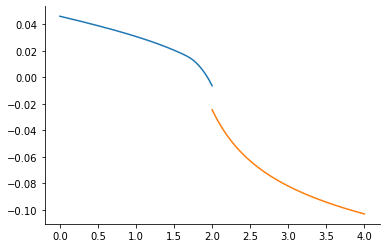

In [72]:
ϕ_bound = np.average(ϕ_temp_list, axis=0, weights=πᵈ_temp[:,-1])
plt.plot(y_grid[:numy_bar+1], ϕ_temp)
plt.plot(y_grid[numy_bar:], ϕ_bound[numy_bar:])

In [73]:
yt_temp, et_temp, πᵈt_temp, πᶜt_temp, ιt_temp, ht_temp = simulate_jump(y_grid[:numy_bar+1], ems_temp, πᶜ_temp, πᵈ_temp, ι_temp, h_temp, θtemp_list)

In [74]:
ξₐ = 1/15_000
ξₘ = 0.002/η/10
dmg_weight = np.array([0.475, 0.475, 0.05])
args = (δ, η, θcarb_list, γ1, γ2, γ3_list, dmg_weight, ς, ξₘ, ξₐ, ξ)
ϕ_carb, ems_carb, πᶜ_carb, ι_carb, πᵈ_carb, h_carb, ϕ_carb_list = solve_jump(y_grid, numy_bar, args, tol=2e-6)

episode: 1,	 ode error: 0.0017049709683354603,	 ft error: 0.0014434370169589354
episode: 2,	 ode error: 0.0014291431559060822,	 ft error: 0.001301959405200656
episode: 3,	 ode error: 0.0013208957317948447,	 ft error: 0.0012338294308831366
episode: 4,	 ode error: 0.0012544522124182532,	 ft error: 0.001188576281111681
episode: 5,	 ode error: 0.0012046018024064742,	 ft error: 0.0011531142573051115
episode: 6,	 ode error: 0.0011638088093069016,	 ft error: 0.0011227913801736809
episode: 7,	 ode error: 0.0011295455954586284,	 ft error: 0.0010961152183299946
episode: 8,	 ode error: 0.0011000623304738039,	 ft error: 0.0010722540559880253
episode: 9,	 ode error: 0.0010744279332413772,	 ft error: 0.001050611673143382
episode: 10,	 ode error: 0.0010517101452761054,	 ft error: 0.001031156638141038
episode: 11,	 ode error: 0.0010311706396554233,	 ft error: 0.0010131157866096108
episode: 12,	 ode error: 0.0010126345057604811,	 ft error: 0.000996641099500546
episode: 13,	 ode error: 0.000995397996078

episode: 146,	 ode error: 0.0004083942005618735,	 ft error: 0.00040738567401042475
episode: 147,	 ode error: 0.000406517830947309,	 ft error: 0.00040556998241524783
episode: 148,	 ode error: 0.0004046782924357631,	 ft error: 0.0004037959630260694
episode: 149,	 ode error: 0.00040287058361696275,	 ft error: 0.0004020511060425063
episode: 150,	 ode error: 0.0004010900083873905,	 ft error: 0.0004003189516804789
episode: 151,	 ode error: 0.00039933162266119675,	 ft error: 0.00039858546725684657
episode: 152,	 ode error: 0.00039758551099663736,	 ft error: 0.00039887814862474974
episode: 153,	 ode error: 0.0003972356531116649,	 ft error: 0.0003959718113850352
episode: 154,	 ode error: 0.0003949354591587924,	 ft error: 0.0003935257269947294
episode: 155,	 ode error: 0.000392393878567723,	 ft error: 0.00039141788313971454
episode: 156,	 ode error: 0.00039038769601783176,	 ft error: 0.0003896270884664923
episode: 157,	 ode error: 0.0003885302019262237,	 ft error: 0.0003898817560783174
episode: 

episode: 253,	 ode error: 0.0002576170793366045,	 ft error: 0.0002559033306416316
episode: 254,	 ode error: 0.00025699705215653454,	 ft error: 0.0002550348660126702
episode: 255,	 ode error: 0.00025615167659085944,	 ft error: 0.0002540573235832363
episode: 256,	 ode error: 0.0002550889718761222,	 ft error: 0.00025308275260681656
episode: 257,	 ode error: 0.00025380390902870944,	 ft error: 0.0002520363995419985
episode: 258,	 ode error: 0.00025236397913405825,	 ft error: 0.0002508687904770555
episode: 259,	 ode error: 0.00025085596465977613,	 ft error: 0.0002496237646252194
episode: 260,	 ode error: 0.00024934965533753267,	 ft error: 0.0002484501897839081
episode: 261,	 ode error: 0.0002479033203164826,	 ft error: 0.00024697119314421223
episode: 262,	 ode error: 0.0002495040236015001,	 ft error: 0.00024595938931210504
episode: 263,	 ode error: 0.00024869799515472727,	 ft error: 0.00024740833719213984
episode: 264,	 ode error: 0.0002458539043024428,	 ft error: 0.0002449202234826078
episo

episode: 362,	 ode error: 0.00016904814368279633,	 ft error: 0.0001654617932361537
episode: 363,	 ode error: 0.00016824581142927872,	 ft error: 0.00016719775783972474
episode: 364,	 ode error: 0.00016575069634339017,	 ft error: 0.00016499051657928773
episode: 365,	 ode error: 0.00016423854915712953,	 ft error: 0.00016368154377892816
episode: 366,	 ode error: 0.00016318991452270767,	 ft error: 0.00016206609879709327
episode: 367,	 ode error: 0.00016386913264375164,	 ft error: 0.00016286924845174597
episode: 368,	 ode error: 0.0001625832100281972,	 ft error: 0.00016025975064682305
episode: 369,	 ode error: 0.00016242029481062343,	 ft error: 0.00015998165505089665
episode: 370,	 ode error: 0.00016139479163847226,	 ft error: 0.00015856216497626974
episode: 371,	 ode error: 0.00016077460629737876,	 ft error: 0.0001582036769555197
episode: 372,	 ode error: 0.00015968669741456916,	 ft error: 0.0001570887225453103
episode: 373,	 ode error: 0.0001590780750200659,	 ft error: 0.000157172763544909

episode: 473,	 ode error: 0.00011097248869690183,	 ft error: 0.00010817667221949916
episode: 474,	 ode error: 0.00011071186001480231,	 ft error: 0.0001088761252107893
episode: 475,	 ode error: 0.00011039151697649595,	 ft error: 0.00010991999696993715
episode: 476,	 ode error: 0.00011000274974485951,	 ft error: 0.00010778444698086864
episode: 477,	 ode error: 0.00010820134633638518,	 ft error: 0.00010646310324398853
episode: 478,	 ode error: 0.00010718574872325829,	 ft error: 0.00010602279859416494
episode: 479,	 ode error: 0.00010643904236542448,	 ft error: 0.00010575272938510849
episode: 480,	 ode error: 0.00010581829243587037,	 ft error: 0.00011034227972950747
episode: 481,	 ode error: 0.0001072472722086046,	 ft error: 0.00010639063078195232
episode: 482,	 ode error: 0.00010602550100602935,	 ft error: 0.0001087457251583666
episode: 483,	 ode error: 0.00010700577923176361,	 ft error: 0.00010679985603922101
episode: 484,	 ode error: 0.00010663826498183047,	 ft error: 0.0001050009813998

episode: 583,	 ode error: 7.399140530198558e-05,	 ft error: 7.296409728868118e-05
episode: 584,	 ode error: 7.388810207332368e-05,	 ft error: 7.411381962402672e-05
episode: 585,	 ode error: 7.307608432176077e-05,	 ft error: 7.226415379979478e-05
episode: 586,	 ode error: 7.296228217659609e-05,	 ft error: 7.25557420734833e-05
episode: 587,	 ode error: 7.243156151917336e-05,	 ft error: 7.172356559025095e-05
episode: 588,	 ode error: 7.220658809883385e-05,	 ft error: 7.17398971795726e-05
episode: 589,	 ode error: 7.183248469185314e-05,	 ft error: 7.127116795892693e-05
episode: 590,	 ode error: 7.159552267278909e-05,	 ft error: 7.11476579540645e-05
episode: 591,	 ode error: 7.13127974355124e-05,	 ft error: 7.083426752922672e-05
episode: 592,	 ode error: 7.109406925507591e-05,	 ft error: 7.061009720063054e-05
episode: 593,	 ode error: 7.08625112356791e-05,	 ft error: 7.037223528289875e-05
episode: 594,	 ode error: 7.06557196542936e-05,	 ft error: 7.012499765299274e-05
episode: 595,	 ode err

episode: 694,	 ode error: 4.929239629909005e-05,	 ft error: 4.903399078627173e-05
episode: 695,	 ode error: 4.8914900399872337e-05,	 ft error: 4.869337652806116e-05
episode: 696,	 ode error: 4.855090065853263e-05,	 ft error: 4.83817580133189e-05
episode: 697,	 ode error: 4.821022247226156e-05,	 ft error: 4.808843926204047e-05
episode: 698,	 ode error: 4.79041665618666e-05,	 ft error: 4.782164994244591e-05
episode: 699,	 ode error: 4.764532489942737e-05,	 ft error: 4.7592587156160736e-05
episode: 700,	 ode error: 4.7447188043858854e-05,	 ft error: 4.748912865393251e-05
episode: 701,	 ode error: 4.743637497939409e-05,	 ft error: 4.755932551103274e-05
episode: 702,	 ode error: 4.751561324582807e-05,	 ft error: 4.775579146275762e-05
episode: 703,	 ode error: 4.758715298712902e-05,	 ft error: 4.810421959428972e-05
episode: 704,	 ode error: 4.76429946023011e-05,	 ft error: 4.862962058672464e-05
episode: 705,	 ode error: 4.778635864352728e-05,	 ft error: 4.9351475007314294e-05
episode: 706,	 

episode: 805,	 ode error: 3.3732637169432526e-05,	 ft error: 3.3806359837976196e-05
episode: 806,	 ode error: 3.37119181976959e-05,	 ft error: 3.3766532009903614e-05
episode: 807,	 ode error: 3.3690158629052233e-05,	 ft error: 3.372416600736876e-05
episode: 808,	 ode error: 3.3666048540832824e-05,	 ft error: 3.3678470048361296e-05
episode: 809,	 ode error: 3.363848356999048e-05,	 ft error: 3.3628817474133196e-05
episode: 810,	 ode error: 3.3606575995094546e-05,	 ft error: 3.357477412833931e-05
episode: 811,	 ode error: 3.356966674532887e-05,	 ft error: 3.351606682496881e-05
episode: 812,	 ode error: 3.3527311439647827e-05,	 ft error: 3.3452572717103855e-05
episode: 813,	 ode error: 3.3479261798103374e-05,	 ft error: 3.3384286782141746e-05
episode: 814,	 ode error: 3.342543546612628e-05,	 ft error: 3.331129928477635e-05
episode: 815,	 ode error: 3.336588478489253e-05,	 ft error: 3.323376918653217e-05
episode: 816,	 ode error: 3.3300764188302586e-05,	 ft error: 3.315190623763564e-05
epis

episode: 916,	 ode error: 2.2952387824221217e-05,	 ft error: 2.2880708187890862e-05
episode: 917,	 ode error: 2.2746277975596455e-05,	 ft error: 2.2704476523999206e-05
episode: 918,	 ode error: 2.270991279044196e-05,	 ft error: 2.2523196771424375e-05
episode: 919,	 ode error: 2.2827090567724547e-05,	 ft error: 2.2338081261535914e-05
episode: 920,	 ode error: 2.2947326418993447e-05,	 ft error: 2.2150333812698264e-05
episode: 921,	 ode error: 2.3068829318208294e-05,	 ft error: 2.1963840925361598e-05
episode: 922,	 ode error: 2.318981055785029e-05,	 ft error: 2.182669289460537e-05
episode: 923,	 ode error: 2.3308488785096695e-05,	 ft error: 2.17015276608723e-05
episode: 924,	 ode error: 2.3423095068191555e-05,	 ft error: 2.1586938326346543e-05
episode: 925,	 ode error: 2.353187546466054e-05,	 ft error: 2.1481626739788817e-05
episode: 926,	 ode error: 2.363309481663719e-05,	 ft error: 2.1384401077291042e-05
episode: 927,	 ode error: 2.372504145470777e-05,	 ft error: 2.129416399924977e-05
e

episode: 1027,	 ode error: 1.5677624593547854e-05,	 ft error: 1.5564733502014077e-05
episode: 1028,	 ode error: 1.554748793220677e-05,	 ft error: 1.5569702223698172e-05
episode: 1029,	 ode error: 1.5506236249776995e-05,	 ft error: 1.5581792118963638e-05
episode: 1030,	 ode error: 1.5522499188478115e-05,	 ft error: 1.559979346074658e-05
episode: 1031,	 ode error: 1.5547210561203434e-05,	 ft error: 1.5622303800796877e-05
episode: 1032,	 ode error: 1.5578748171086315e-05,	 ft error: 1.5647753336354524e-05
episode: 1033,	 ode error: 1.5615313042139918e-05,	 ft error: 1.5674440228587626e-05
episode: 1034,	 ode error: 1.5654976015588807e-05,	 ft error: 1.57005750375111e-05
episode: 1035,	 ode error: 1.569572896931398e-05,	 ft error: 1.5724332532047563e-05
episode: 1036,	 ode error: 1.573553846119513e-05,	 ft error: 1.5743908270924683e-05
episode: 1037,	 ode error: 1.5772399413530947e-05,	 ft error: 1.5757576765987324e-05
episode: 1038,	 ode error: 1.5804386478070805e-05,	 ft error: 1.5763747

episode: 1138,	 ode error: 1.2143294170126242e-05,	 ft error: 1.0590943246152618e-05
episode: 1139,	 ode error: 1.2115061167000869e-05,	 ft error: 1.0559416926310869e-05
episode: 1140,	 ode error: 1.208430994262548e-05,	 ft error: 1.0527672989202319e-05
episode: 1141,	 ode error: 1.2053295863090905e-05,	 ft error: 1.0495531248845096e-05
episode: 1142,	 ode error: 1.2022975819281486e-05,	 ft error: 1.046322465181789e-05
episode: 1143,	 ode error: 1.1995118065373121e-05,	 ft error: 1.043077819488462e-05
episode: 1144,	 ode error: 1.1970706865191525e-05,	 ft error: 1.0398376564755656e-05
episode: 1145,	 ode error: 1.195071973033202e-05,	 ft error: 1.0366125036039472e-05
episode: 1146,	 ode error: 1.1935427494665779e-05,	 ft error: 1.0334157871221458e-05
episode: 1147,	 ode error: 1.1924684934879718e-05,	 ft error: 1.030254695437438e-05
episode: 1148,	 ode error: 1.1917653752530695e-05,	 ft error: 1.0271359368619708e-05
episode: 1149,	 ode error: 1.1912958181130133e-05,	 ft error: 1.024061

episode: 1249,	 ode error: 9.45469178145926e-06,	 ft error: 9.275072814414939e-06
episode: 1250,	 ode error: 9.45717924729771e-06,	 ft error: 9.2749448985426e-06
episode: 1251,	 ode error: 9.457456306906148e-06,	 ft error: 9.276630724835977e-06
episode: 1252,	 ode error: 9.456987399761915e-06,	 ft error: 9.281494963616263e-06
episode: 1253,	 ode error: 9.457201084311028e-06,	 ft error: 9.290724416928983e-06
episode: 1254,	 ode error: 9.459418602765154e-06,	 ft error: 9.3052604898299e-06
episode: 1255,	 ode error: 9.464785033555675e-06,	 ft error: 9.32573720892338e-06
episode: 1256,	 ode error: 9.474206129411592e-06,	 ft error: 9.352427395720175e-06
episode: 1257,	 ode error: 9.48829408647814e-06,	 ft error: 9.38520016889599e-06
episode: 1258,	 ode error: 9.5073254509963e-06,	 ft error: 9.423493407591707e-06
episode: 1259,	 ode error: 9.531214065434447e-06,	 ft error: 9.466304921115776e-06
episode: 1260,	 ode error: 9.559501324866407e-06,	 ft error: 9.512205708175903e-06
episode: 1261,	

episode: 1360,	 ode error: 5.656157292233208e-06,	 ft error: 5.389401723209416e-06
episode: 1361,	 ode error: 5.617083865881332e-06,	 ft error: 5.352912699647476e-06
episode: 1362,	 ode error: 5.576411464743437e-06,	 ft error: 5.314809311008732e-06
episode: 1363,	 ode error: 5.533875263356316e-06,	 ft error: 5.274822234164571e-06
episode: 1364,	 ode error: 5.48925628868842e-06,	 ft error: 5.232746897570103e-06
episode: 1365,	 ode error: 5.442392188051491e-06,	 ft error: 5.18845172809331e-06
episode: 1366,	 ode error: 5.393184430276627e-06,	 ft error: 5.141881820440916e-06
episode: 1367,	 ode error: 5.3416020500449786e-06,	 ft error: 5.093058495428404e-06
episode: 1368,	 ode error: 5.2876822423052715e-06,	 ft error: 5.042075404855055e-06
episode: 1369,	 ode error: 5.231528230510078e-06,	 ft error: 4.9890919595618755e-06
episode: 1370,	 ode error: 5.173304917287409e-06,	 ft error: 4.9343248817908716e-06
episode: 1371,	 ode error: 5.1132328428808846e-06,	 ft error: 4.8780386605745685e-06


episode: 1471,	 ode error: 5.486746592342929e-06,	 ft error: 5.380313277426422e-06
episode: 1472,	 ode error: 5.5160971014496085e-06,	 ft error: 5.397065238124665e-06
episode: 1473,	 ode error: 5.539992142170437e-06,	 ft error: 5.395527437127012e-06
episode: 1474,	 ode error: 5.553794224123147e-06,	 ft error: 5.383115122247392e-06
episode: 1475,	 ode error: 5.55805139709493e-06,	 ft error: 5.353469055881707e-06
episode: 1476,	 ode error: 5.55037794423873e-06,	 ft error: 5.34381989434248e-06
episode: 1477,	 ode error: 5.530164996984401e-06,	 ft error: 5.322437848255072e-06
episode: 1478,	 ode error: 5.4960303035010444e-06,	 ft error: 5.284801191130876e-06
episode: 1479,	 ode error: 5.447335622193778e-06,	 ft error: 5.230330743672777e-06
episode: 1480,	 ode error: 5.3833759106398276e-06,	 ft error: 5.158932627434091e-06
episode: 1481,	 ode error: 5.3038653005003196e-06,	 ft error: 5.070900054883014e-06
episode: 1482,	 ode error: 5.208665727464944e-06,	 ft error: 4.966905514959079e-06
epi

episode: 1583,	 ode error: 4.003792286110127e-06,	 ft error: 3.794658973502174e-06
episode: 1584,	 ode error: 3.4517410784823442e-06,	 ft error: 3.86152939413816e-06
episode: 1585,	 ode error: 4.62056050838796e-06,	 ft error: 4.731411201395567e-06
episode: 1586,	 ode error: 3.6092333605645e-06,	 ft error: 3.232244740469792e-06
episode: 1587,	 ode error: 4.088241081748388e-06,	 ft error: 2.715793568849878e-06
episode: 1588,	 ode error: 3.6496776087010206e-06,	 ft error: 2.973166131949497e-06
episode: 1589,	 ode error: 3.843881089550072e-06,	 ft error: 2.7472922344238633e-06
episode: 1590,	 ode error: 3.6834550997290457e-06,	 ft error: 2.8489269666975847e-06
episode: 1591,	 ode error: 3.793300827815548e-06,	 ft error: 2.7529955699129305e-06
episode: 1592,	 ode error: 3.771852319228177e-06,	 ft error: 2.7844607544449027e-06
episode: 1593,	 ode error: 3.869171958035904e-06,	 ft error: 2.7435823888449784e-06
episode: 1594,	 ode error: 3.920611496766881e-06,	 ft error: 2.7546861587161393e-06

episode: 1694,	 ode error: 2.9833320478677393e-06,	 ft error: 3.2512874726988348e-06
episode: 1695,	 ode error: 3.1440009263960676e-06,	 ft error: 3.42761371623553e-06
episode: 1696,	 ode error: 3.319090132380075e-06,	 ft error: 3.6294596567065796e-06
episode: 1697,	 ode error: 3.5107455628597935e-06,	 ft error: 3.859547590458664e-06
episode: 1698,	 ode error: 3.7203026977360425e-06,	 ft error: 4.119700324559106e-06
episode: 1699,	 ode error: 3.948117486578338e-06,	 ft error: 4.410550065031549e-06
episode: 1700,	 ode error: 4.19344970439882e-06,	 ft error: 4.731271583633771e-06
episode: 1701,	 ode error: 4.454416724707783e-06,	 ft error: 5.079379929162631e-06
episode: 1702,	 ode error: 4.728030768078907e-06,	 ft error: 5.450636049939006e-06
episode: 1703,	 ode error: 5.010324219651189e-06,	 ft error: 5.839097346564219e-06
episode: 1704,	 ode error: 5.302751865868282e-06,	 ft error: 3.5011577505239533e-06
episode: 1705,	 ode error: 2.530091523618807e-06,	 ft error: 2.4201263153454207e-0

episode: 128,	 ode error: 0.0004462439702698275,	 ft error: 0.00044512421001028046
episode: 129,	 ode error: 0.0004440429541182939,	 ft error: 0.0004429342947867565
episode: 130,	 ode error: 0.00044185636255916197,	 ft error: 0.0004407584740841996
episode: 131,	 ode error: 0.00043968382839454107,	 ft error: 0.00043859637534659585
episode: 132,	 ode error: 0.0004375249935757153,	 ft error: 0.00043644763774645473
episode: 133,	 ode error: 0.0004353795067155252,	 ft error: 0.0004343119088508901
episode: 134,	 ode error: 0.0004332470211274896,	 ft error: 0.00043218884211940894
episode: 135,	 ode error: 0.00043112719334314163,	 ft error: 0.0004300780950785311
episode: 136,	 ode error: 0.00042901968204911987,	 ft error: 0.0004279793280369838
episode: 137,	 ode error: 0.00042692414738378245,	 ft error: 0.0004258922032465811
episode: 138,	 ode error: 0.00042484025053750774,	 ft error: 0.0004238163844272914
episode: 139,	 ode error: 0.00042276765360335904,	 ft error: 0.00042175153659496784
epis

episode: 227,	 ode error: 0.0002648998181392201,	 ft error: 0.0002641365616382757
episode: 228,	 ode error: 0.00026337611645163377,	 ft error: 0.0002626174209799381
episode: 229,	 ode error: 0.00026186003122395034,	 ft error: 0.0002611059022344468
episode: 230,	 ode error: 0.0002603515839310252,	 ft error: 0.0002596020255694424
episode: 231,	 ode error: 0.00025885079359319846,	 ft error: 0.0002581058087305216
episode: 232,	 ode error: 0.00025735795367842144,	 ft error: 0.00025652498916961996
episode: 233,	 ode error: 0.00025587678009923677,	 ft error: 0.0002550539609188357
episode: 234,	 ode error: 0.00025440553984882924,	 ft error: 0.00025358432131722397
episode: 235,	 ode error: 0.00025294351256388624,	 ft error: 0.0002521289140949151
episode: 236,	 ode error: 0.000251489777828311,	 ft error: 0.00025068208161040106
episode: 237,	 ode error: 0.00025004379397487156,	 ft error: 0.0002492433655239037
episode: 238,	 ode error: 0.00024860523504504825,	 ft error: 0.0002478119747893517
episo

episode: 332,	 ode error: 0.00014384416312537157,	 ft error: 0.00014357723339758027
episode: 333,	 ode error: 0.00014301329752631705,	 ft error: 0.0001427511291129946
episode: 334,	 ode error: 0.0001421873592946254,	 ft error: 0.00014192995143912554
episode: 335,	 ode error: 0.00014136631696732617,	 ft error: 0.00014111366909162298
episode: 336,	 ode error: 0.00014055013926377892,	 ft error: 0.00014030225093490667
episode: 337,	 ode error: 0.00013973879508828442,	 ft error: 0.00013949566598998414
episode: 338,	 ode error: 0.00013893225353273086,	 ft error: 0.00013869388336198535
episode: 339,	 ode error: 0.00013813048388154636,	 ft error: 0.0001378968722310035
episode: 340,	 ode error: 0.00013733345561791927,	 ft error: 0.0001371046019834482
episode: 341,	 ode error: 0.00013654113842832458,	 ft error: 0.00013631704231157246
episode: 342,	 ode error: 0.00013575350220189418,	 ft error: 0.00013553416322529174
episode: 343,	 ode error: 0.00013497051702643728,	 ft error: 0.00013475593495397

episode: 436,	 ode error: 7.97789972038312e-05,	 ft error: 7.945243064621614e-05
episode: 437,	 ode error: 7.933504720310724e-05,	 ft error: 7.901002017927465e-05
episode: 438,	 ode error: 7.889347355857345e-05,	 ft error: 7.856997519972246e-05
episode: 439,	 ode error: 7.845426478347362e-05,	 ft error: 7.813228432446603e-05
episode: 440,	 ode error: 7.801740940305973e-05,	 ft error: 7.76969361771888e-05
episode: 441,	 ode error: 7.758289595342818e-05,	 ft error: 7.726391938872128e-05
episode: 442,	 ode error: 7.715071298081437e-05,	 ft error: 7.683322259687912e-05
episode: 443,	 ode error: 7.67208490420816e-05,	 ft error: 7.640483444734207e-05
episode: 444,	 ode error: 7.629329270484849e-05,	 ft error: 7.597874359437096e-05
episode: 445,	 ode error: 7.586803254884533e-05,	 ft error: 7.555493870254246e-05
episode: 446,	 ode error: 7.544505716678177e-05,	 ft error: 7.513340844769734e-05
episode: 447,	 ode error: 7.502435516570807e-05,	 ft error: 7.471414151883719e-05
episode: 448,	 ode 

episode: 544,	 ode error: 4.333645756810552e-05,	 ft error: 4.3153213822750655e-05
episode: 545,	 ode error: 4.311461128776511e-05,	 ft error: 4.28267489992427e-05
episode: 546,	 ode error: 4.2843978656821255e-05,	 ft error: 4.266483855754529e-05
episode: 547,	 ode error: 4.2626311893323486e-05,	 ft error: 4.234105394011756e-05
episode: 548,	 ode error: 4.2359312655214495e-05,	 ft error: 4.218230777117601e-05
episode: 549,	 ode error: 4.214459556484292e-05,	 ft error: 4.186127222564433e-05
episode: 550,	 ode error: 4.188064656262679e-05,	 ft error: 4.170538188271826e-05
episode: 551,	 ode error: 4.166857856294963e-05,	 ft error: 4.1386930467480584e-05
episode: 552,	 ode error: 4.1407431339233135e-05,	 ft error: 4.1233646432201065e-05
episode: 553,	 ode error: 4.119789969823278e-05,	 ft error: 4.091781498412328e-05
episode: 554,	 ode error: 4.0939377007992786e-05,	 ft error: 4.076699719813189e-05
episode: 555,	 ode error: 4.073235521721331e-05,	 ft error: 4.0453785552600305e-05
episode:

episode: 656,	 ode error: 2.280816046529516e-05,	 ft error: 2.287901579373202e-05
episode: 657,	 ode error: 2.26747649414306e-05,	 ft error: 2.2821011669589324e-05
episode: 658,	 ode error: 2.2542068258745948e-05,	 ft error: 2.2763147481119628e-05
episode: 659,	 ode error: 2.2410066419120147e-05,	 ft error: 2.2705422877683283e-05
episode: 660,	 ode error: 2.227875544297893e-05,	 ft error: 2.2647837506246708e-05
episode: 661,	 ode error: 2.21481313696447e-05,	 ft error: 2.2590391018627774e-05
episode: 662,	 ode error: 2.2018190256903173e-05,	 ft error: 2.253308306713007e-05
episode: 663,	 ode error: 2.1888928181605866e-05,	 ft error: 2.2475913305259935e-05
episode: 664,	 ode error: 2.1760341239622288e-05,	 ft error: 2.2418881388703665e-05
episode: 665,	 ode error: 2.163242554575743e-05,	 ft error: 2.2361986975651348e-05
episode: 666,	 ode error: 2.1505177234372908e-05,	 ft error: 2.2305229724223684e-05
episode: 667,	 ode error: 2.137859245890264e-05,	 ft error: 2.22486092959819e-05
epis

episode: 768,	 ode error: 1.5934309404599326e-05,	 ft error: 1.7185888856220688e-05
episode: 769,	 ode error: 1.589088504448064e-05,	 ft error: 1.7141822800393246e-05
episode: 770,	 ode error: 1.5847565196955087e-05,	 ft error: 1.709786711987423e-05
episode: 771,	 ode error: 1.580434962738969e-05,	 ft error: 1.7054021609029524e-05
episode: 772,	 ode error: 1.5761238101441924e-05,	 ft error: 1.7010286064884916e-05
episode: 773,	 ode error: 1.5718230385038047e-05,	 ft error: 1.696666028972819e-05
episode: 774,	 ode error: 1.567532624438753e-05,	 ft error: 1.6923144085951212e-05
episode: 775,	 ode error: 1.563252544595296e-05,	 ft error: 1.6879737261092192e-05
episode: 776,	 ode error: 1.5589827756468826e-05,	 ft error: 1.683643962279343e-05
episode: 777,	 ode error: 1.554723294292052e-05,	 ft error: 1.679325098193537e-05
episode: 778,	 ode error: 1.5504740772551053e-05,	 ft error: 1.6750171150878755e-05
episode: 779,	 ode error: 1.5462351012854384e-05,	 ft error: 1.6707199943048295e-05
e

episode: 880,	 ode error: 1.1669316906585107e-05,	 ft error: 1.288118145781105e-05
episode: 881,	 ode error: 1.1636235767324265e-05,	 ft error: 1.2847861185436479e-05
episode: 882,	 ode error: 1.1603235806410941e-05,	 ft error: 1.281462112689517e-05
episode: 883,	 ode error: 1.1570316846347986e-05,	 ft error: 1.2781461089054574e-05
episode: 884,	 ode error: 1.1537478709992431e-05,	 ft error: 1.2748380881661785e-05
episode: 885,	 ode error: 1.1504721220541043e-05,	 ft error: 1.271538031736667e-05
episode: 886,	 ode error: 1.1472044201531759e-05,	 ft error: 1.268245921136335e-05
episode: 887,	 ode error: 1.143944747683412e-05,	 ft error: 1.2649617380233735e-05
episode: 888,	 ode error: 1.1406930870641005e-05,	 ft error: 1.2616854645347564e-05
episode: 889,	 ode error: 1.1374494207463503e-05,	 ft error: 1.2584170828537172e-05
episode: 890,	 ode error: 1.1342137312127124e-05,	 ft error: 1.2551565755844485e-05
episode: 891,	 ode error: 1.130986000975919e-05,	 ft error: 1.251903925547406e-05

episode: 991,	 ode error: 8.454849590566217e-06,	 ft error: 9.643441179751449e-06
episode: 992,	 ode error: 8.429741098922583e-06,	 ft error: 9.618252354859821e-06
episode: 993,	 ode error: 8.40469532000342e-06,	 ft error: 9.593128073940213e-06
episode: 994,	 ode error: 8.379712104454975e-06,	 ft error: 9.56806810178725e-06
episode: 995,	 ode error: 8.354791303431737e-06,	 ft error: 9.543072206954125e-06
episode: 996,	 ode error: 8.329932768607533e-06,	 ft error: 9.518140155854542e-06
episode: 997,	 ode error: 8.305136352169148e-06,	 ft error: 9.493271717990009e-06
episode: 998,	 ode error: 8.280401906799801e-06,	 ft error: 9.468466665602897e-06
episode: 999,	 ode error: 8.255729285697974e-06,	 ft error: 9.443724768946431e-06
episode: 1000,	 ode error: 8.231118342556711e-06,	 ft error: 9.419045803732429e-06
episode: 1001,	 ode error: 8.206568931563775e-06,	 ft error: 9.394429544793786e-06
episode: 1002,	 ode error: 8.182080907397966e-06,	 ft error: 9.369875770872301e-06
episode: 1003,	

episode: 1102,	 ode error: 6.019970721290687e-06,	 ft error: 7.201773393437916e-06
episode: 1103,	 ode error: 6.00099608633376e-06,	 ft error: 7.182743790775751e-06
episode: 1104,	 ode error: 5.982069706572706e-06,	 ft error: 7.16376276947243e-06
episode: 1105,	 ode error: 5.9631914660507204e-06,	 ft error: 7.1448302155219245e-06
episode: 1106,	 ode error: 5.944361249056896e-06,	 ft error: 7.125946015415496e-06
episode: 1107,	 ode error: 5.925578940121559e-06,	 ft error: 7.107110056130128e-06
episode: 1108,	 ode error: 5.906844424012479e-06,	 ft error: 7.088322224758452e-06
episode: 1109,	 ode error: 5.888157585740987e-06,	 ft error: 7.069582407514171e-06
episode: 1110,	 ode error: 5.869518310557052e-06,	 ft error: 7.050890491813733e-06
episode: 1111,	 ode error: 5.850926483954612e-06,	 ft error: 7.032246364807593e-06
episode: 1112,	 ode error: 5.832381991668624e-06,	 ft error: 7.013649913229873e-06
episode: 1113,	 ode error: 5.813884719677097e-06,	 ft error: 6.995101024416066e-06
epis

episode: 1213,	 ode error: 4.184091870209288e-06,	 ft error: 5.361769329590797e-06
episode: 1214,	 ode error: 4.1698182123630365e-06,	 ft error: 5.347474349391239e-06
episode: 1215,	 ode error: 4.1555813676569405e-06,	 ft error: 5.333216412962509e-06
episode: 1216,	 ode error: 4.141381245405511e-06,	 ft error: 5.318995429983339e-06
episode: 1217,	 ode error: 4.12721775513487e-06,	 ft error: 5.304811306663012e-06
episode: 1218,	 ode error: 4.113090806573855e-06,	 ft error: 5.2906639530850286e-06
episode: 1219,	 ode error: 4.099000309659636e-06,	 ft error: 5.276553276326035e-06
episode: 1220,	 ode error: 4.084946174530554e-06,	 ft error: 5.262479186677697e-06
episode: 1221,	 ode error: 4.0709283115388385e-06,	 ft error: 5.248441591702384e-06
episode: 1222,	 ode error: 4.056946631235262e-06,	 ft error: 5.234440400951612e-06
episode: 1223,	 ode error: 4.043001044372557e-06,	 ft error: 5.220475524890522e-06
episode: 1224,	 ode error: 4.02909146191756e-06,	 ft error: 5.206546871231825e-06
ep

episode: 1324,	 ode error: 2.8055349253256986e-06,	 ft error: 3.981961750783303e-06
episode: 1325,	 ode error: 2.794837496356039e-06,	 ft error: 3.97126081141258e-06
episode: 1326,	 ode error: 2.7841679927170467e-06,	 ft error: 3.960587899344559e-06
episode: 1327,	 ode error: 2.7735263443567936e-06,	 ft error: 3.949942944924309e-06
episode: 1328,	 ode error: 2.7629124813847343e-06,	 ft error: 3.939325876634962e-06
episode: 1329,	 ode error: 2.7523263340764506e-06,	 ft error: 3.928736625527045e-06
episode: 1330,	 ode error: 2.7417678328711843e-06,	 ft error: 3.918175120245597e-06
episode: 1331,	 ode error: 2.7312369083688293e-06,	 ft error: 3.907641291609846e-06
episode: 1332,	 ode error: 2.7207334913380353e-06,	 ft error: 3.897135068785251e-06
episode: 1333,	 ode error: 2.710257512705664e-06,	 ft error: 3.886656383481532e-06
episode: 1334,	 ode error: 2.6998089035667105e-06,	 ft error: 3.876205164956663e-06
episode: 1335,	 ode error: 2.6893875951723484e-06,	 ft error: 3.865781344318994

episode: 1433,	 ode error: 1.7900534629380644e-06,	 ft error: 2.9665961191402412e-06
episode: 1434,	 ode error: 1.7820202616142765e-06,	 ft error: 2.9585676889395027e-06
episode: 1435,	 ode error: 1.7740082496408931e-06,	 ft error: 2.9505604972127064e-06
episode: 1436,	 ode error: 1.766017373014075e-06,	 ft error: 2.942574488888165e-06
episode: 1437,	 ode error: 1.7580475778578106e-06,	 ft error: 2.9346096103513575e-06
episode: 1438,	 ode error: 1.750098810428415e-06,	 ft error: 2.9266658073979585e-06
episode: 1439,	 ode error: 1.742171017113229e-06,	 ft error: 2.9187430256039093e-06
episode: 1440,	 ode error: 1.7342641444243855e-06,	 ft error: 2.910841210926792e-06
episode: 1441,	 ode error: 1.7263781390110873e-06,	 ft error: 2.902960309370447e-06
episode: 1442,	 ode error: 1.7185129476467327e-06,	 ft error: 2.8951002683727523e-06
episode: 1443,	 ode error: 1.710668517234499e-06,	 ft error: 2.8872610330239285e-06
episode: 1444,	 ode error: 1.702844794808779e-06,	 ft error: 2.879442550

episode: 1544,	 ode error: 1.1709771583241898e-06,	 ft error: 2.1937797784962743e-06
episode: 1545,	 ode error: 1.1732854933708438e-06,	 ft error: 2.1878041761338083e-06
episode: 1546,	 ode error: 1.1755902875863495e-06,	 ft error: 2.181844518320264e-06
episode: 1547,	 ode error: 1.1778915392148957e-06,	 ft error: 2.1759007650066593e-06
episode: 1548,	 ode error: 1.1801892465589472e-06,	 ft error: 2.169972874837186e-06
episode: 1549,	 ode error: 1.182483407981467e-06,	 ft error: 2.164060805692758e-06
episode: 1550,	 ode error: 1.184774021917572e-06,	 ft error: 2.1581645178944675e-06
episode: 1551,	 ode error: 1.18706108684553e-06,	 ft error: 2.152283969149756e-06
episode: 1552,	 ode error: 1.1893446013213466e-06,	 ft error: 2.146419119930058e-06
episode: 1553,	 ode error: 1.1916245639492199e-06,	 ft error: 2.14056992857888e-06
episode: 1554,	 ode error: 1.193900973412874e-06,	 ft error: 2.1347363545962117e-06
episode: 1555,	 ode error: 1.1961738284349565e-06,	 ft error: 2.1289183577711

episode: 151,	 ode error: 0.0006222849331691933,	 ft error: 0.0006226641255878176
episode: 152,	 ode error: 0.000620427908681886,	 ft error: 0.0006207945995916064
episode: 153,	 ode error: 0.0006185764590591263,	 ft error: 0.0006189308348480509
episode: 154,	 ode error: 0.0006167305670888339,	 ft error: 0.0006170728250195583
episode: 155,	 ode error: 0.0006148902155805166,	 ft error: 0.0006152205628900722
episode: 156,	 ode error: 0.0006130553873678766,	 ft error: 0.0006133740403728438
episode: 157,	 ode error: 0.0006112260653114408,	 ft error: 0.0006115332484998386
episode: 158,	 ode error: 0.0006094022323012131,	 ft error: 0.0006096981774165779
episode: 159,	 ode error: 0.0006075838712592481,	 ft error: 0.0006078688164058942
episode: 160,	 ode error: 0.0006057709651422655,	 ft error: 0.000606045153878169
episode: 161,	 ode error: 0.0006039634969442593,	 ft error: 0.0006042271773691137
episode: 162,	 ode error: 0.0006021614496989612,	 ft error: 0.0006024148735909082
episode: 163,	 ode

episode: 352,	 ode error: 0.00034144130490545337,	 ft error: 0.0003412425083563579
episode: 353,	 ode error: 0.0003404235344721808,	 ft error: 0.0003402253736993951
episode: 354,	 ode error: 0.00033940879754133,	 ft error: 0.00033921127259889383
episode: 355,	 ode error: 0.00033839708506640427,	 ft error: 0.0003382001959143418
episode: 356,	 ode error: 0.00033738838802815116,	 ft error: 0.0003371921345370066
episode: 357,	 ode error: 0.0003363826974344586,	 ft error: 0.0003361870793922028
episode: 358,	 ode error: 0.000335380004320292,	 ft error: 0.000335185021427172
episode: 359,	 ode error: 0.00033438029974759947,	 ft error: 0.0003341859516201492
episode: 360,	 ode error: 0.0003333835748051806,	 ft error: 0.0003331898609932697
episode: 361,	 ode error: 0.00033238982060867237,	 ft error: 0.00033219674057435866
episode: 362,	 ode error: 0.0003313990283003843,	 ft error: 0.0003312065814444857
episode: 363,	 ode error: 0.00033041118904926525,	 ft error: 0.00033021937469822815
episode: 36

episode: 455,	 ode error: 0.000251170844376796,	 ft error: 0.00025032837925940504
episode: 456,	 ode error: 0.0002504242148104672,	 ft error: 0.00024958348661692964
episode: 457,	 ode error: 0.00024967980686836796,	 ft error: 0.0002488408101586348
episode: 458,	 ode error: 0.00024893761394111135,	 ft error: 0.000248100343288038
episode: 459,	 ode error: 0.0002481976294389838,	 ft error: 0.00024736207942766913
episode: 460,	 ode error: 0.00024745984679189117,	 ft error: 0.00024662601201837686
episode: 461,	 ode error: 0.00024672425944928197,	 ft error: 0.0002458921345264061
episode: 462,	 ode error: 0.0002459908608801179,	 ft error: 0.00024516044042762386
episode: 463,	 ode error: 0.00024525964457279125,	 ft error: 0.00024443092322611515
episode: 464,	 ode error: 0.0002445306040350782,	 ft error: 0.0002437035764414619
episode: 465,	 ode error: 0.00024380373279408096,	 ft error: 0.00024297839361184237
episode: 466,	 ode error: 0.00024307902439615892,	 ft error: 0.0002422553682993045
epis

episode: 560,	 ode error: 0.00018375347959628883,	 ft error: 0.00018318809334690508
episode: 561,	 ode error: 0.00018320733345615408,	 ft error: 0.00018256371072625233
episode: 562,	 ode error: 0.0001826631802096674,	 ft error: 0.00018189762555613037
episode: 563,	 ode error: 0.0001821200420969257,	 ft error: 0.0001815573553897813
episode: 564,	 ode error: 0.00018157875732090027,	 ft error: 0.00018093860545626933
episode: 565,	 ode error: 0.0001810394244861214,	 ft error: 0.00018028618763705578
episode: 566,	 ode error: 0.00018050112133772807,	 ft error: 0.00017994110680504458
episode: 567,	 ode error: 0.00017996465475723488,	 ft error: 0.00017932793168593902
episode: 568,	 ode error: 0.0001794300998637625,	 ft error: 0.00017868894831726823
episode: 569,	 ode error: 0.00017889658871076027,	 ft error: 0.0001783392222742819
episode: 570,	 ode error: 0.0001783648975288547,	 ft error: 0.0001777315651688612
episode: 571,	 ode error: 0.00017783507849659192,	 ft error: 0.00017710577712881648


episode: 667,	 ode error: 0.00013365334031199578,	 ft error: 0.00013316788964064705
episode: 668,	 ode error: 0.00013325650001224103,	 ft error: 0.00013265277566075023
episode: 669,	 ode error: 0.00013286048455900755,	 ft error: 0.00013237637978900468
episode: 670,	 ode error: 0.00013246599643040836,	 ft error: 0.00013186647245061467
episode: 671,	 ode error: 0.00013207233472282542,	 ft error: 0.00013158956682241912
episode: 672,	 ode error: 0.00013168018489282003,	 ft error: 0.00013108480695758762
episode: 673,	 ode error: 0.0001312888629636565,	 ft error: 0.00013080742295075906
episode: 674,	 ode error: 0.00013089903764050104,	 ft error: 0.00013030775216152368
episode: 675,	 ode error: 0.0001305100416051937,	 ft error: 0.00013002992053941695
episode: 676,	 ode error: 0.00013012252707747301,	 ft error: 0.00012953528120450883
episode: 677,	 ode error: 0.00012973584313363123,	 ft error: 0.00012925703211967104
episode: 678,	 ode error: 0.0001293506257698234,	 ft error: 0.0001287673673758

episode: 775,	 ode error: 9.693158395047779e-05,	 ft error: 9.650702803213711e-05
episode: 776,	 ode error: 9.664377491374482e-05,	 ft error: 9.620521644169526e-05
episode: 777,	 ode error: 9.635677957487668e-05,	 ft error: 9.593314804078509e-05
episode: 778,	 ode error: 9.607067852922355e-05,	 ft error: 9.563426528302887e-05
episode: 779,	 ode error: 9.578538976867559e-05,	 ft error: 9.536267609809117e-05
episode: 780,	 ode error: 9.550098660475361e-05,	 ft error: 9.506669367299418e-05
episode: 781,	 ode error: 9.521739428801498e-05,	 ft error: 9.479559200840464e-05
episode: 782,	 ode error: 9.49346789558158e-05,	 ft error: 9.450248177222953e-05
episode: 783,	 ode error: 9.46527730084515e-05,	 ft error: 9.423187568705083e-05
episode: 784,	 ode error: 9.437173551697371e-05,	 ft error: 9.394160985355209e-05
episode: 785,	 ode error: 9.409150592425228e-05,	 ft error: 9.367150717689196e-05
episode: 786,	 ode error: 9.381213634116446e-05,	 ft error: 9.338405830195777e-05
episode: 787,	 ode

episode: 884,	 ode error: 7.015308782686719e-05,	 ft error: 6.940312399325577e-05
episode: 885,	 ode error: 6.994607469402796e-05,	 ft error: 6.919691239143377e-05
episode: 886,	 ode error: 6.973967661646856e-05,	 ft error: 6.899131432341887e-05
episode: 887,	 ode error: 6.953389176587023e-05,	 ft error: 6.878632744284723e-05
episode: 888,	 ode error: 6.932871832056688e-05,	 ft error: 6.858194952608088e-05
episode: 889,	 ode error: 6.91241544652398e-05,	 ft error: 6.837817845069724e-05
episode: 890,	 ode error: 6.892019839069643e-05,	 ft error: 6.817501216870489e-05
episode: 891,	 ode error: 6.871684829368283e-05,	 ft error: 6.797244869470125e-05
episode: 892,	 ode error: 6.851410237672666e-05,	 ft error: 6.77704860953717e-05
episode: 893,	 ode error: 6.831195884801644e-05,	 ft error: 6.756912247852613e-05
episode: 894,	 ode error: 6.811041592130578e-05,	 ft error: 6.736835598370831e-05
episode: 895,	 ode error: 6.79094718158171e-05,	 ft error: 6.71681847822884e-05
episode: 896,	 ode e

episode: 995,	 ode error: 5.055532377415276e-05,	 ft error: 4.9876202051352125e-05
episode: 996,	 ode error: 5.040655326743492e-05,	 ft error: 4.9727932009691056e-05
episode: 997,	 ode error: 5.025822500504158e-05,	 ft error: 4.958010234692075e-05
episode: 998,	 ode error: 5.011033767348609e-05,	 ft error: 4.943271176158226e-05
episode: 999,	 ode error: 4.996288996315435e-05,	 ft error: 4.928575895924807e-05
episode: 1000,	 ode error: 4.981588056829182e-05,	 ft error: 4.9139242649977786e-05
episode: 1001,	 ode error: 4.966930818700371e-05,	 ft error: 4.899316154396982e-05
episode: 1002,	 ode error: 4.952317152122896e-05,	 ft error: 4.884751435840773e-05
episode: 1003,	 ode error: 4.937746927674157e-05,	 ft error: 4.870229981246421e-05
episode: 1004,	 ode error: 4.923220016312931e-05,	 ft error: 4.855751663021546e-05
episode: 1005,	 ode error: 4.90873628937931e-05,	 ft error: 4.841316353777307e-05
episode: 1006,	 ode error: 4.894295618592206e-05,	 ft error: 4.826923926790998e-05
episode

episode: 1106,	 ode error: 3.6472191314967624e-05,	 ft error: 3.583965527793424e-05
episode: 1107,	 ode error: 3.636528770998323e-05,	 ft error: 3.573310283453794e-05
episode: 1108,	 ode error: 3.625870192174724e-05,	 ft error: 3.562686708369345e-05
episode: 1109,	 ode error: 3.6152433005701406e-05,	 ft error: 3.552094708041594e-05
episode: 1110,	 ode error: 3.604648002009472e-05,	 ft error: 3.541534188457781e-05
episode: 1111,	 ode error: 3.594084202599183e-05,	 ft error: 3.531005055614397e-05
episode: 1112,	 ode error: 3.583551808724857e-05,	 ft error: 3.520507216137059e-05
episode: 1113,	 ode error: 3.573050727051692e-05,	 ft error: 3.510040576628256e-05
episode: 1114,	 ode error: 3.562580864522702e-05,	 ft error: 3.499605044120687e-05
episode: 1115,	 ode error: 3.552142128358197e-05,	 ft error: 3.489200525956989e-05
episode: 1116,	 ode error: 3.541734426055457e-05,	 ft error: 3.478826929641706e-05
episode: 1117,	 ode error: 3.531357665386998e-05,	 ft error: 3.4684841630309535e-05
e

episode: 1217,	 ode error: 2.6352460864852243e-05,	 ft error: 2.5752525281789545e-05
episode: 1218,	 ode error: 2.6275644585833794e-05,	 ft error: 2.5675950993999295e-05
episode: 1219,	 ode error: 2.6199056709776385e-05,	 ft error: 2.5599604284073006e-05
episode: 1220,	 ode error: 2.6122696557898117e-05,	 ft error: 2.552348447421952e-05
episode: 1221,	 ode error: 2.60465634534478e-05,	 ft error: 2.5447590885444942e-05
episode: 1222,	 ode error: 2.5970656721685872e-05,	 ft error: 2.5371922845601746e-05
episode: 1223,	 ode error: 2.5894975689891558e-05,	 ft error: 2.5296479679951894e-05
episode: 1224,	 ode error: 2.5819519687350504e-05,	 ft error: 2.522126071759686e-05
episode: 1225,	 ode error: 2.574428804534806e-05,	 ft error: 2.5146265289904823e-05
episode: 1226,	 ode error: 2.566928009716733e-05,	 ft error: 2.5071492728891608e-05
episode: 1227,	 ode error: 2.5594495178081792e-05,	 ft error: 2.4996942370088725e-05
episode: 1228,	 ode error: 2.5519932625351835e-05,	 ft error: 2.4922613

episode: 1328,	 ode error: 1.9081096731245195e-05,	 ft error: 1.850280516052516e-05
episode: 1329,	 ode error: 1.9025904819088783e-05,	 ft error: 1.8447761439184994e-05
episode: 1330,	 ode error: 1.897087709164659e-05,	 ft error: 1.8392881191338826e-05
episode: 1331,	 ode error: 1.8916013061317117e-05,	 ft error: 1.833816393482605e-05
episode: 1332,	 ode error: 1.8861312241934573e-05,	 ft error: 1.8283609189937804e-05
episode: 1333,	 ode error: 1.8806774148761706e-05,	 ft error: 1.8229216478167963e-05
episode: 1334,	 ode error: 1.8752398298488944e-05,	 ft error: 1.817498532304581e-05
episode: 1335,	 ode error: 1.869818420923092e-05,	 ft error: 1.8120915248285668e-05
episode: 1336,	 ode error: 1.8644131400518023e-05,	 ft error: 1.806700578088627e-05
episode: 1337,	 ode error: 1.8590239393295087e-05,	 ft error: 1.8013256447476277e-05
episode: 1338,	 ode error: 1.853650770991446e-05,	 ft error: 1.795966677787623e-05
episode: 1339,	 ode error: 1.8482935874137305e-05,	 ft error: 1.790623630

episode: 1439,	 ode error: 1.385705779978724e-05,	 ft error: 1.329228305045153e-05
episode: 1440,	 ode error: 1.3817407870849027e-05,	 ft error: 1.325273975209355e-05
episode: 1441,	 ode error: 1.3777875892027284e-05,	 ft error: 1.3213314308535562e-05
episode: 1442,	 ode error: 1.3738461511787889e-05,	 ft error: 1.3174006370843724e-05
episode: 1443,	 ode error: 1.3699164379635384e-05,	 ft error: 1.3134815592258375e-05
episode: 1444,	 ode error: 1.3659984146106906e-05,	 ft error: 1.3095741627638935e-05
episode: 1445,	 ode error: 1.3620920462773271e-05,	 ft error: 1.3056784131058412e-05
episode: 1446,	 ode error: 1.3581972982234635e-05,	 ft error: 1.3017942758625223e-05
episode: 1447,	 ode error: 1.3543141358119846e-05,	 ft error: 1.2979217167280455e-05
episode: 1448,	 ode error: 1.3504425245076035e-05,	 ft error: 1.2940607015029157e-05
episode: 1449,	 ode error: 1.3465824298775119e-05,	 ft error: 1.2902111960709044e-05
episode: 1450,	 ode error: 1.342733817590318e-05,	 ft error: 1.28637

episode: 1550,	 ode error: 1.0103890891213253e-05,	 ft error: 9.550715572061627e-06
episode: 1551,	 ode error: 1.00754013974112e-05,	 ft error: 9.522326042399332e-06
episode: 1552,	 ode error: 1.0046996585633778e-05,	 ft error: 9.494020959677218e-06
episode: 1553,	 ode error: 1.001867620401475e-05,	 ft error: 9.46580006609225e-06
episode: 1554,	 ode error: 9.990440001460483e-06,	 ft error: 9.437663104257718e-06
episode: 1555,	 ode error: 9.962287727642355e-06,	 ft error: 9.4096098181747e-06
episode: 1556,	 ode error: 9.93421913299806e-06,	 ft error: 9.38163995110412e-06
episode: 1557,	 ode error: 9.912095341319506e-06,	 ft error: 9.353753248203533e-06
episode: 1558,	 ode error: 9.896391105753708e-06,	 ft error: 9.325949455463167e-06
episode: 1559,	 ode error: 9.88072934138426e-06,	 ft error: 9.298228319659652e-06
episode: 1560,	 ode error: 9.865109939524106e-06,	 ft error: 9.270589587893435e-06
episode: 1561,	 ode error: 9.84953279191985e-06,	 ft error: 9.243033007773812e-06
episode: 1

episode: 1661,	 ode error: 8.488163161108292e-06,	 ft error: 6.86254122866011e-06
episode: 1662,	 ode error: 8.476354038911889e-06,	 ft error: 6.842125579442637e-06
episode: 1663,	 ode error: 8.464577661791967e-06,	 ft error: 6.821770500338905e-06
episode: 1664,	 ode error: 8.452833944981149e-06,	 ft error: 6.801475815101007e-06
episode: 1665,	 ode error: 8.441122803804144e-06,	 ft error: 6.7812413483599645e-06
episode: 1666,	 ode error: 8.429444153676623e-06,	 ft error: 6.761066924746799e-06
episode: 1667,	 ode error: 8.417797910119298e-06,	 ft error: 6.740952369725199e-06
episode: 1668,	 ode error: 8.40618398875062e-06,	 ft error: 6.720897508805113e-06
episode: 1669,	 ode error: 8.394602305283894e-06,	 ft error: 6.70090216934686e-06
episode: 1670,	 ode error: 8.383052775537456e-06,	 ft error: 6.68096617676787e-06
episode: 1671,	 ode error: 8.371535315426145e-06,	 ft error: 6.661089360186316e-06
episode: 1672,	 ode error: 8.360049840956152e-06,	 ft error: 6.641271546314886e-06
episode

episode: 1772,	 ode error: 7.359174043021225e-06,	 ft error: 4.929866910113878e-06
episode: 1773,	 ode error: 7.350510328621573e-06,	 ft error: 4.91519883715393e-06
episode: 1774,	 ode error: 7.341870797353359e-06,	 ft error: 4.90057443782351e-06
episode: 1775,	 ode error: 7.333255382039652e-06,	 ft error: 4.885993580792484e-06
episode: 1776,	 ode error: 7.324664015701286e-06,	 ft error: 4.8714561372749845e-06
episode: 1777,	 ode error: 7.316096631547595e-06,	 ft error: 4.856961976727285e-06
episode: 1778,	 ode error: 7.307553162988916e-06,	 ft error: 4.842510970779849e-06
episode: 1779,	 ode error: 7.2990335436232936e-06,	 ft error: 4.828102990461769e-06
episode: 1780,	 ode error: 7.290537707241931e-06,	 ft error: 4.8137379075422855e-06
episode: 1781,	 ode error: 7.2820655878265e-06,	 ft error: 4.7994155939756755e-06
episode: 1782,	 ode error: 7.273617119556645e-06,	 ft error: 4.785135921854996e-06
episode: 1783,	 ode error: 7.265192236802185e-06,	 ft error: 4.770898764568562e-06
epis

episode: 1883,	 ode error: 6.531338438421785e-06,	 ft error: 3.5416133301972392e-06
episode: 1884,	 ode error: 6.524988933658159e-06,	 ft error: 3.531077090029866e-06
episode: 1885,	 ode error: 6.518657222634921e-06,	 ft error: 3.520572198027298e-06
episode: 1886,	 ode error: 6.512343256377902e-06,	 ft error: 3.5100985597280587e-06
episode: 1887,	 ode error: 6.506046986045089e-06,	 ft error: 3.4996560833537122e-06
episode: 1888,	 ode error: 6.499768362921434e-06,	 ft error: 3.4892446751366712e-06
episode: 1889,	 ode error: 6.493507338428775e-06,	 ft error: 3.4788642432985e-06
episode: 1890,	 ode error: 6.487263864114275e-06,	 ft error: 3.4685146952743535e-06
episode: 1891,	 ode error: 6.481037891664045e-06,	 ft error: 3.458195938869461e-06
episode: 1892,	 ode error: 6.4748293728954625e-06,	 ft error: 3.4479078826754606e-06
episode: 1893,	 ode error: 6.468638259756922e-06,	 ft error: 3.4376504351914714e-06
episode: 1894,	 ode error: 6.462464504321646e-06,	 ft error: 3.4274235057492794e-

episode: 1994,	 ode error: 5.925059671454829e-06,	 ft error: 2.544334666380414e-06
episode: 1995,	 ode error: 5.920413593117073e-06,	 ft error: 2.5367653949670554e-06
episode: 1996,	 ode error: 5.915780605278299e-06,	 ft error: 2.529218642392343e-06
episode: 1997,	 ode error: 5.911160671639744e-06,	 ft error: 2.5216943420891536e-06
episode: 1998,	 ode error: 5.906553755991577e-06,	 ft error: 2.5141924270277727e-06
episode: 1999,	 ode error: 5.901959822232002e-06,	 ft error: 2.506712830456041e-06
episode: 2000,	 ode error: 5.89737883436299e-06,	 ft error: 2.4992554858993543e-06
episode: 2001,	 ode error: 5.892810756471532e-06,	 ft error: 2.49182032753074e-06
episode: 2002,	 ode error: 5.888255552740197e-06,	 ft error: 2.484407289569483e-06
episode: 2003,	 ode error: 5.8837131874556315e-06,	 ft error: 2.4770163053096836e-06
episode: 2004,	 ode error: 5.8791836250024545e-06,	 ft error: 2.469647309988332e-06
episode: 2005,	 ode error: 5.874666829855502e-06,	 ft error: 2.4623002375471588e-0

episode: 124,	 ode error: 0.0005167590106862045,	 ft error: 0.0005146680767618636
episode: 125,	 ode error: 0.0005134904915711859,	 ft error: 0.0005114222722517672
episode: 126,	 ode error: 0.0005102491951298309,	 ft error: 0.0005082047236884315
episode: 127,	 ode error: 0.0005070358180071597,	 ft error: 0.0005050159897371463
episode: 128,	 ode error: 0.0005038509539741113,	 ft error: 0.0005018564573951284
episode: 129,	 ode error: 0.0005006940842507363,	 ft error: 0.0004990500746586182
episode: 130,	 ode error: 0.0004974434195270047,	 ft error: 0.0004955375457032021
episode: 131,	 ode error: 0.0004944425437071162,	 ft error: 0.0004925295137401277
episode: 132,	 ode error: 0.0004914032692463085,	 ft error: 0.0004897559051205448
episode: 133,	 ode error: 0.00048827086554140424,	 ft error: 0.0004866457720025091
episode: 134,	 ode error: 0.0004852238021123385,	 ft error: 0.0004834079182338899
episode: 135,	 ode error: 0.00048234282510121096,	 ft error: 0.00048070477746213713
episode: 136,

episode: 271,	 ode error: 0.00020257876173611106,	 ft error: 0.00020154012500187465
episode: 272,	 ode error: 0.0002008457365835529,	 ft error: 0.00019977391782224446
episode: 273,	 ode error: 0.00019912378202921347,	 ft error: 0.00019802199399295006
episode: 274,	 ode error: 0.00019741539036977984,	 ft error: 0.00019640035222904623
episode: 275,	 ode error: 0.00019571831727681897,	 ft error: 0.00019465971247904779
episode: 276,	 ode error: 0.0001940320181136292,	 ft error: 0.00019295435524551802
episode: 277,	 ode error: 0.00019235861805555498,	 ft error: 0.0001913660632943635
episode: 278,	 ode error: 0.00019069584334166988,	 ft error: 0.0001896618530086251
episode: 279,	 ode error: 0.00018904330785743568,	 ft error: 0.00018799612715528677
episode: 280,	 ode error: 0.00018740307323521124,	 ft error: 0.00018635545987221355
episode: 281,	 ode error: 0.00018577563311908494,	 ft error: 0.00018472772574764282
episode: 282,	 ode error: 0.00018416303755172084,	 ft error: 0.00018327655867451

episode: 441,	 ode error: 3.0395899214073112e-05,	 ft error: 2.979703010277483e-05
episode: 442,	 ode error: 2.9827886418438932e-05,	 ft error: 2.96510247953935e-05
episode: 443,	 ode error: 2.9435723475466783e-05,	 ft error: 2.882695968850028e-05
episode: 444,	 ode error: 2.8881785199098148e-05,	 ft error: 2.8753802214046924e-05
episode: 445,	 ode error: 2.8493091196573825e-05,	 ft error: 2.7877828038281687e-05
episode: 446,	 ode error: 2.795349598566036e-05,	 ft error: 2.785120918881908e-05
episode: 447,	 ode error: 2.7565485421160202e-05,	 ft error: 2.694718413404999e-05
episode: 448,	 ode error: 2.7038986548107158e-05,	 ft error: 2.6946221407993708e-05
episode: 449,	 ode error: 2.6652125634910734e-05,	 ft error: 2.6034088969154972e-05
episode: 450,	 ode error: 2.6137228304320623e-05,	 ft error: 2.604038453056512e-05
episode: 451,	 ode error: 2.5752770275310746e-05,	 ft error: 2.513808150322409e-05
episode: 452,	 ode error: 2.524820530866109e-05,	 ft error: 2.513534335016332e-05
epi

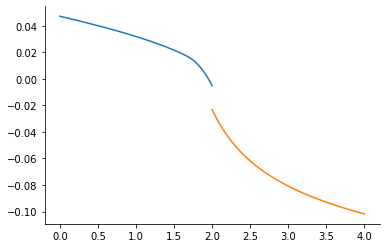

In [75]:
ϕ_bound = np.average(ϕ_carb_list, axis=0, weights=πᵈ_carb[:,-1])
plt.plot(y_grid[:numy_bar+1], ϕ_carb)
plt.plot(y_grid[numy_bar:], ϕ_bound[numy_bar:])

In [76]:
yt_carb, et_carb, πᵈt_carb, πᶜt_carb, ιt_carb, ht_carb = simulate_jump(y_grid[:numy_bar+1], ems_carb, πᶜ_carb, πᵈ_carb, ι_carb, h_carb,  θcarb_list)

Text(0.5, 0, 'years')

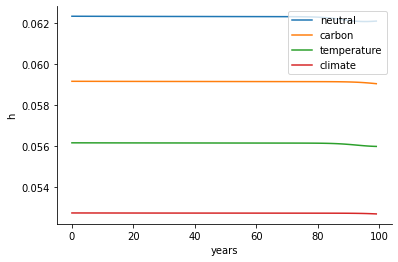

In [77]:
plt.plot(ht[ht>0], label="neutral")
plt.plot(ht_carb[ht_carb>0], label = "carbon")
plt.plot(ht_temp[ht_temp>0], label = "temperature")
plt.plot(ht_avg[ht_avg>0], label = "climate")
plt.legend()
plt.ylabel('h')
plt.xlabel('years')
# plt.ylim(0,0.0035)

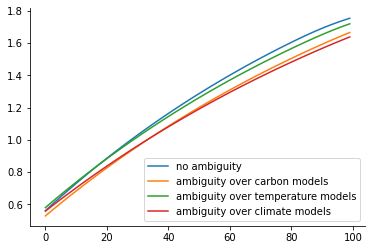

In [83]:
plt.plot(yt[yt>0],label="no ambiguity")
plt.plot(yt_carb[yt_carb>0],label="ambiguity over carbon models")
plt.plot(yt_temp[yt_temp>0],label="ambiguity over temperature models")
plt.plot(yt_avg[yt_avg>0],label="ambiguity over climate models")
plt.legend()

(0.0, 100.0)

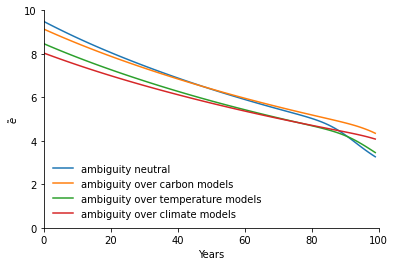

In [86]:
plt.plot(et[et>0], label="ambiguity neutral")
plt.plot(et_carb[et_carb>0], label="ambiguity over carbon models")
plt.plot(et_temp[et_temp>0], label="ambiguity over temperature models")
plt.plot(et_avg[et_avg>0], label="ambiguity over climate models")
plt.legend(frameon=False)
plt.ylabel("$\\tilde e$")
plt.xlabel('Years')
plt.ylim(0,10)
plt.xlim(0,100)
# plt.savefig("../figures/ems_partition_damage.png", facecolor='w', edgecolor='w',bbox_inches="tight")

In [ ]:
y_grid_cap = y_grid[:numy_bar+1]

In [ ]:
# solve for approach 2
ς = 1/10
ξₘ = 0.1
dmg_weight = np.array([0.5, 0.5])
dΛ = γ1 + γ2*y_grid_cap
ϕ_bound = np.average(ϕ_list, axis=0, weights=dmg_weight)
tol = 1e-8
ϕ = - δ*η*y_grid_cap**2
dy = y_grid_cap[1] - y_grid_cap[0]
ems = δ*η
ems_old = ems
episode = 0
ϵ = .3
lhs_error = 1
πo = np.ones(len(γ3_list))/len(γ3_list)
while lhs_error > tol:
    ϕ_old = ϕ.copy()
    dϕdy = derivative_1d(ϕ, 1, dy, True)
    dϕdyy = derivative_1d(ϕ, 2, dy, True)
    # update control
    temp = dϕdy + (η-1)*dΛ
    a = dϕdyy*σy**2  
    b = temp*θ
    c = δ*η
    Δ = b**2 - 4*a*c
    Δ[Δ < 0] = 0
    root1 = (-b - np.sqrt(Δ))/(2*a)
    root2 = (-b + np.sqrt(Δ))/(2*a)
    if root1.all() > 0:
        ems_new = root1
    else:
        ems_new = root2
    ems_new[ems_new < 1e-15] = 1e-15
    ems = ems_new*1 + ems_old*0.
    inside = np.array([πo[i]*np.exp(1/ξₘ*(ϕ - ϕ_list[i][:numy_bar+1])) for i in range(len(γ3_list))])
    sum_inside = np.sum(inside, axis=0)
    # coefficients
    A = -δ*np.ones(y_grid_cap.shape)
    By = θ*ems
    Cyy = ems**2*σy**2/2
    D = δ*η*np.log(ems) + (η-1)*dΛ*θ*ems - ξₘ*get_intensity(y_grid_cap,ς)*np.log(sum_inside)
    # solver
    ϕ_new = solve_ode(A, By, Cyy, D, y_grid_cap, ϕ, ϵ, (True, ϕ_bound[numy_bar]))
    rhs = -δ*ϕ_new + By*dϕdy + Cyy*dϕdyy + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
    ϕ = ϕ_new
    episode += 1
    ems_old = ems
    print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))

In [ ]:
plt.plot(y_grid_cap, ϕ)
plt.plot(y_grid[numy_bar:], ϕ_bound[numy_bar:])

In [ ]:
plt.plot(ems)